In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc
import matplotlib.cm as cm

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 33)
pl.rc('legend', fontsize = 33)
pl.rc('axes', linewidth=1.5)
# sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
# trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')
sim = h5py.File('/disk1/lbignone/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/lbignone/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp



In [37]:
# ok, lets test tha tidal stripping at peri
Msun = 1.988*1e30 # msun in kg
kpc = 3.086*1e19 # kpc in m
G = 4.3*1e-6 # kpc/M_sun km^2/s^2
DMmass = sim['SnapNumber_128/Header/MassTable'][1]

def tidal_v2(idd, iddC, snap):
    # get tidal form anything around , lets say I dont know, what i think is close
    # 200 kpc is almost the virial radius, so 100 kpc should be good, and the center always, obviously.
    
    OFFGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    OFFDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
    OFFStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
    StarMass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStars[0]:OFFStars[1]]
    GasMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGas[0]:OFFGas[1]]
    DMMass = DMmass*np.ones(OFFDM[1]-OFFDM[0]) 

    MassList = list(StarMass)
    MassList.extend(list(GasMass))
    MassList.extend(list(DMMass))
    MassList = np.array(MassList)

    OFFGasC = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][iddC].astype('int')
    OFFDMC = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][iddC].astype('int')
    OFFStarsC = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][iddC].astype('int')

    CenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    CenG = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    distB = np.sqrt(np.sum((CenG-CenP)**2.))

    StarPosC = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    GasPosC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    DMPosC = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMC[0]:OFFDMC[1]]

    xSC, ySC, zSC = StarPosC[:,0] - CenP[0], StarPosC[:,1] - CenP[1], StarPosC[:,2] - CenP[2]
    rSC = np.sqrt(xSC**2.+ySC**2.+zSC**2.)
    iSCN = np.where(rSC<distB)

    xGC, yGC, zGC = GasPosC[:,0] - CenP[0], GasPosC[:,1] - CenP[1], GasPosC[:,2] - CenP[2]
    rGC = np.sqrt(xGC**2.+yGC**2.+zGC**2.)
    iGCN = np.where(rGC<distB)

    xDC, yDC, zDC = DMPosC[:,0] - CenP[0], DMPosC[:,1] - CenP[1], DMPosC[:,2] - CenP[2]
    rDC = np.sqrt(xDC**2.+yDC**2.+zDC**2.)
    iDCN = np.where(rDC<distB)

    SMassC = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    StarMassC = np.sum(SMassC[iSCN])
    GMassC = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    GasMassC = np.sum(GMassC[iGCN])
    DMMassC = DMmass*(iDCN[0].size) 

    CenMass = StarMassC+GasMassC+DMMassC
    
    CenPos = CenP-CenG
    
    GasPos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGas[0]:OFFGas[1]]
    Gx, Gy, Gz = GasPos[:,0] - CenG[0], GasPos[:,1] - CenG[1], GasPos[:,2] - CenG[2]
    StarPos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStars[0]:OFFStars[1]]
    Sx, Sy, Sz = StarPos[:,0] - CenG[0], StarPos[:,1] - CenG[1], StarPos[:,2] - CenG[2]
    DMPos = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDM[0]:OFFDM[1]]
    Dx, Dy, Dz = DMPos[:,0] - CenG[0], DMPos[:,1] - CenG[1], DMPos[:,2] - CenG[2]
    
    X, Y, Z = [], [], []
    X.extend(list(Sx)), Y.extend(list(Sy)), Z.extend(list(Sz))
    X.extend(list(Gx)), Y.extend(list(Gy)), Z.extend(list(Gz))
    X.extend(list(Dx)), Y.extend(list(Dy)), Z.extend(list(Dz))
    
    X, Y, Z = np.array(X), np.array(Y), np.array(Z)
    
    # I think we got all, so far.
    Xt, Yt, Zt = [], [], []
    
    CenMassM = CenMass*1e10 # in M_sun
    
    for ms, xx, yy, zz in zip(MassList, X, Y, Z):
        msS = ms*1e10 # same
        dist = np.sqrt((xx-CenPos[0])**2+(yy-CenPos[1])**2+(zz-CenPos[2])**2)
        cross = np.cross(np.array([xx, yy, zz]), CenPos)
        tt = G*msS*CenMassM*cross/dist**3. # i dont know if this is gonna make sense, i guess is not to heavy
        
        Xt.append(tt[0]), Yt.append(tt[1]), Zt.append(tt[2])
        
#     Xt, Yt, Zt = np.array(Xt), np.array(Yt), np.array(Zt)
    
#     XTT, YTT, ZTT = np.sum(Xt), np.sum(Yt), np.sum(Zt)
#     To = np.sqrt(XTT**2+YTT**2+ZTT**2.)

    
    # and lets find galaxies around, I mean, any galaxy will suffice
    OtherGals = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][()]
    #remove the central
#     OtherG = np.delete(OtherGals, cen, 0)
    distFromOt = OtherGals - CenG
    dddist = np.sqrt(distFromOt[:,0]**2+distFromOt[:,1]**2+distFromOt[:,2]**2.)
    
    ik = np.where(dddist<100)[0] # idk, i can change that.
    
    iik = ik[np.where((ik!=iddC) & (ik!=idd))[0]]
    
    z = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    print(np.sort(dddist[iik]), Cosmo.lookback_time(z))
    
    for ii in iik:
        ddist = dddist[ii]
        Tpos = distFromOt[ii] 
        
        CenT = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ii]
        
        OFFGasT = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][ii].astype('int')
        OFFDMT = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][ii].astype('int')
        OFFStarsT = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][ii].astype('int')
        
        StarPosT = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsT[0]:OFFStarsT[1]]
        GasPosT = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasT[0]:OFFGasT[1]]
        DMPosT = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMT[0]:OFFDMT[1]]

        xST, yST, zST = StarPosT[:,0] - CenT[0], StarPosT[:,1] - CenT[1], StarPosT[:,2] - CenT[2]
        rST = np.sqrt(xST**2.+yST**2.+zST**2.)
        iSTN = np.where(rST<ddist)
        
        xGT, yGT, zGT = GasPosT[:,0] - CenT[0], GasPosT[:,1] - CenT[1], GasPosT[:,2] - CenT[2]
        rGT = np.sqrt(xGT**2.+yGT**2.+zGT**2.)
        iGTN = np.where(rGT<ddist)

        xDT, yDT, zDT = DMPosT[:,0] - CenT[0], DMPosT[:,1] - CenT[1], DMPosT[:,2] - CenT[2]
        rDT = np.sqrt(xDT**2.+yDT**2.+zDT**2.)
        iDTN = np.where(rDT<ddist)

        SMassT = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsT[0]:OFFStarsT[1]]
        StarMassT = np.sum(SMassT[iSTN])
        GMassT = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasT[0]:OFFGasT[1]]
        GasMassT = np.sum(GMassT[iGTN])
        DMMassT = DMmass*(iDTN[0].size) 

        TMass = StarMassT+GasMassT+DMMassT
        TMass = TMass*1e10
        
#         XtT, YtT, ZtT = [], [], []
        for ms, xx, yy, zz in zip(MassList, X, Y, Z):
            msS = ms*1e10 # same
            dist = np.sqrt((xx-Tpos[0])**2+(yy-Tpos[1])**2+(zz-Tpos[2])**2)
            cross = np.cross(np.array([xx, yy, zz]), Tpos)
            tt = G*msS*TMass*cross/dist**3. # i dont know if this is gonna make sense, i guess is not too heavy

            Xt.append(tt[0]), Yt.append(tt[1]), Zt.append(tt[2])

#         XtT, YtT, ZtT = np.array(XtT), np.array(YtT), np.array(ZtT)

#         XTTt, YTTt, ZTTt = np.sum(XtT), np.sum(YtT), np.sum(ZtT)
        
#         Tot = np.sqrt(XTTt**2+YTTt**2+ZTTt**2.)
#         print(np.log10(To), np.log10(Tot))
#         To += Tot
    
    Xt, Yt, Zt = np.array(Xt), np.array(Yt), np.array(Zt)
    
    XTT, YTT, ZTT = np.sum(Xt), np.sum(Yt), np.sum(Zt)
    To = np.sqrt(XTT**2+YTT**2+ZTT**2.)
    
    # but this is in Km^s/s^2 M_sun, hey, thats not too bad
    ToNM = To*Msun*1e6 # now is in Nm
    
    return ToNM, To, np.sum(MassList)*1e10 # return both, just in case

In [38]:
# # how to test this? let see if not fall, for start
#  tidal_v2(4338, 4337, 128)

In [39]:
# np.log10(4097852212)

In [40]:
def getperi(gal, center):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    r, thesnap, rphys = [], [], []
    
    proy = []
    iddS, iddSC = [], []
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        vec =  galPos - cenPos
        rad = np.sqrt(np.sum(vec**2.))
        
        r.append(rad/r200)
        rphys.append(rad)
        thesnap.append(snap)
        proy.append(vec)
        iddS.append(idd)
        iddSC.append(iddC)
        
    r, rphys, thesnap = np.array(r), np.array(rphys), np.array(thesnap)
    proy = np.array(proy)
    iddS, iddSC = np.array(iddS), np.array(iddSC)
    
    ir = np.where(r<2.) # no further, just in case
    
    r, rphys, thesnap = r[ir], rphys[ir], thesnap[ir]
    proy = proy[ir]
    iddS = iddS[ir]
    iddSC = iddSC[ir]
    
    angles = []
    for i in range(len(proy)-1):
        dot = np.dot(proy[i], proy[i-1])
        cos = dot/(rphys[i]*rphys[i-1])
        if cos>1 and cos<1.001: # a failsafe
            cos=1.
        angles.append(np.arccos(cos))
        
    angles = np.array(angles)
        
    # this is backwards, it starts in teh future and it moves formward.
    r, rphys, thesnap = np.flip(r), np.flip(rphys), np.flip(thesnap)
    
    angles = np.flip(angles)
    
    iddS = np.flip(iddS)
    
    pre, r0 = 0, rphys[0]
    for i, rr in enumerate(rphys[1:]):
        if rr>r0:
            break
        else:
            r0 = rr
            pre = i+1
            
            
    physD, Snap , theID, theIDC = rphys[pre], thesnap[pre], iddS[pre], iddSC[pre]
    angles = angles[pre-1:]
    
    mmr = rphys.min()
    firstsnap = thesnap.min()
    Nturn = np.sum(angles)/(2.*np.pi)
    
    return physD, Snap, mmr, firstsnap, Nturn, theID, theIDC

In [41]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [42]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e19

def getTidal(gal, central):
    
    z, TSt, snaplist, dist, galMass = [], [], [], [], []
    
    Idlist, snapst  = [], []
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    ccc = 0
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        pos = np.sqrt(np.sum((galPos-groupPos)**2))
        
        if pos>2*r200:
            break
        
        ToDontCare, To, gMass = tidal_v2(idd, iddC, snap)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        snaplist.append(snap)
        TSt.append(To)
        dist.append(pos)
        
        # and now lost masses
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        z.append(zs)
        galMass.append(gMass)
        
#         print(snap)
        
    z, TSt, snaplist, dist = np.array(z), np.array(TSt), np.array(snaplist), np.array(dist)
    galMass = np.array(galMass)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return z, TSt, dist, Gas*1e10, galMass

In [43]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e19

def getSFRs(gal, central):
    
    RPS, z, SFR, snaplist, dist, RestForce = [], [], [], [], [], []
    GasMass, StarMass = [], []
    
    Idlist, snapst  = [], []
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    z2, z1 = -1., -1.
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
#         r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

#         OGas = sim['SnapNumber_{}/Groups/PartType0/Offsets'.format(snap)][group].astype('int')
#         Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][OGas[0]:OGas[1]]
#         Positions = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OGas[0]:OGas[1]]

#         Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][OGas[0]:OGas[1]]

#         i = np.where(Loc==-1)

#         Densities = Densities[i]
#         Positions = Positions[i]
        
#         X, Y, Z = Positions[:,0] - groupPos[0], Positions[:,1] - groupPos[1], Positions[:,2] - groupPos[2]
#         R = np.sqrt(X**2+Y**2+Z**2)/r200

#         rmed1, redges, rbins = sp.binned_statistic(R, Densities*1e10, statistic='median', bins=20, range=(0, 5))
#         rx = 0.5*(redges[:-1]+redges[1:])
        
#         i = np.where(np.isnan(rmed1)==True)
#         rmed1[i] = 0.

#         GroupDens = rmed1*Msun/(kpc**3.)
        
        # ok, lets measure the ram pressure

        VelCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][iddC]
        VelGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][idd]

        #Vel = np.sqrt(np.sum((VelGal - VelCen)**2.))*1e3 # in m/s

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200
        
#         DensGal = np.interp(pos, rx, GroupDens)

#         rpsEst = DensGal*Vel**2.
        
        # other way
        AllP = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][()]
        xi, yi, zi = AllP[:,0]-galPos[0], AllP[:,1]-galPos[1], AllP[:,2]-galPos[2]
        rr = np.sqrt(xi**2+yi**2+zi**2)
        inear = np.where(rr<100)[0]
        Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][inear]
        ik = np.where(Loc==-1)[0]
        iknear = inear[ik]
        #Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][iknear]
        
        IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][iknear]
        Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][iknear]
        Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][iknear]
        ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][iknear]

        tTemp = tempFromMass(Mass, Abund, IE, ne1)
        iT = np.where(tTemp>1e6)[0]
        ikTnear = iknear[iT]
        NoMasses = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][ikTnear]
        Vol = 3/.4*np.pi*100**3.
        Densities = np.sum(NoMasses)*1e10/Vol
        
        DensGal = Densities*Msun/(kpc**3.)
        
        VGas = sim['SnapNumber_{}/PartType0/Velocities'.format(snap)][iknear]
        VGas = VGas[iT]
        try:
            xVg, yVg, zVg = np.average(VGas[:,0], weights=NoMasses), np.average(VGas[:,1], weights=NoMasses), np.average(VGas[:,2], weights=NoMasses)
        except ZeroDivisionError:
            xVg, yVg, zVg = 0., 0., 0. # whatever
        VelGas = np.array([xVg, yVg, zVg])
        Vel = np.sqrt(np.sum((VelGal - VelGas)**2.))*1e3 # in m/s
        
        rpsEst = DensGal*Vel**2.
        
        GasOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        StarOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')

        gaspos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][GasOff[0]:GasOff[1]]
        starpos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][StarOff[0]:StarOff[1]]

        nindgas = np.array(range(GasOff[0], GasOff[1]))
        nindstars = np.array(range(StarOff[0], StarOff[1]))

        xg, yg, zg = gaspos[:,0]-galPos[0], gaspos[:,1]-galPos[1], gaspos[:,2]-galPos[2]
        xs, ys, zs = starpos[:,0]-galPos[0], starpos[:,1]-galPos[1], starpos[:,2]-galPos[2]

        rg = np.sqrt(xg**2+yg**2+zg**2)
        rs = np.sqrt(xs**2+ys**2+zs**2)

        rad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        ig = np.where(rg<=rad)[0]
        iss = np.where(rs<=rad)[0]

        naregas = nindgas[ig]
        narestars = nindstars[iss]

        Area = np.pi*rad**2.

        MassGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][naregas]
        MassStars = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][narestars]

        SigmaGas = np.sum(MassGas)*1e10/Area
        SigmaStars = np.sum(MassStars)*1e10/Area

        G = 4.3*1e-6 # kpc/M_sun km^2/s^2

        Rest = 2*np.pi*G*SigmaGas*SigmaStars
        RestU = Rest*1e3*Msun/(kpc**3)
        
        
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
        sfr = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][offgal[0]:offgal[1]]
        massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offgal[0]:offgal[1]]
        PosPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offgal[0]:offgal[1]]
        OptRad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        
        xTc, yTc, zTc = PosPart[:,0]-galPos[0], PosPart[:,1]-galPos[1], PosPart[:,2]-galPos[2]
        distT = np.sqrt(xTc**2.+yTc**2.+zTc**2.)
        icoun = np.where(distT<=OptRad)[0]
        
        TSFR = np.sum(sfr[icoun])
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        if pos<2.:
            z2 = zs
        if pos<1.:
            z1 = zs
        
        if pos>2:
            break
        
        #ok, i thing i got what i need.
        
#         RPS.append(rpsEst/RestU)
        RPS.append(rpsEst)
        RestForce.append(RestU)
        z.append(zs)
        SFR.append(TSFR)
        snaplist.append(snap)
        dist.append(pos)
        GasMass.append(np.sum(MassGas)*1e10)
        StarMass.append(np.sum(MassStars)*1e10)
    
        # and now lost masses
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        
    RPS, z, SFR, snaplist, dist = np.array(RPS), np.array(z), np.array(SFR), np.array(snaplist), np.array(dist)
    RestForce = np.array(RestForce)
    
    GasMass = np.array(GasMass)
    StarMass = np.array(StarMass)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
    
    Gas = np.array(Gas)
    
    return RPS, z, SFR, dist, RestForce, Gas*1e10, z1, z2, GasMass, StarMass

In [44]:
# ok, lets test this
gal, cen = 4338, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

[37.513596 63.16352  68.44614  68.52404  76.56851  77.30315  86.137566
 88.5926   92.3359   92.631165 94.06063  96.22495  97.244705] 1.7763568394002505e-15 Gyr
[37.513596 63.16352  68.44614  68.52404  76.56851  77.30315  86.137566
 88.5926   92.3359   92.631165 94.06063  96.22495  97.244705] 1.7763568394002505e-15 Gyr
[42.39404  49.112667 63.918118 76.215    83.70129  87.34582  90.39492
 91.905075 97.757126 99.123085] 0.11277063583971803 Gyr
[34.914055 47.274574 50.125423 87.92156  88.87712  94.44978  95.09797
 96.10126  98.6967   99.229675 99.23734  99.4266  ] 0.22540692663612383 Gyr
[32.950047 36.637398 51.808174 71.07717  88.33178  89.1094   89.60561
 94.03034  95.36054  95.81393  97.429855] 0.33790656159120225 Gyr
[26.345266 44.40633  55.557922 56.025105 70.58376  80.72487  85.57324
 91.01644  92.22559  92.526024 93.98599  96.66726  97.86112 ] 0.4502672070173688 Gyr
[25.250395 46.095062 52.19595  52.963554 59.10117  64.61293  65.221535
 86.27259  86.67171  88.45914  88.88901  93.03

26 26


In [14]:
RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

26 26


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


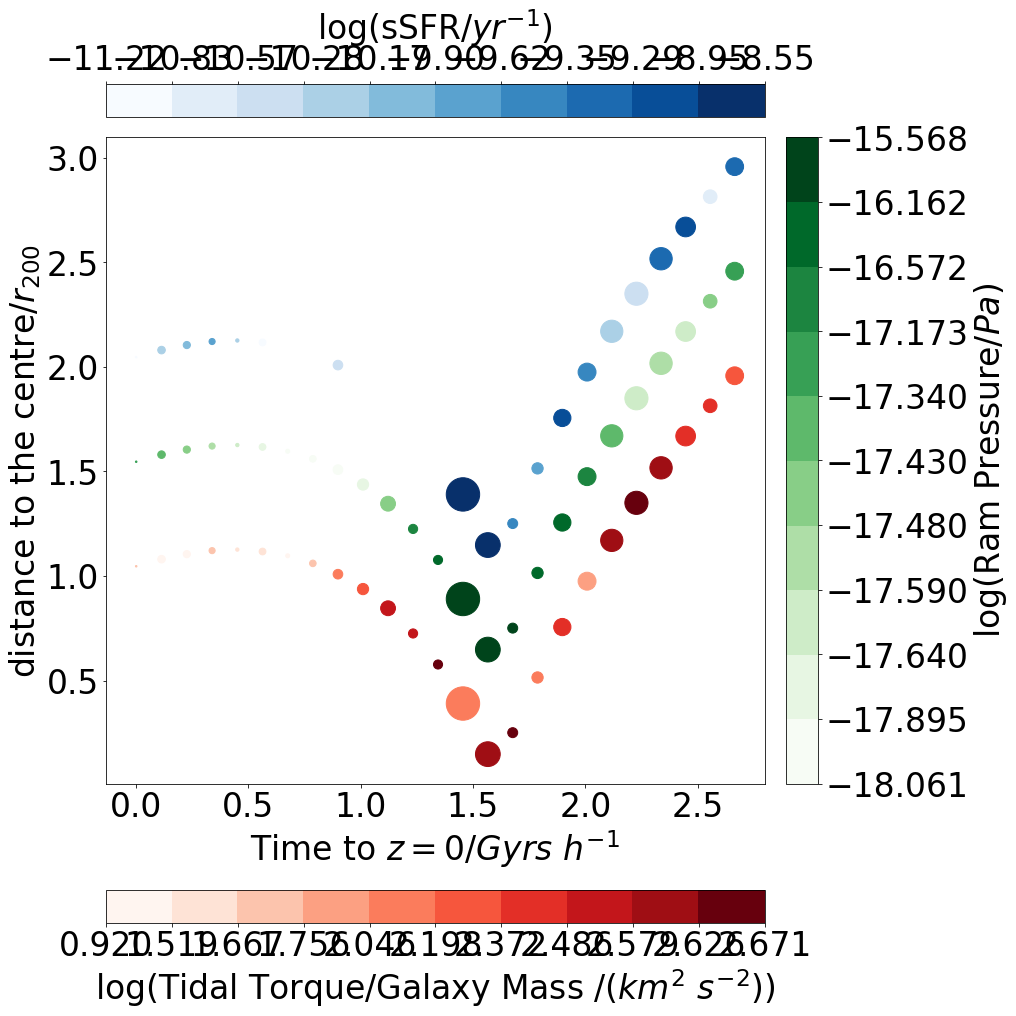

In [15]:
pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4338, RestForce_4338, Gas_4338, gMass_4338, starMass_4338, TSt_4338 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4338, dist_4338 = Time, dist
RP_4338 = RPS

128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
42 42
42 42


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


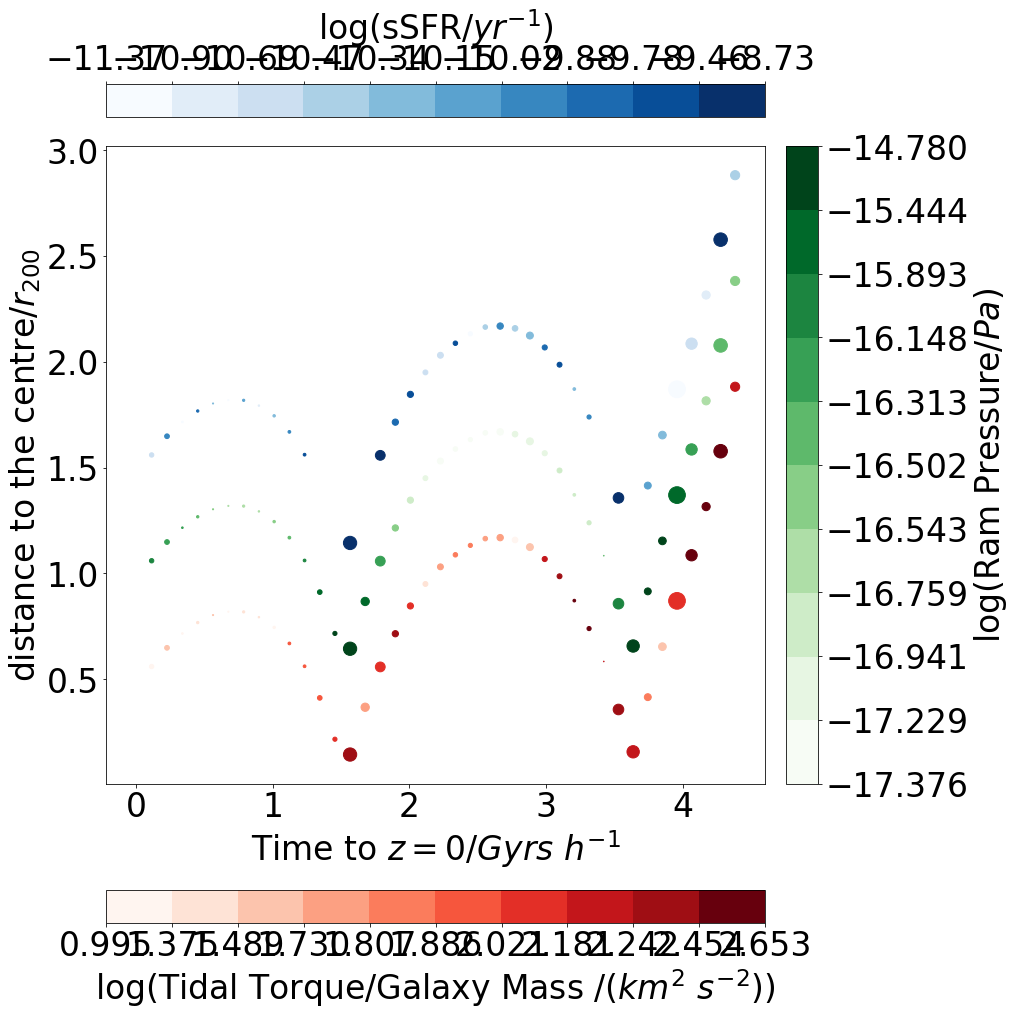

In [16]:
gal, cen = 4339, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4339, RestForce_4339, Gas_4339, gMass_4339, starMass_4339, TSt_4339 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4339, dist_4339 = Time, dist
RP_4339 = RPS

128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
26 26
26 26


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


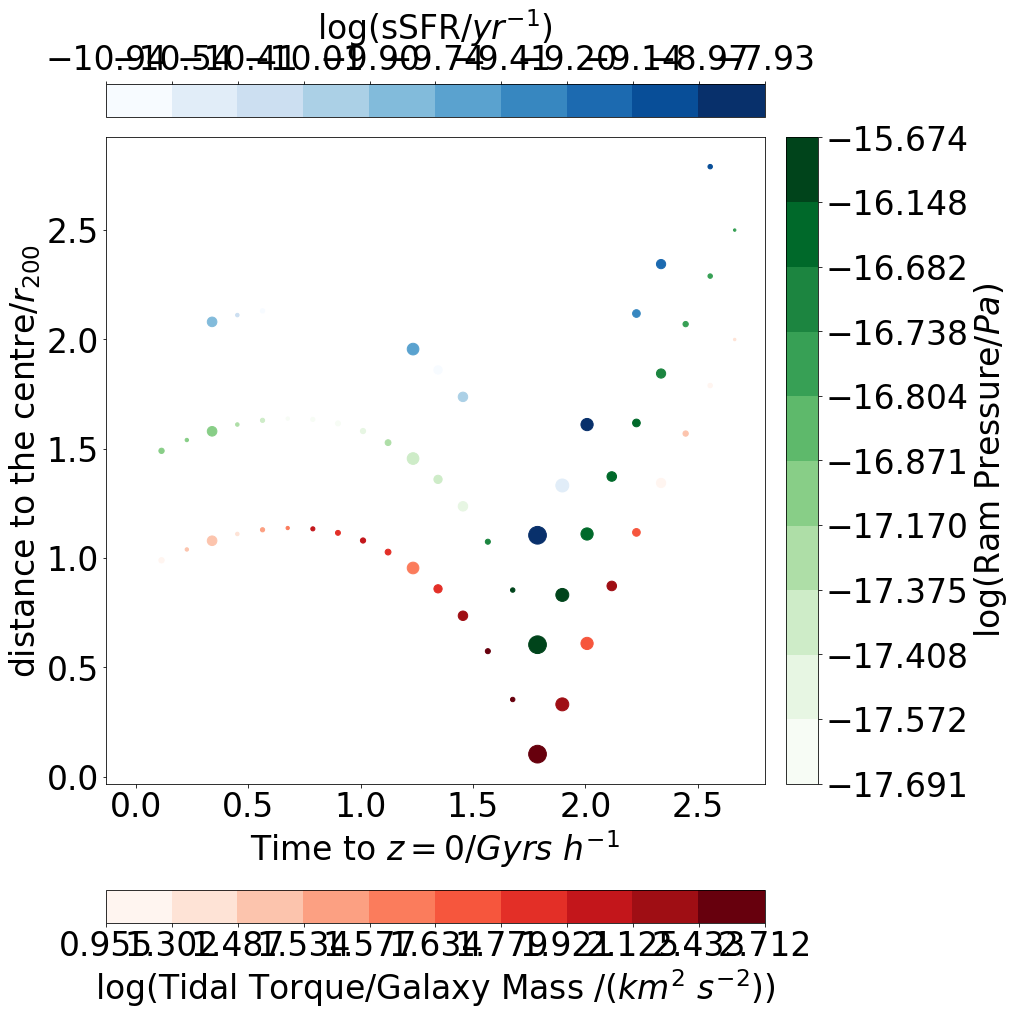

In [17]:
gal, cen = 4341, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4341, RestForce_4341, Gas_4341, gMass_4341, starMass_4341, TSt_4341 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4341, dist_4341 = Time, dist
RP_4341 = RPS

128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
46 46
46 46


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


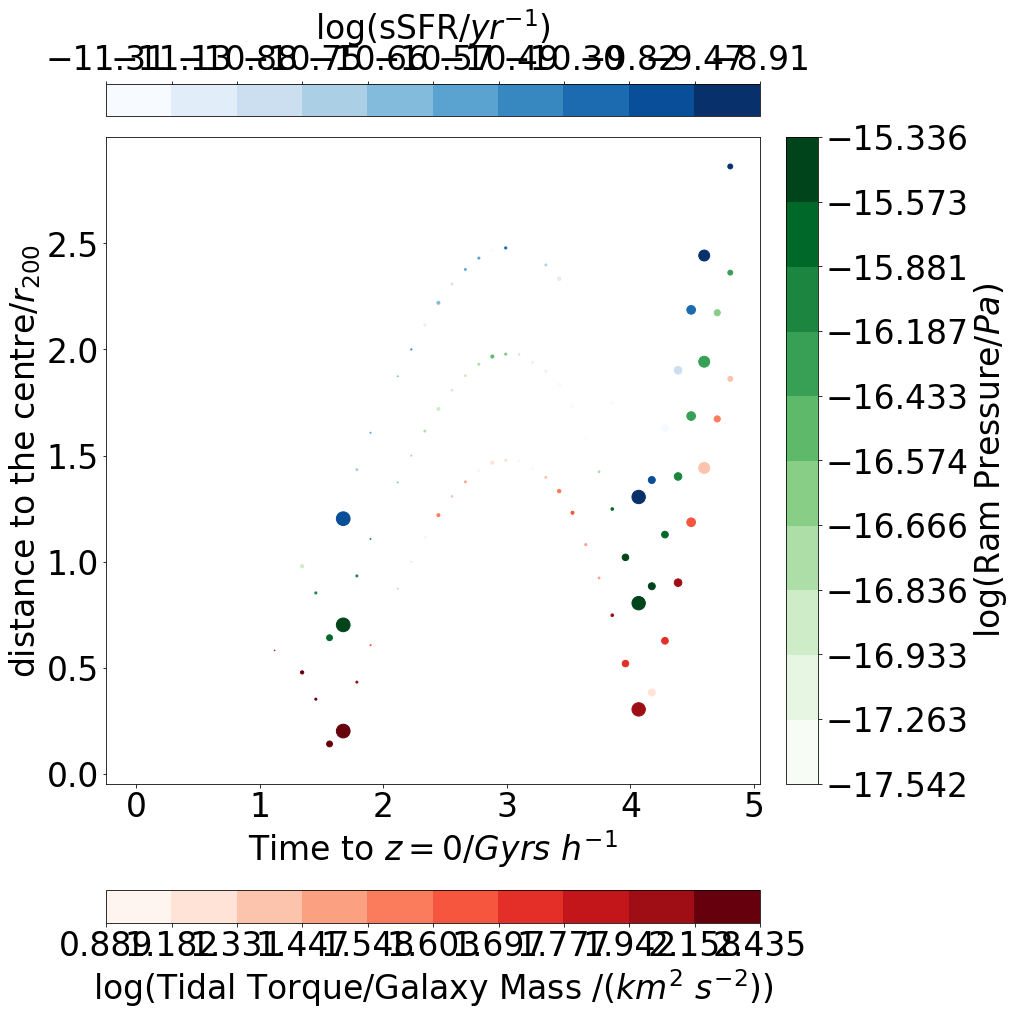

In [18]:
gal, cen = 4343, 4337
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4343, RestForce_4343, Gas_4343, gMass_4343, starMass_4343, TSt_4343 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4343, dist_4343 = Time, dist
RP_4343 = RPS

128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
37 37
37 37


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


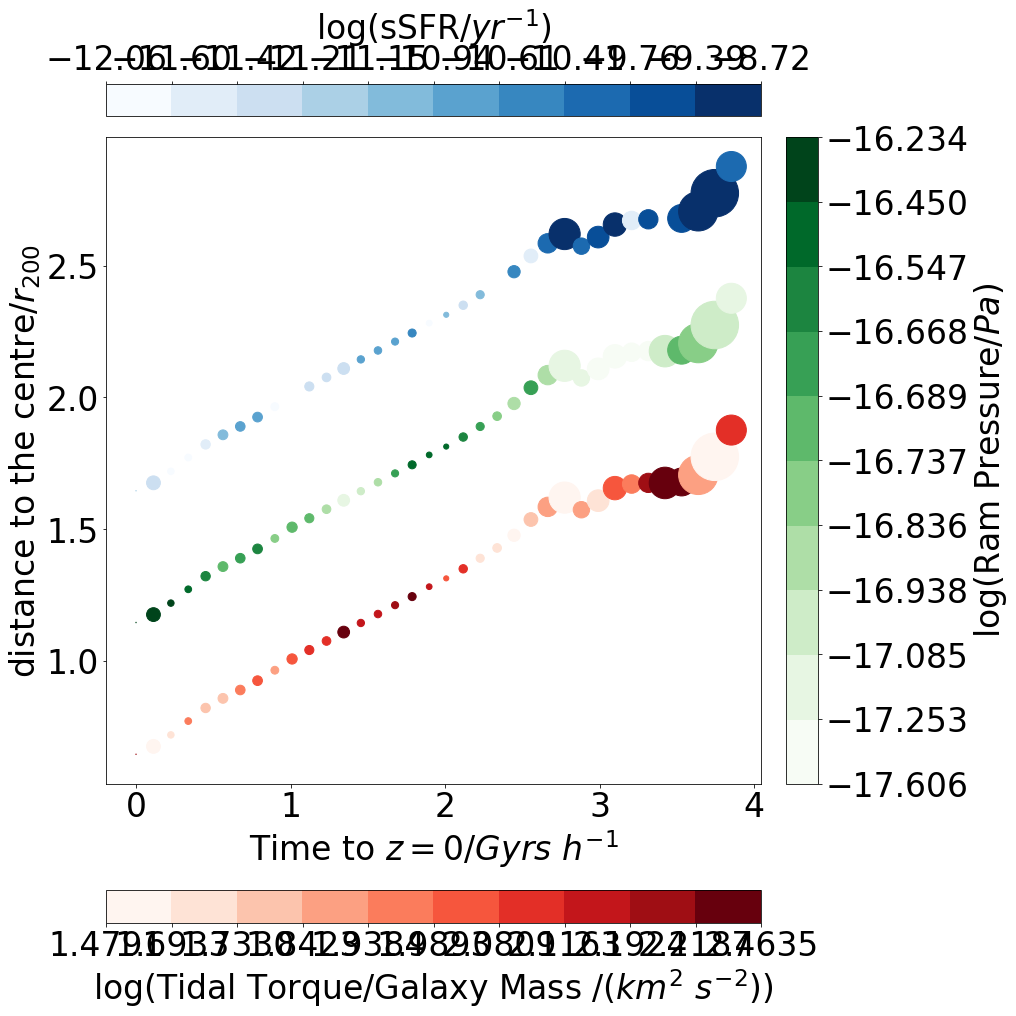

In [19]:
gal, cen = 4470, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4470, RestForce_4470, Gas_4470, gMass_4470, starMass_4470, TSt_4470 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4470, dist_4470 = Time, dist
RP_4470 = RPS

128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
35 35
35 35


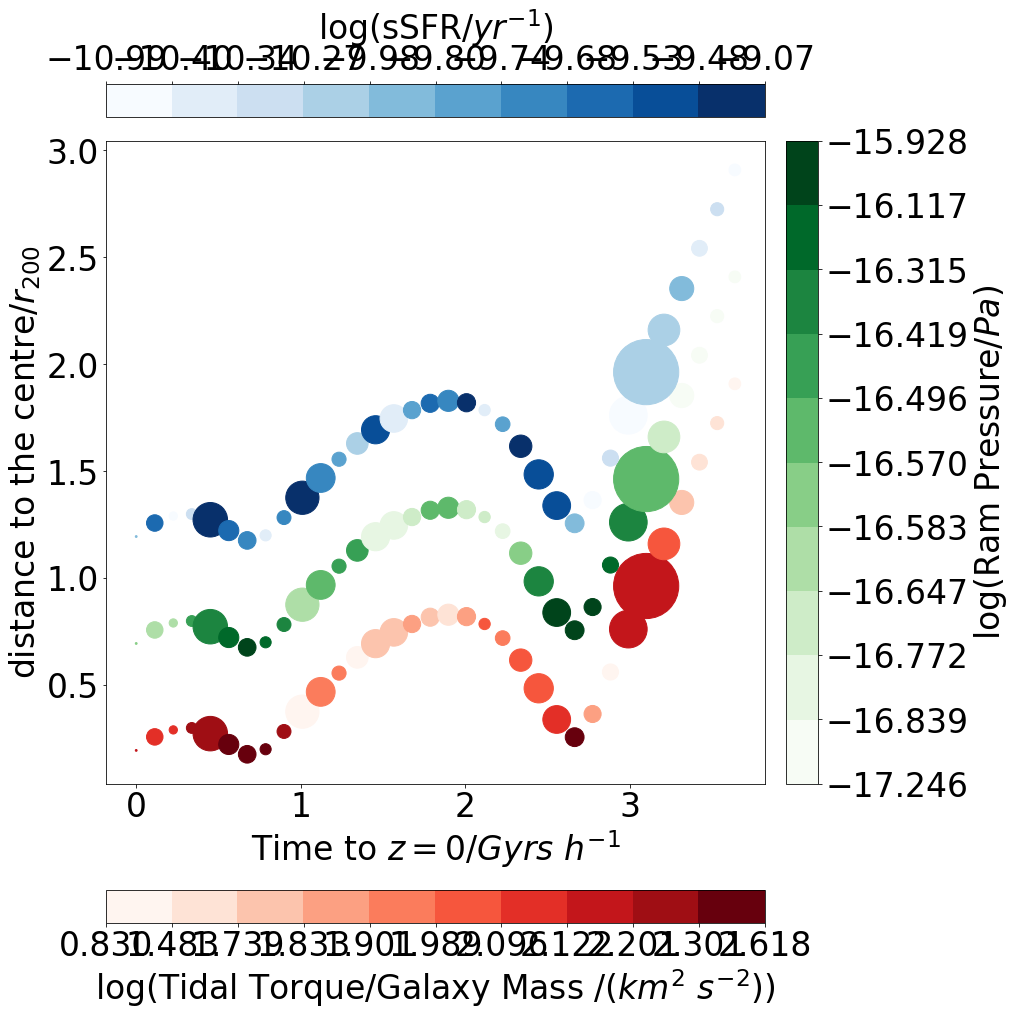

In [20]:
gal, cen = 4471, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4471, RestForce_4471, Gas_4471, gMass_4471, starMass_4471, TSt_4471 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4471, dist_4471 = Time, dist
RP_4471 = RPS

128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
22 22
22 22


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


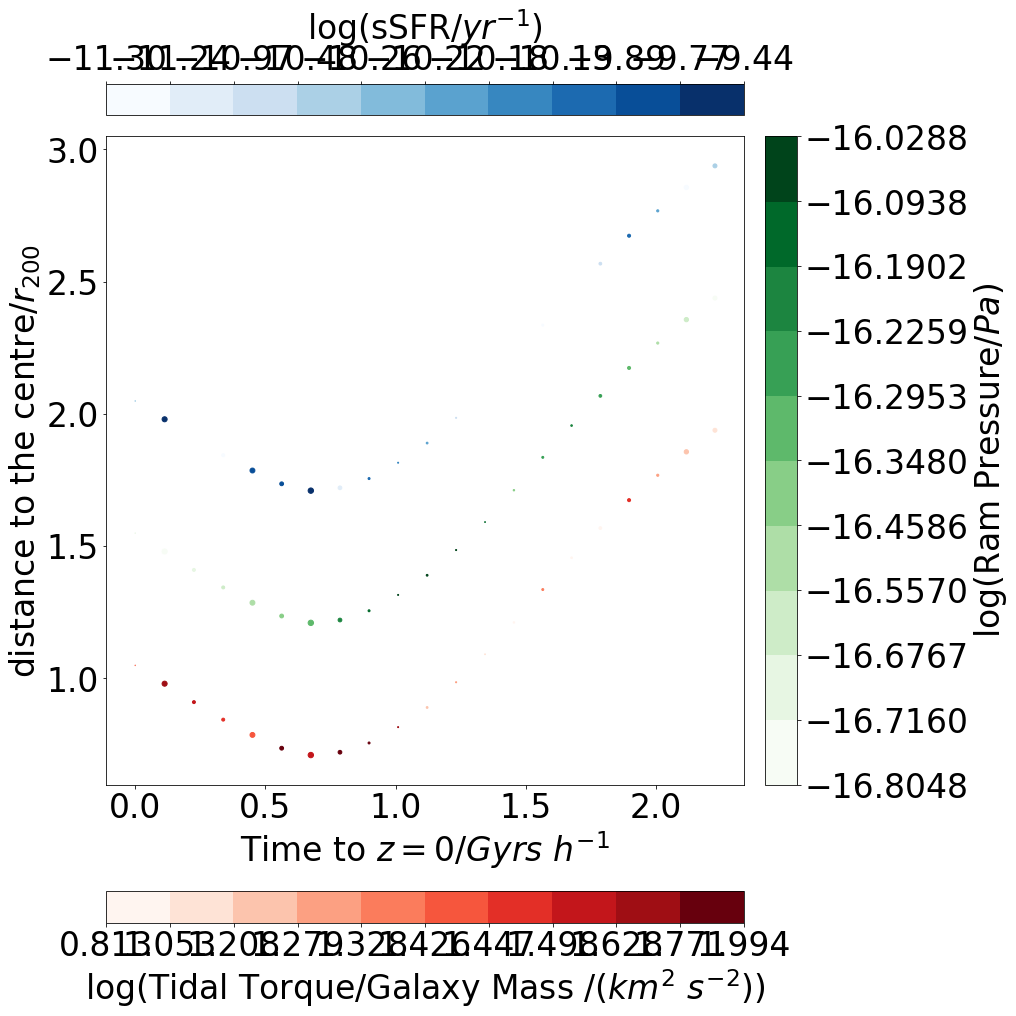

In [21]:
gal, cen = 4473, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4473, RestForce_4473, Gas_4473, gMass_4473, starMass_4473, TSt_4473 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4473, dist_4473 = Time, dist
RP_4473 = RPS

128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
33 33
33 33


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


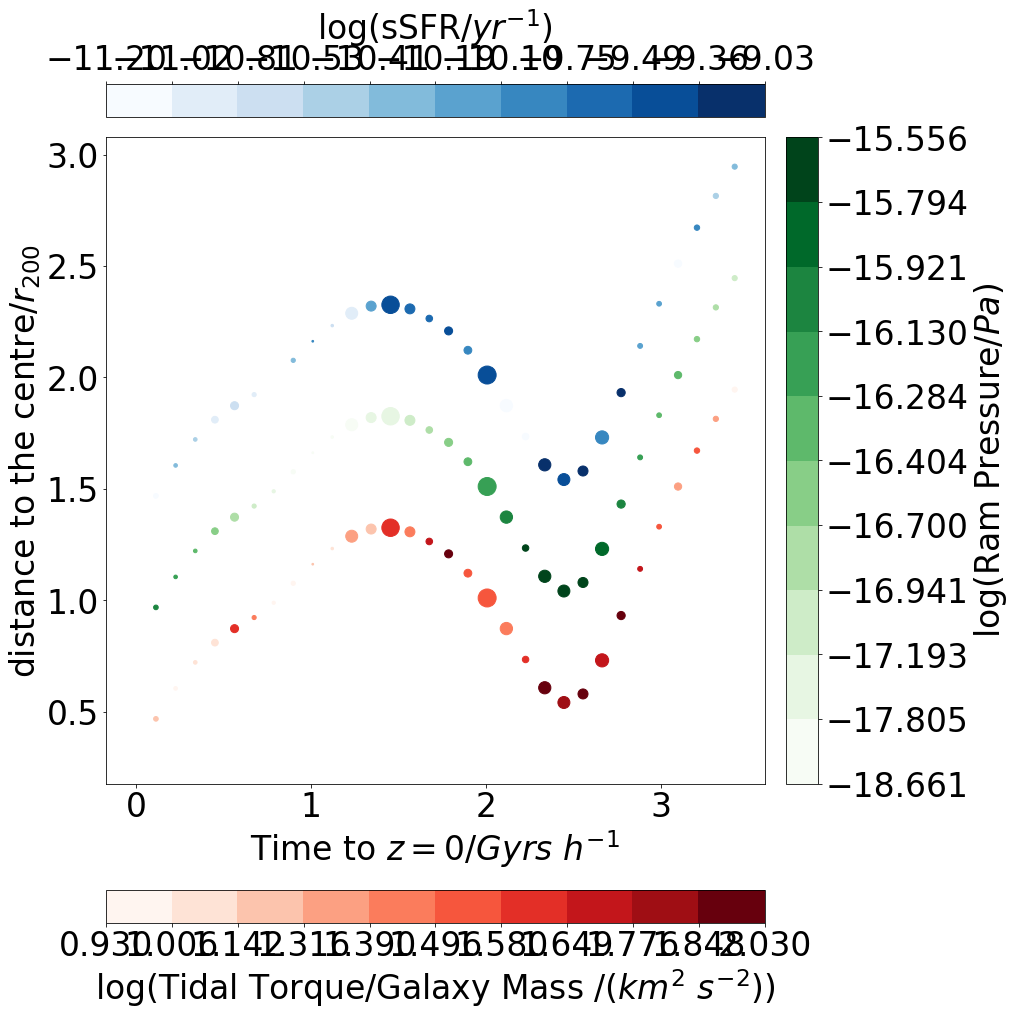

In [22]:
gal, cen = 4474, 4469
z, TSt, dist, Gas, gMass = getTidal(gal, cen)

print(z.size, dist.size)

Time = Cosmo.lookback_time(z).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

RPS, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass = getSFRs(gal, cen)

pl.figure(figsize=(14,14), constrained_layout=True)

print(Time.size, dist.size)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt/gMass), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time, dist, s=Gas/5e5, c=np.log10(TSt/gMass), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RPS), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time, dist+0.5, s=Gas/5e5, c=np.log10(RPS), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR/starMass)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time, dist+1., s=Gas/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

SFR_4474, RestForce_4474, Gas_4474, gMass_4474, starMass_4474, TSt_4474 = SFR, RestForce, Gas, gMass, starMass, TSt
Time_4474, dist_4474 = Time, dist
RP_4474 = RPS

In [23]:
# ok, lets take a look at the orientation, it should be kinda easy

def getCos(gal, centre, snap):
    velC = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][gal]
    posC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gal]
    offs = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][gal].astype('int')

    a = sim['SnapNumber_{}/Header/Time'.format(snap)][()]

    posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offs[0]:offs[1]]
    velStars = sim['SnapNumber_{}/PartType4/Velocities'.format(snap)][offs[0]:offs[1]]
    velStars = np.sqrt(a)*velStars

    Mass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][offs[0]:offs[1]]

    orad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][gal]

    x, y, z = posStars[:,0] - posC[0], posStars[:,1] - posC[1], posStars[:,2] - posC[2]
    r = np.sqrt(x**2+y**2+z**2)
    ir = np.where(r<orad)[0]

    x, y, z = x[ir], y[ir], z[ir]

    velStars = velStars[ir]
    vx, vy, vz = velStars[:,0] - velC[0], velStars[:,1] - velC[1], velStars[:,2] - velC[2]

    Mass = Mass[ir]

    Lx, Ly, Lz = [], [], []

    for xi, yi, zi, vxi, vyi, vzi in zip(x, y, z, vx, vy, vz):
        rp = np.array([xi, yi, zi])
        rv = np.array([vxi, vyi, vzi])
        l = np.cross(rp, rv)
        Lx.append(l[0])
        Ly.append(l[1])
        Lz.append(l[2])

    Lx, Ly, Lz = np.array(Lx), np.array(Ly), np.array(Lz)

    Ltot = np.array([np.sum(Mass*Lx), np.sum(Mass*Ly), np.sum(Mass*Lz)])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))

    ipro = []
    ii = 0
    for lx, ly, lz in zip(Lx, Ly, Lz):
        lnormi = np.array([lx, ly, lz])/np.sqrt(lx**2+ly**2+lz**2) 
        ddot = np.dot(lnormi, Lnorm)
        if ddot>0:
            ipro.append(ii)
        ii += 1

    Ltot = np.array([np.sum(Mass[ipro]*Lx[ipro]), np.sum(Mass[ipro]*Ly[ipro]), np.sum(Mass[ipro]*Lz[ipro])])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))
    
    cenGro = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][centre]
    velGro = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][centre]
    
    vecCen = cenGro - posC
    vecVel = velC - velGro
    
    sep = np.sqrt(np.sum(vecCen**2))
    
    vecCenN = vecCen/sep
    vecVelN = vecVel/np.sqrt(np.sum(vecVel**2.))
    
    # and cosines
    cosCen = np.dot(Lnorm, vecCenN)
    cosVel = np.dot(Lnorm, vecVelN)
    
    return cosCen, cosVel

In [24]:
Msun = 1.988*1e30
kpc = 3.086*1e19
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

# im going to remove the mass

def getAngleMass_rep(gal, central):
    
    snaplist = []
    cosV, cosC = [], []
    
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
#         group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
#         r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200

        if pos>2.:
            break
        
        # angles
        cosCen, cosVel = getCos(idd, iddC, snap)
    
        cosC.append(cosCen)
        cosV.append(cosVel)
        snaplist.append(snap)
        
    snaplist = np.array(snaplist)
    cosC = np.array(cosC)
    cosV = np.array(cosV)
        
    return cosC, cosV

In [25]:
cosC_4338, cosV_4338 = getAngleMass_rep(4338, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [26]:
cosC_4339, cosV_4339 = getAngleMass_rep(4339, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [27]:
cosC_4341, cosV_4341 = getAngleMass_rep(4341, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [28]:
cosC_4343, cosV_4343 = getAngleMass_rep(4343, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [29]:
cosC_4470, cosV_4470 = getAngleMass_rep(4470, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [30]:
cosC_4471, cosV_4471 = getAngleMass_rep(4471, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [31]:
cosC_4473, cosV_4473 = getAngleMass_rep(4473, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [32]:
cosC_4474, cosV_4474 = getAngleMass_rep(4474, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [33]:
# smooth criminal.
def smoother(TT, sSFR, RP, Gas, n):
    I = np.arange(cosC.size)
    
    newCosC, newCosV, newGas = np.zeros(I.size), np.zeros(I.size), np.zeros(I.size)
    newTT, newsSFR = np.zeros(I.size), np.zeros(I.size)
    for i in I:
        itemp = np.arange(i-n, i+n+1)
        itemp = itemp[np.where((itemp>=0) & (itemp<I[-1]))]
        tcosC = cosC[itemp]
        tcosV = cosV[itemp]
        tGas = Gas[itemp]
        tTT = TT[itemp]
        tsSFR = sSFR[itemp]
        
        tTT = tTT[np.where((np.isnan(tcosC)==False) & (np.isinf(tcosC)==False))]
        tcosV = tcosV[np.where((np.isnan(tcosV)==False) & (np.isinf(tcosV)==False))]
        tGas = tGas[np.where((np.isnan(tGas)==False) & (np.isinf(tGas)==False))]
        tTT = tTT[np.where((np.isnan(tTT)==False) & (np.isinf(tTT)==False))]
        tsSFR = tsSFR[np.where((np.isnan(tsSFR)==False) & (np.isinf(tsSFR)==False))]
        
        newCosC[i] = np.mean(tcosC)
        newCosV[i] = np.mean(tcosV)
        newGas[i] = np.mean(tGas)
        newTT[i] = np.mean(tTT)
        newsSFR[i] = np.mean(tsSFR)
        
    return newTT, newsSFR, newCosC, newCosV, newGas

In [34]:
n = 3

nTT_4338, nsSFR_4338, ncosC_4338, ncosV_4338, nGas_4338 = smoother(TSt_4338/gMass_4338, SFR_4338/starMass_4338, np.abs(cosC_4338), np.abs(cosV_4338), Gas_4338, n)
nTT_4339, nsSFR_4339, ncosC_4339, ncosV_4339, nGas_4339 = smoother(TSt_4339/gMass_4339, SFR_4339/starMass_4339, np.abs(cosC_4339), np.abs(cosV_4339), Gas_4339, n)
nTT_4341, nsSFR_4341, ncosC_4341, ncosV_4341, nGas_4341 = smoother(TSt_4341/gMass_4341, SFR_4341/starMass_4341, np.abs(cosC_4341), np.abs(cosV_4341), Gas_4341, n)
nTT_4343, nsSFR_4343, ncosC_4343, ncosV_4343, nGas_4343 = smoother(TSt_4343/gMass_4343, SFR_4343/starMass_4343, np.abs(cosC_4343), np.abs(cosV_4343), Gas_4343, n)

nTT_4470, nsSFR_4470, ncosC_4470, ncosV_4470, nGas_4470 = smoother(TSt_4470/gMass_4470, SFR_4470/starMass_4470, np.abs(cosC_4470), np.abs(cosV_4470), Gas_4470, n)
nTT_4471, nsSFR_4471, ncosC_4471, ncosV_4471, nGas_4471 = smoother(TSt_4471/gMass_4471, SFR_4471/starMass_4471, np.abs(cosC_4471), np.abs(cosV_4471), Gas_4471, n)
nTT_4473, nsSFR_4473, ncosC_4473, ncosV_4473, nGas_4473 = smoother(TSt_4473/gMass_4473, SFR_4473/starMass_4473, np.abs(cosC_4473), np.abs(cosV_4473), Gas_4473, n)
nTT_4474, nsSFR_4474, ncosC_4474, ncosV_4474, nGas_4474 = smoother(TSt_4474/gMass_4474, SFR_4474/starMass_4474, np.abs(cosC_4474), np.abs(cosV_4474), Gas_4474, n)

Text(0, 0.5, 'log(Tidal Torque/Galaxy Mass $/(km^2\\,\\,s^{-2})$)')

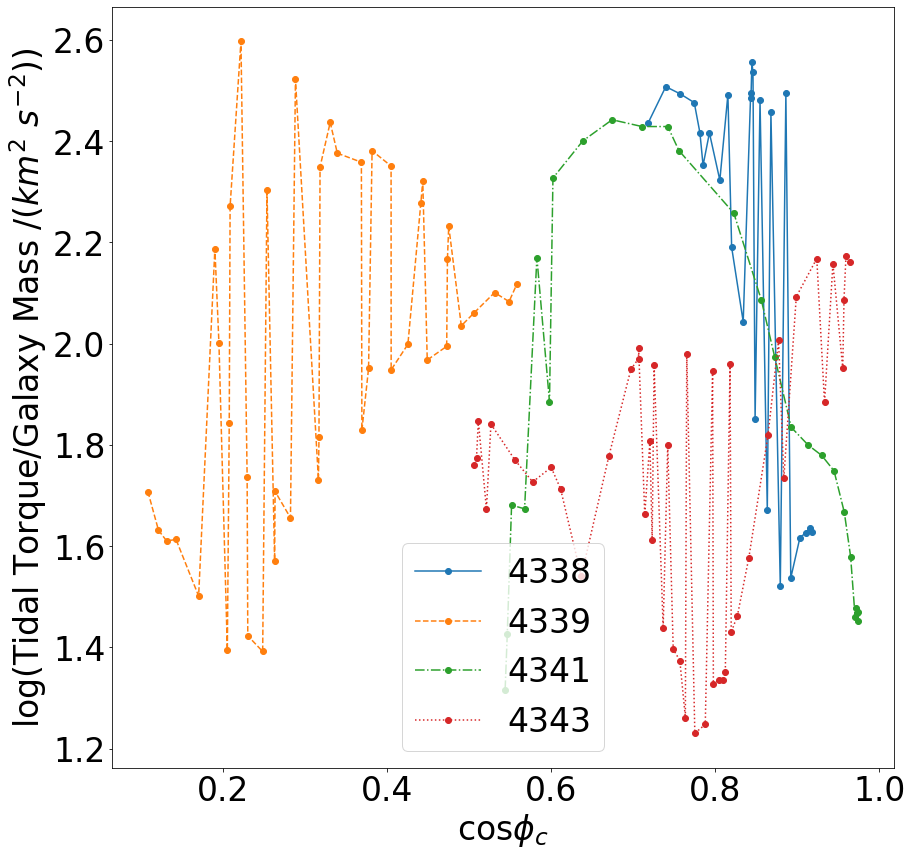

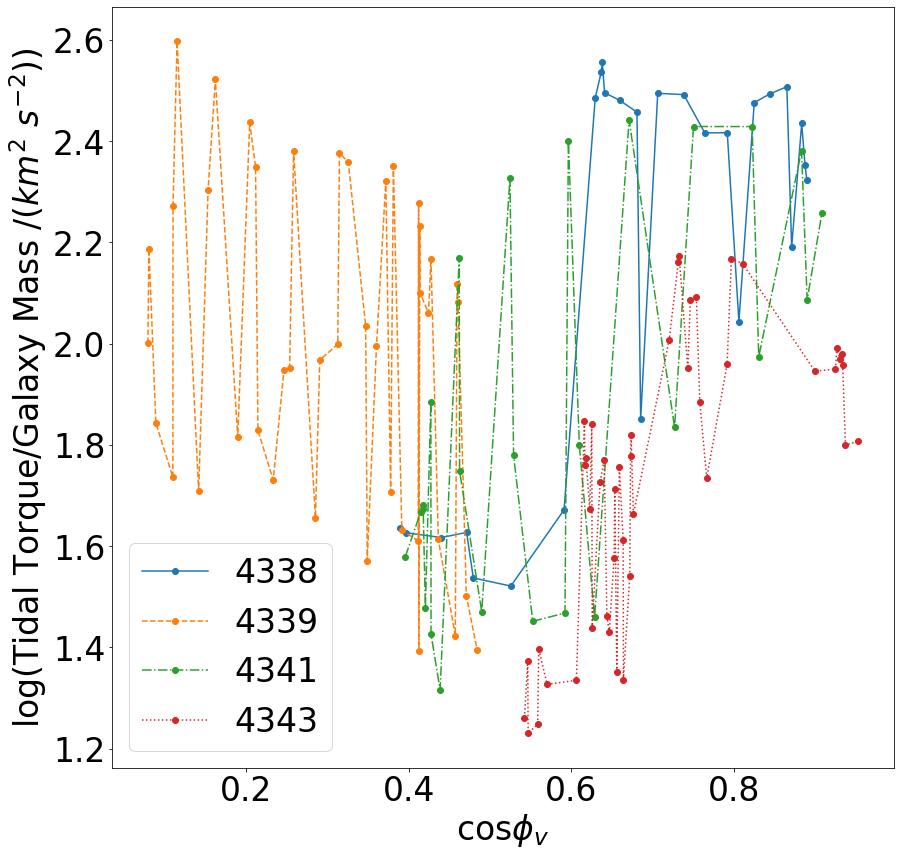

In [35]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(ncosC_4338)
ii_4339 = np.argsort(ncosC_4339)
ii_4341 = np.argsort(ncosC_4341)
ii_4343 = np.argsort(ncosC_4343)

pl.plot(ncosC_4338[ii_4338], np.log10(nTT_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(ncosC_4339[ii_4339], np.log10(nTT_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(ncosC_4341[ii_4341], np.log10(nTT_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(ncosC_4343[ii_4343], np.log10(nTT_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')

pl.figure(figsize=(14,14))

ii_4338 = np.argsort(ncosV_4338)
ii_4339 = np.argsort(ncosV_4339)
ii_4341 = np.argsort(ncosV_4341)
ii_4343 = np.argsort(ncosV_4343)

pl.plot(ncosV_4338[ii_4338], np.log10(nTT_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(ncosV_4339[ii_4339], np.log10(nTT_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(ncosV_4341[ii_4341], np.log10(nTT_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(ncosV_4343[ii_4343], np.log10(nTT_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')

Text(0, 0.5, 'log(Tidal Torque/Galaxy Mass $/(km^2\\,\\,s^{-2})$)')

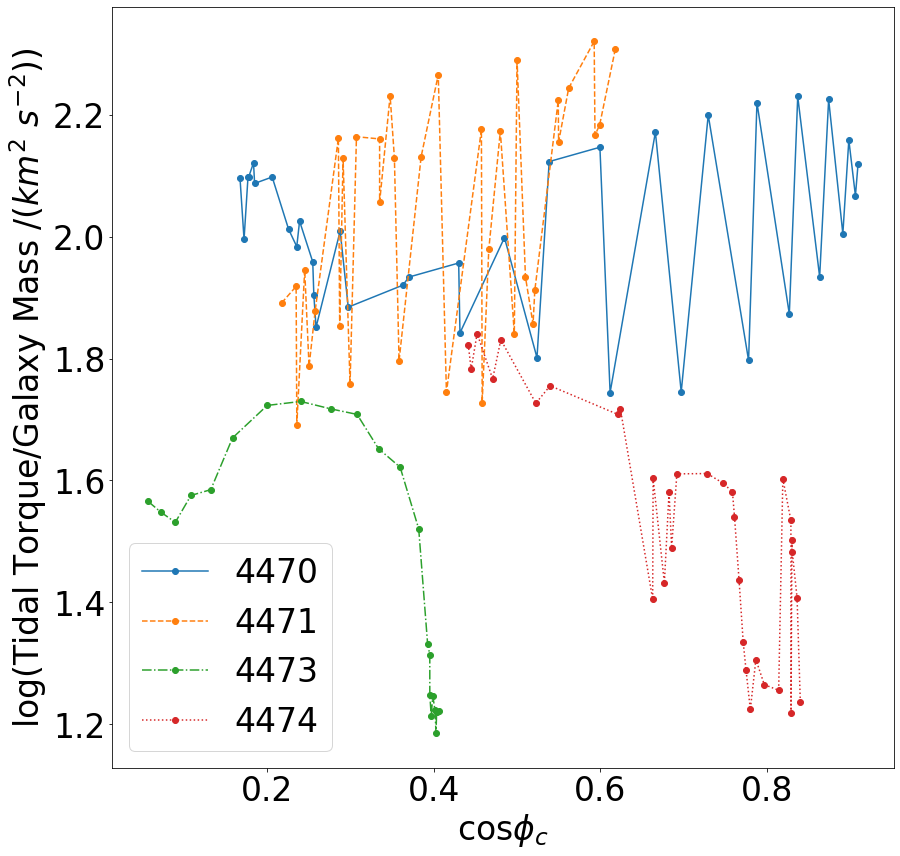

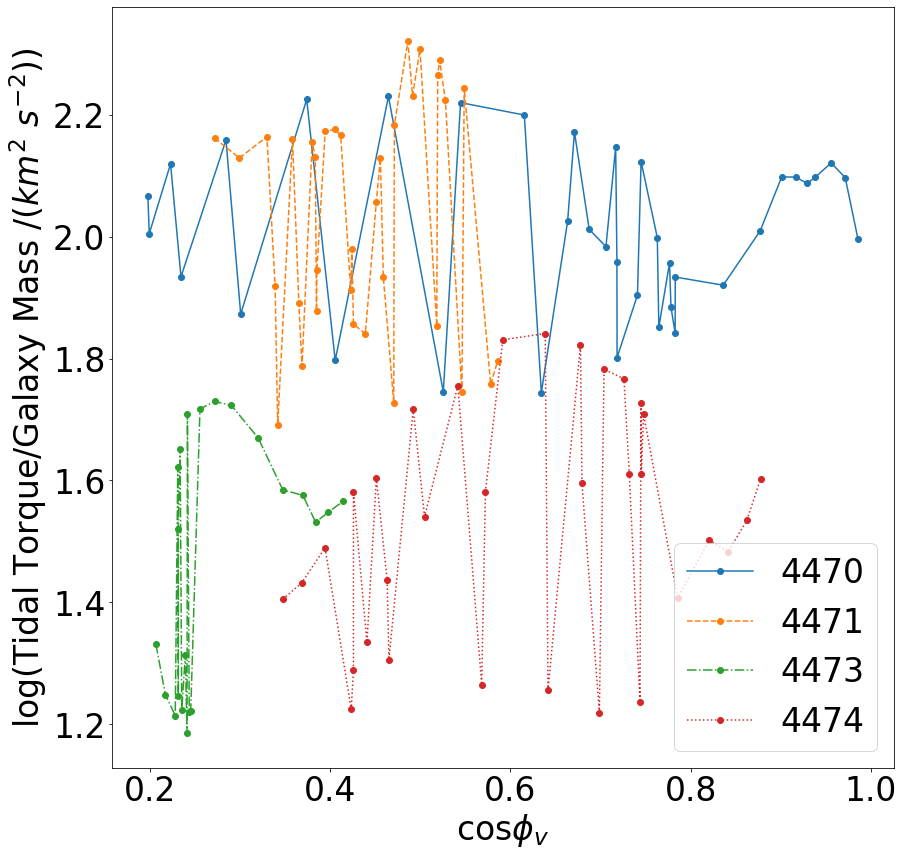

In [36]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(ncosC_4470)
ii_4471 = np.argsort(ncosC_4471)
ii_4473 = np.argsort(ncosC_4473)
ii_4474 = np.argsort(ncosC_4474)

pl.plot(ncosC_4470[ii_4470], np.log10(nTT_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(ncosC_4471[ii_4471], np.log10(nTT_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(ncosC_4473[ii_4473], np.log10(nTT_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(ncosC_4474[ii_4474], np.log10(nTT_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')

pl.figure(figsize=(14,14))

ii_4470 = np.argsort(ncosV_4470)
ii_4471 = np.argsort(ncosV_4471)
ii_4473 = np.argsort(ncosV_4473)
ii_4474 = np.argsort(ncosV_4474)

pl.plot(ncosV_4470[ii_4470], np.log10(nTT_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(ncosV_4471[ii_4471], np.log10(nTT_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(ncosV_4473[ii_4473], np.log10(nTT_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(ncosV_4474[ii_4474], np.log10(nTT_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '$\\log($sSFR$/yr^{-1})$')

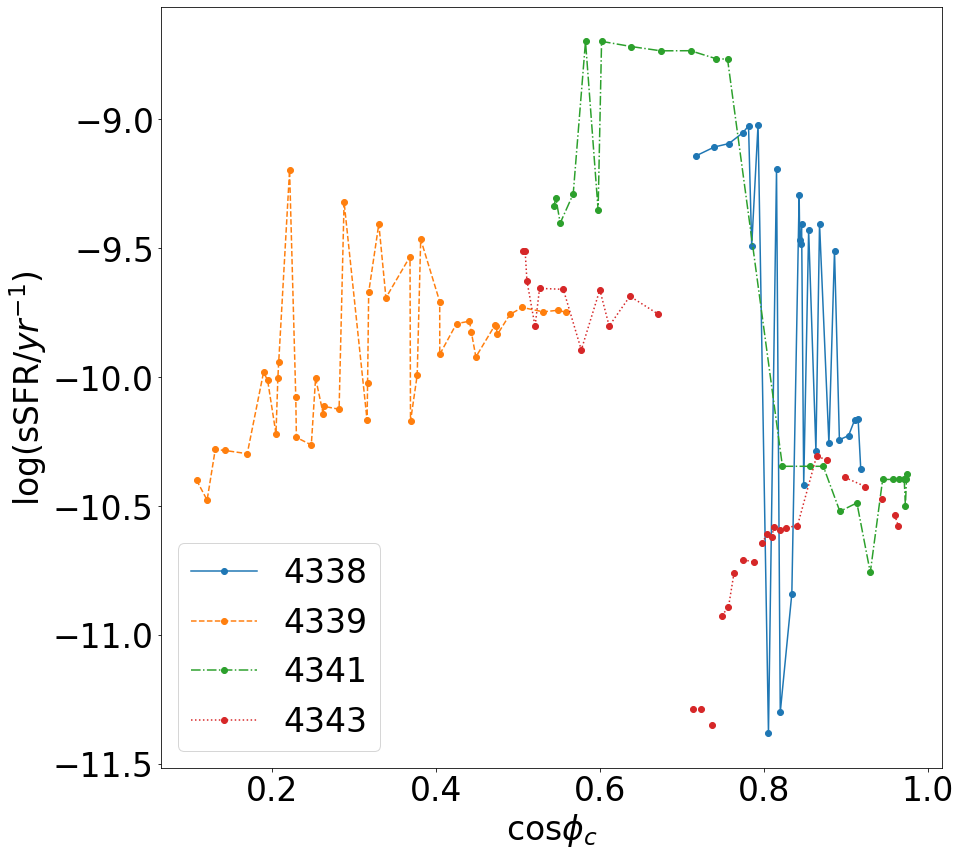

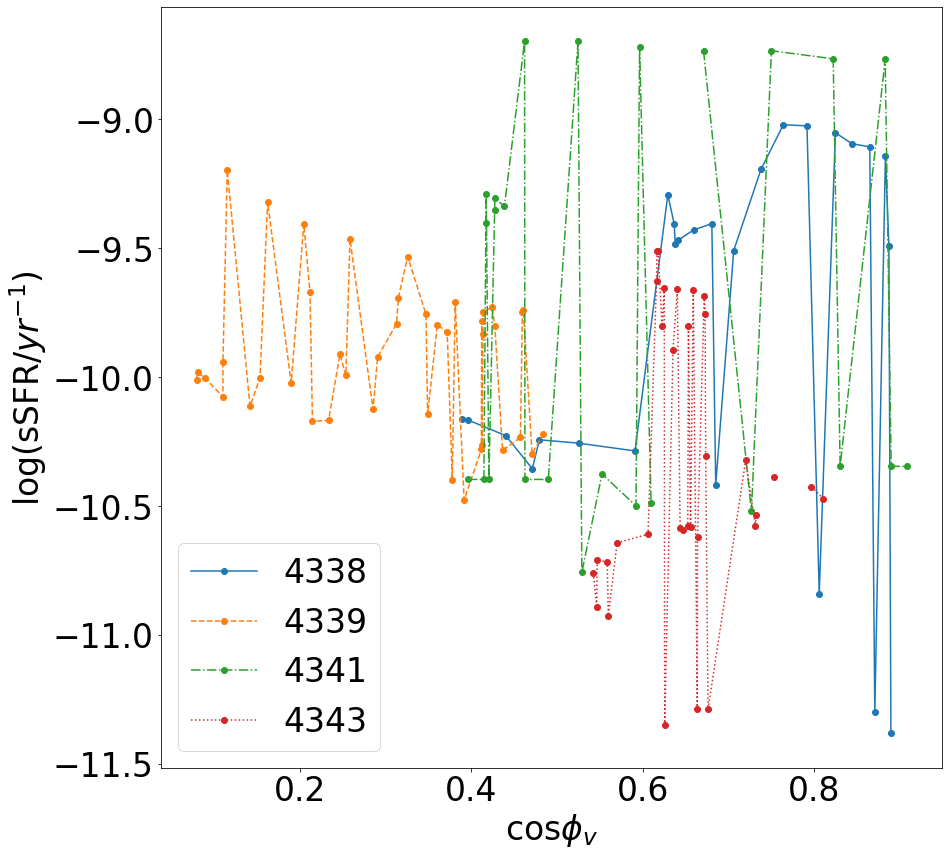

In [37]:
# ok, now sSFR

pl.figure(figsize=(14,14))

ii_4338 = np.argsort(ncosC_4338)
ii_4339 = np.argsort(ncosC_4339)
ii_4341 = np.argsort(ncosC_4341)
ii_4343 = np.argsort(ncosC_4343)

pl.plot(ncosC_4338[ii_4338], np.log10(nsSFR_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(ncosC_4339[ii_4339], np.log10(nsSFR_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(ncosC_4341[ii_4341], np.log10(nsSFR_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(ncosC_4343[ii_4343], np.log10(nsSFR_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('$\log($sSFR$/yr^{-1})$')

pl.figure(figsize=(14,14))

ii_4338 = np.argsort(ncosV_4338)
ii_4339 = np.argsort(ncosV_4339)
ii_4341 = np.argsort(ncosV_4341)
ii_4343 = np.argsort(ncosV_4343)

pl.plot(ncosV_4338[ii_4338], np.log10(nsSFR_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(ncosV_4339[ii_4339], np.log10(nsSFR_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(ncosV_4341[ii_4341], np.log10(nsSFR_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(ncosV_4343[ii_4343], np.log10(nsSFR_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('$\log($sSFR$/yr^{-1})$')

Text(0, 0.5, '$\\log($sSFR$/yr^{-1})$')

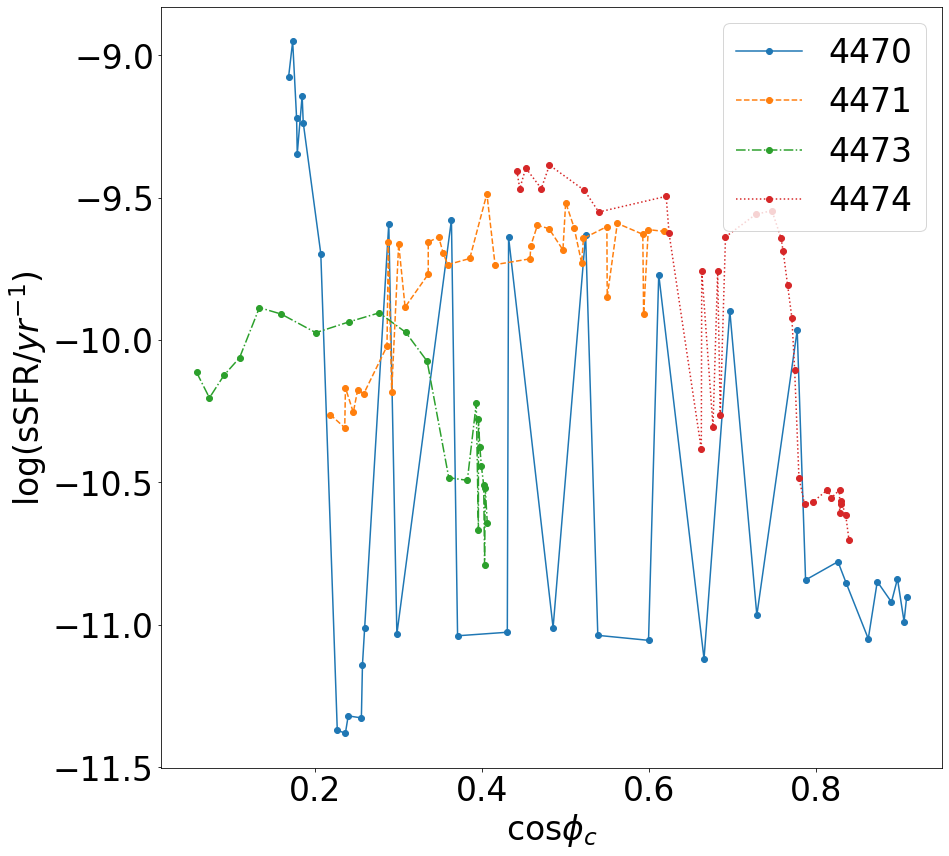

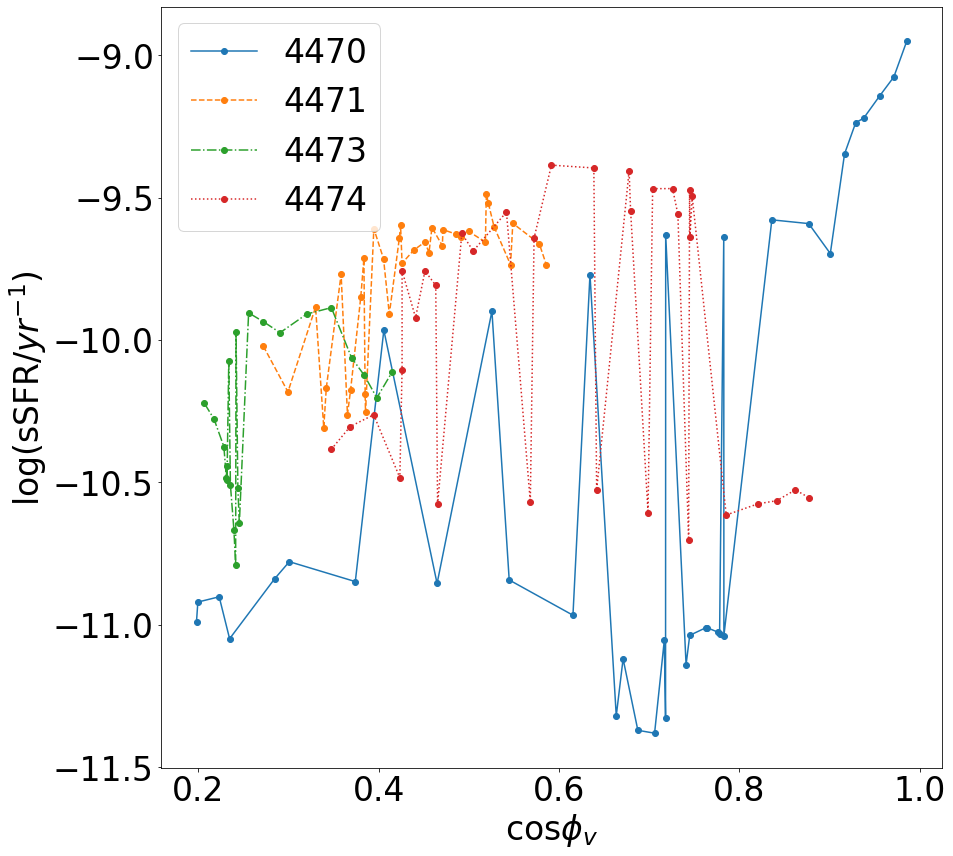

In [38]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(ncosC_4470)
ii_4471 = np.argsort(ncosC_4471)
ii_4473 = np.argsort(ncosC_4473)
ii_4474 = np.argsort(ncosC_4474)

pl.plot(ncosC_4470[ii_4470], np.log10(nsSFR_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(ncosC_4471[ii_4471], np.log10(nsSFR_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(ncosC_4473[ii_4473], np.log10(nsSFR_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(ncosC_4474[ii_4474], np.log10(nsSFR_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('$\log($sSFR$/yr^{-1})$')

pl.figure(figsize=(14,14))

ii_4470 = np.argsort(ncosV_4470)
ii_4471 = np.argsort(ncosV_4471)
ii_4473 = np.argsort(ncosV_4473)
ii_4474 = np.argsort(ncosV_4474)

pl.plot(ncosV_4470[ii_4470], np.log10(nsSFR_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(ncosV_4471[ii_4471], np.log10(nsSFR_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(ncosV_4473[ii_4473], np.log10(nsSFR_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(ncosV_4474[ii_4474], np.log10(nsSFR_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('$\log($sSFR$/yr^{-1})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

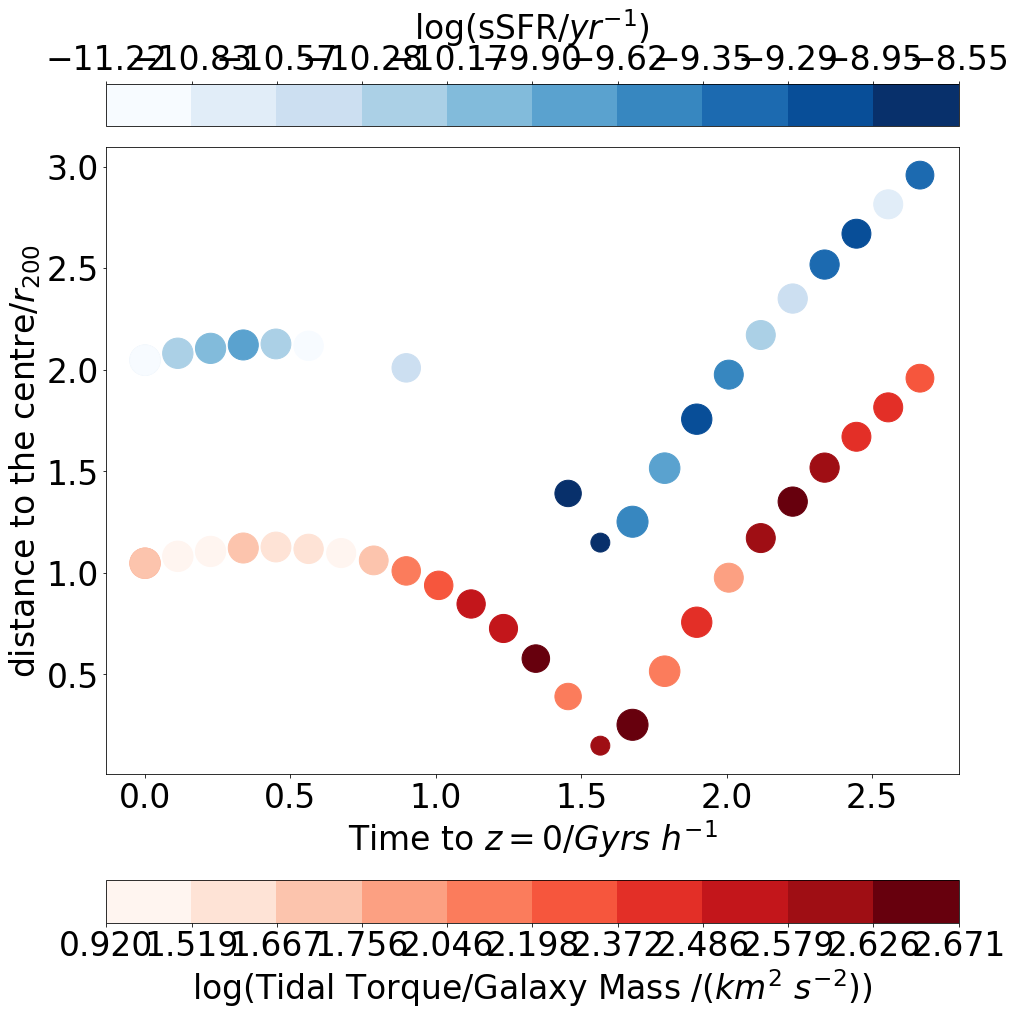

In [39]:
# ok, now some graph somewhat nicer, just two things, forget the third.

pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4338, dist_4338, s=np.abs(cosC_4338)*1e3, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4338, dist_4338+1., s=np.abs(cosC_4338)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

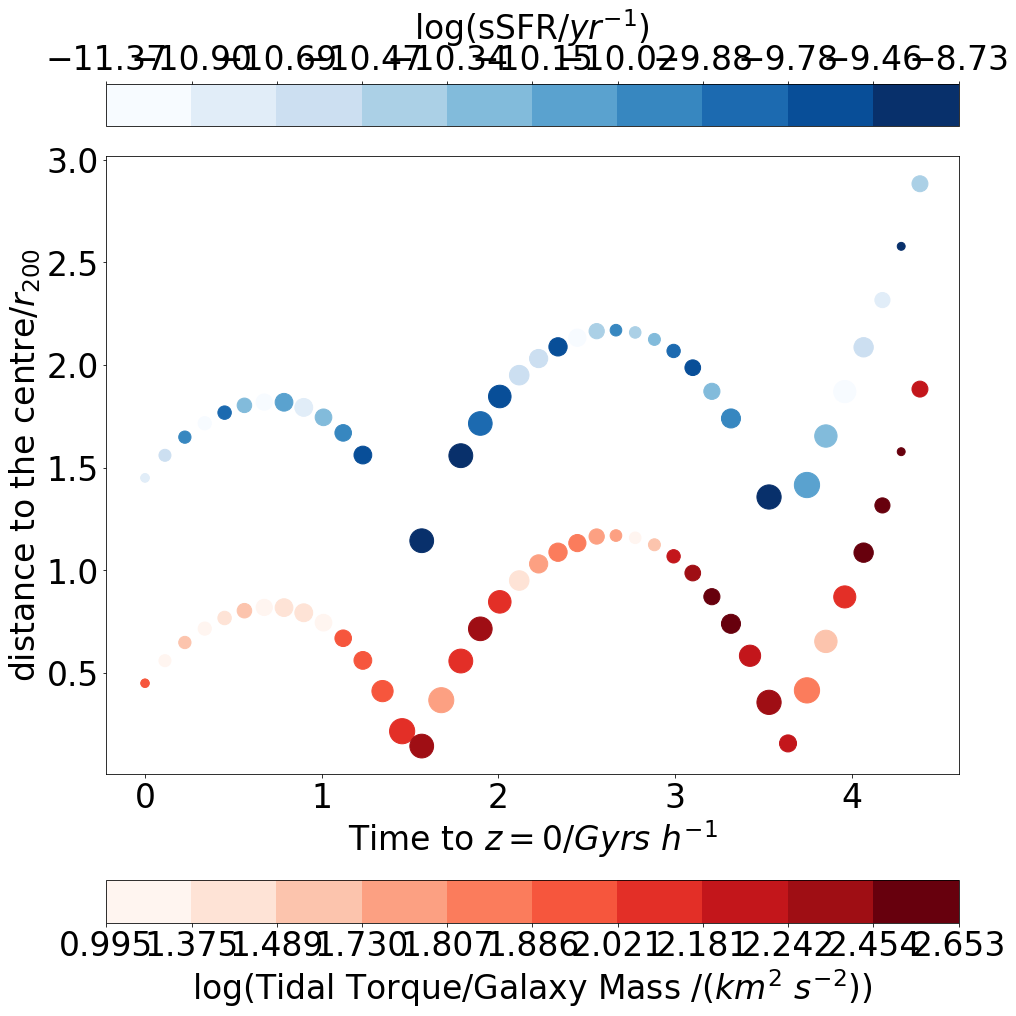

In [40]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4339, dist_4339, s=np.abs(cosC_4339)*1e3, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4339, dist_4339+1., s=np.abs(cosC_4339)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

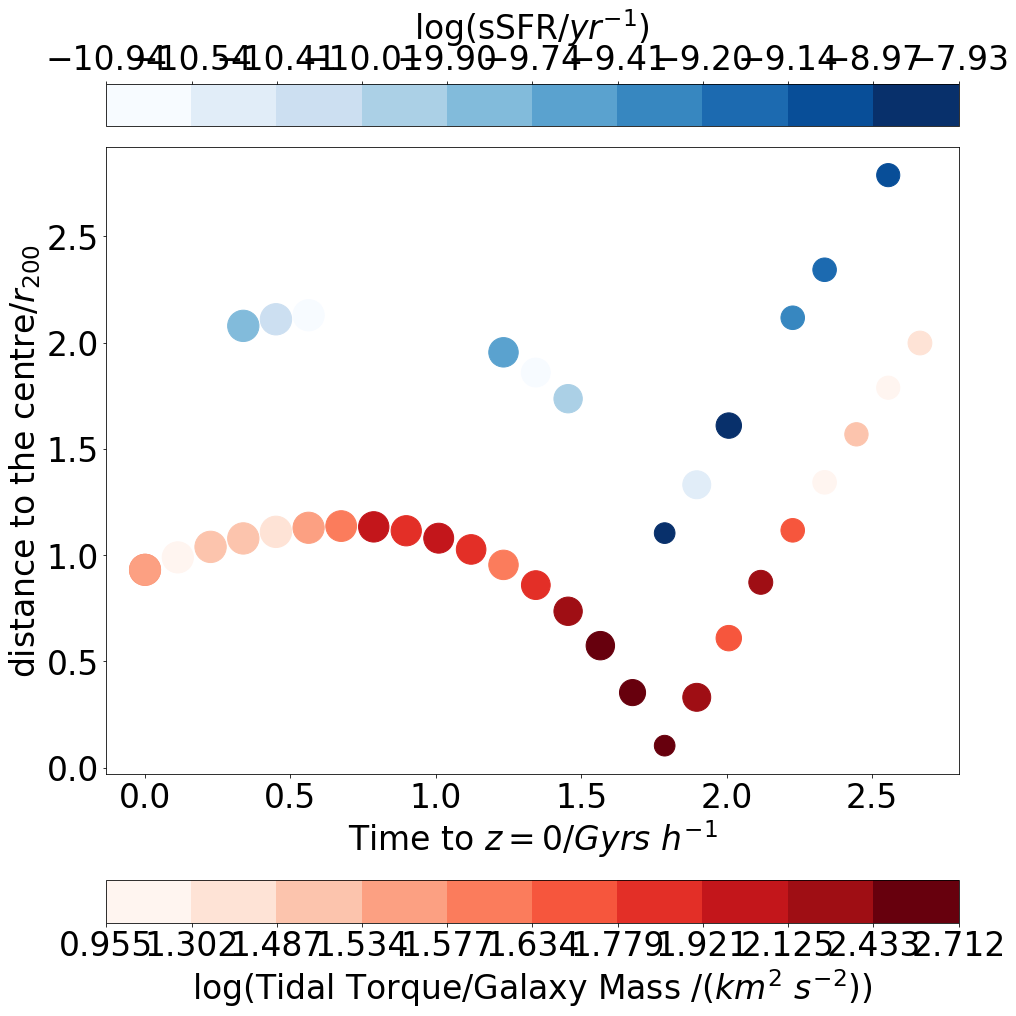

In [41]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4341, dist_4341, s=np.abs(cosC_4341)*1e3, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4341, dist_4341+1., s=np.abs(cosC_4341)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

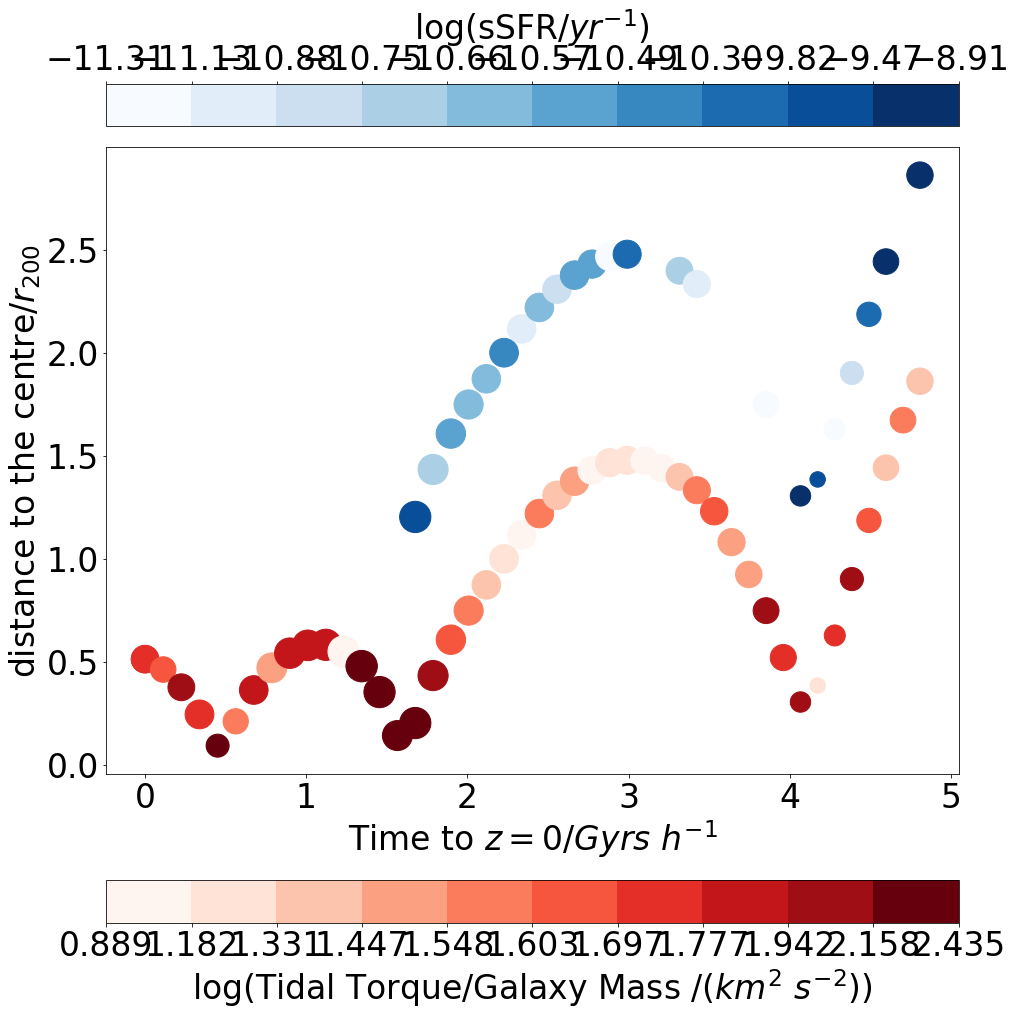

In [42]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4343, dist_4343, s=np.abs(cosC_4343)*1e3, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4343, dist_4343+1., s=np.abs(cosC_4343)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

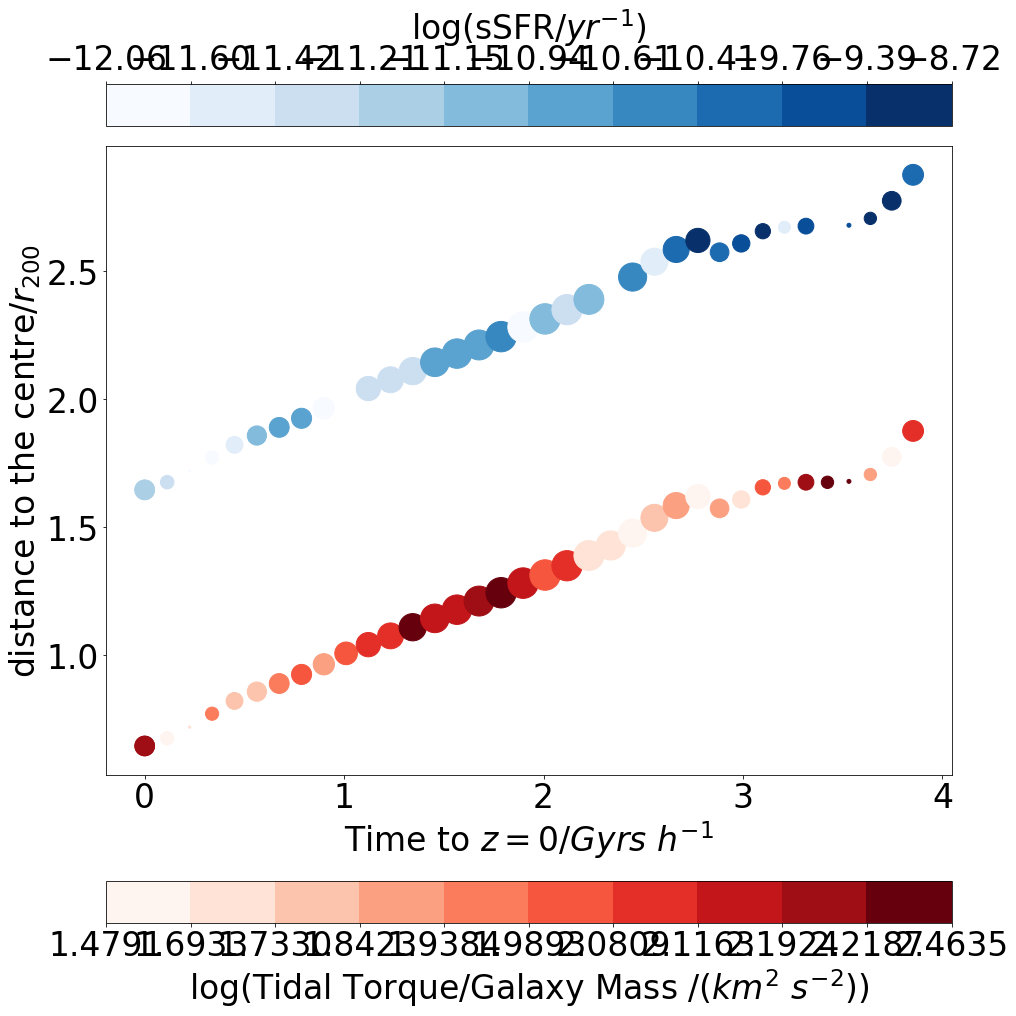

In [43]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4470, dist_4470, s=np.abs(cosC_4470)*1e3, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4470, dist_4470+1., s=np.abs(cosC_4470)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

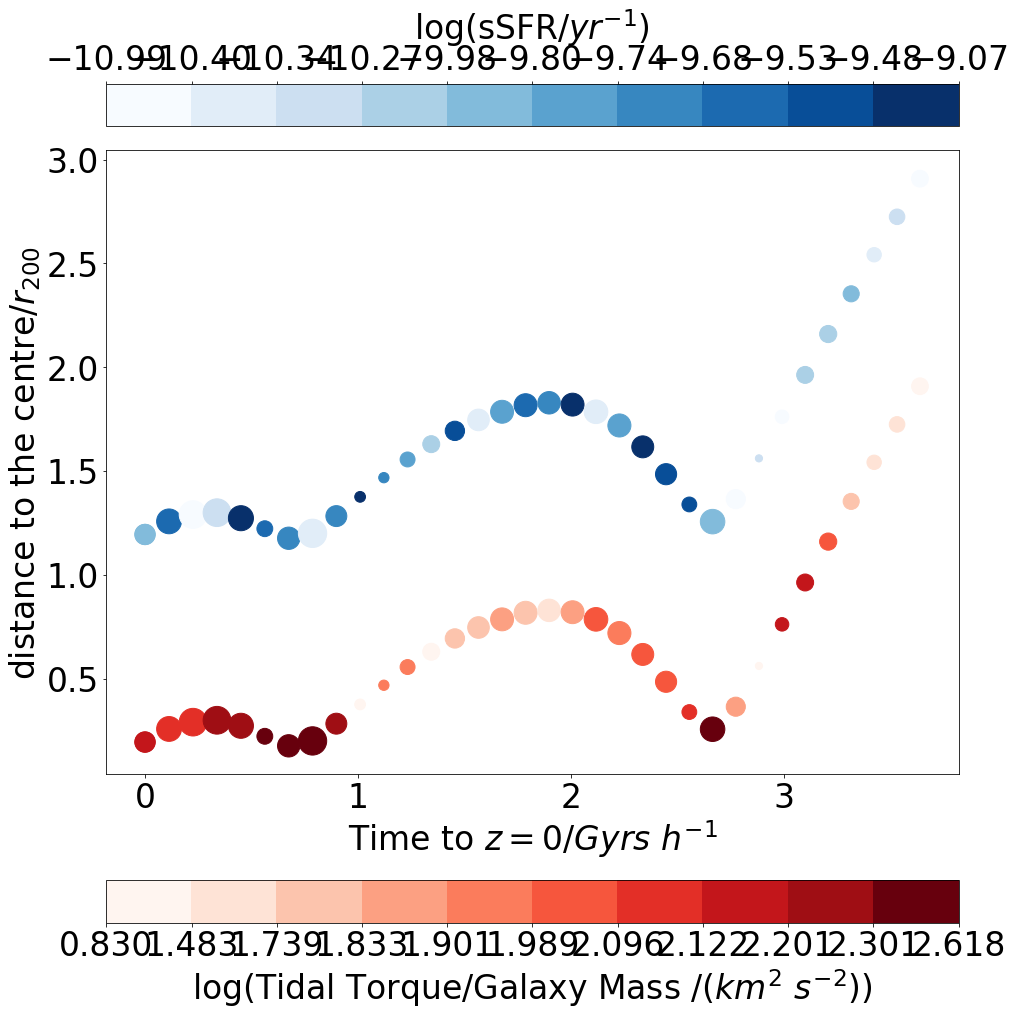

In [44]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4471, dist_4471, s=np.abs(cosC_4471)*1e3, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4471, dist_4471+1., s=np.abs(cosC_4471)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

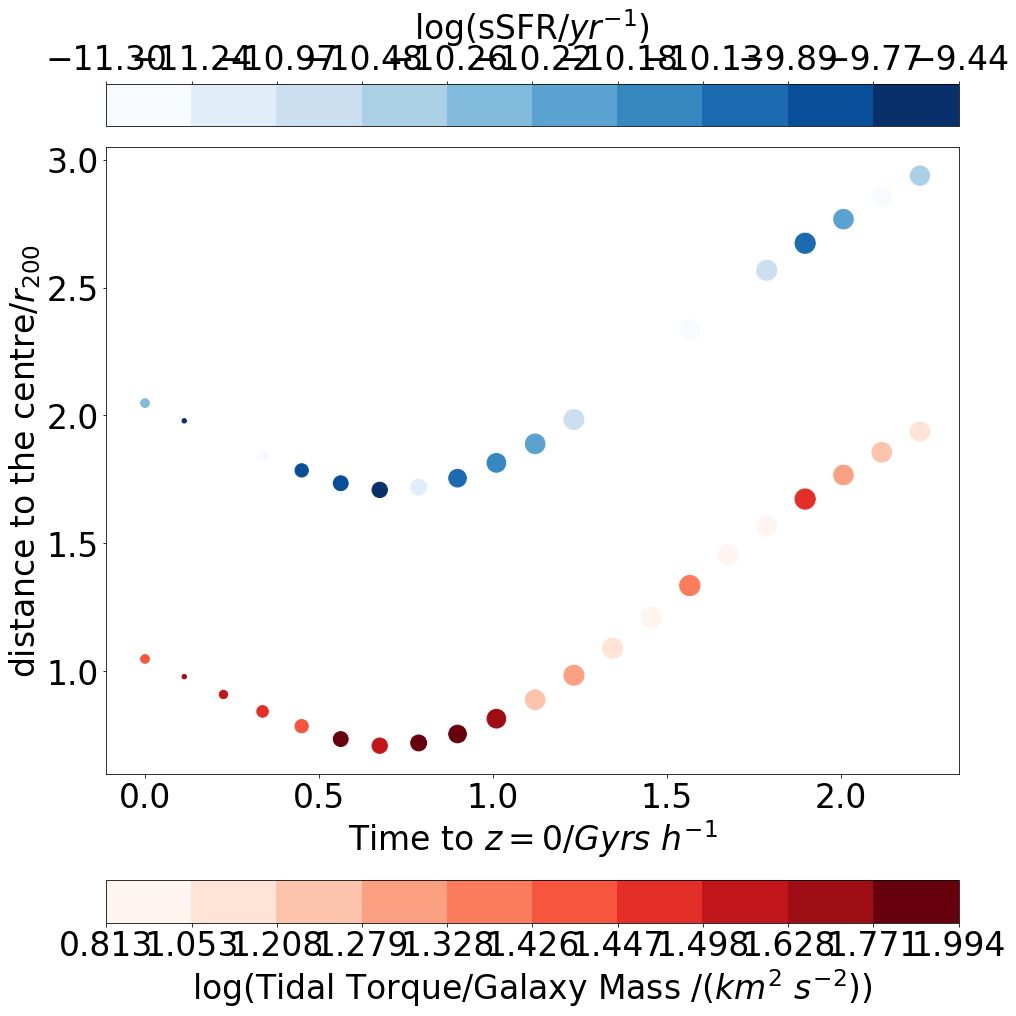

In [45]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4473, dist_4473, s=np.abs(cosC_4473)*1e3, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4473, dist_4473+1., s=np.abs(cosC_4473)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

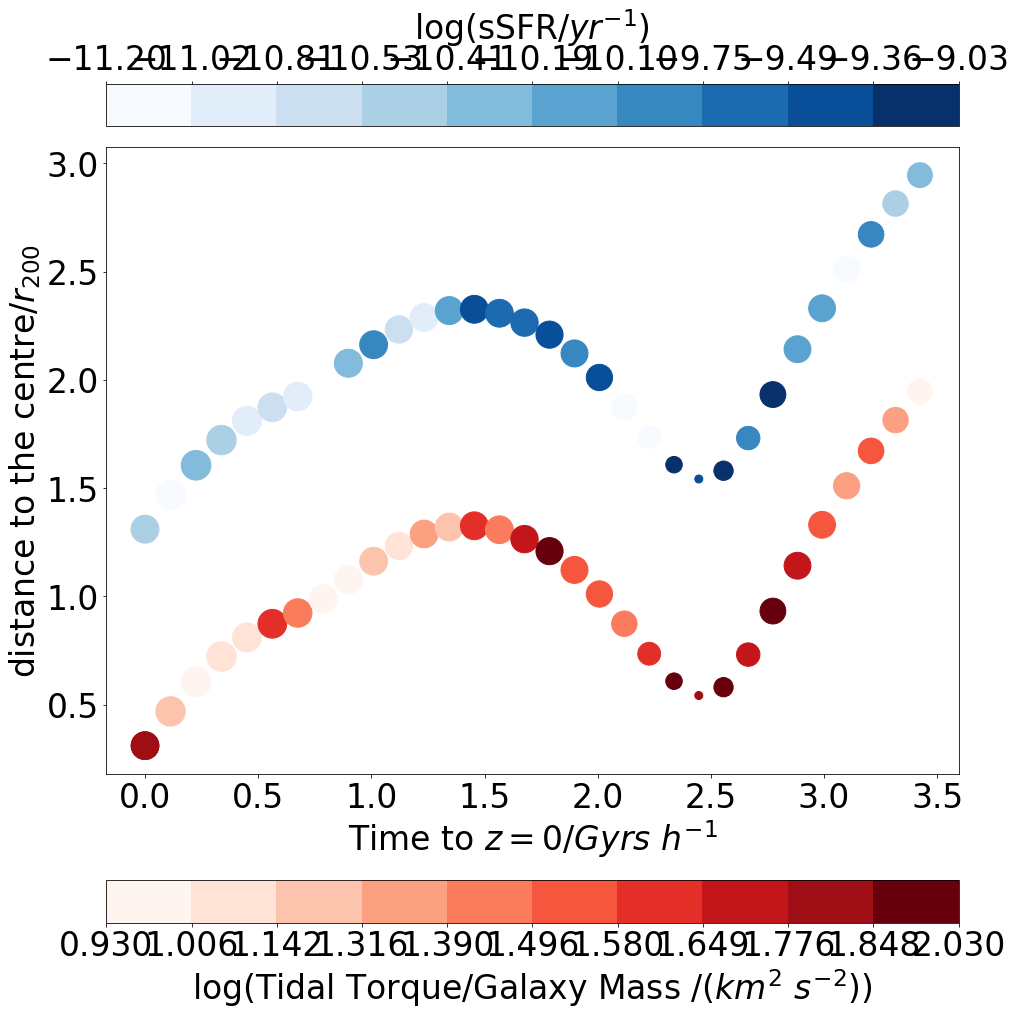

In [46]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4474, dist_4474, s=np.abs(cosC_4474)*1e3, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4474, dist_4474+1., s=np.abs(cosC_4474)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

In [47]:
# and the other angle

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

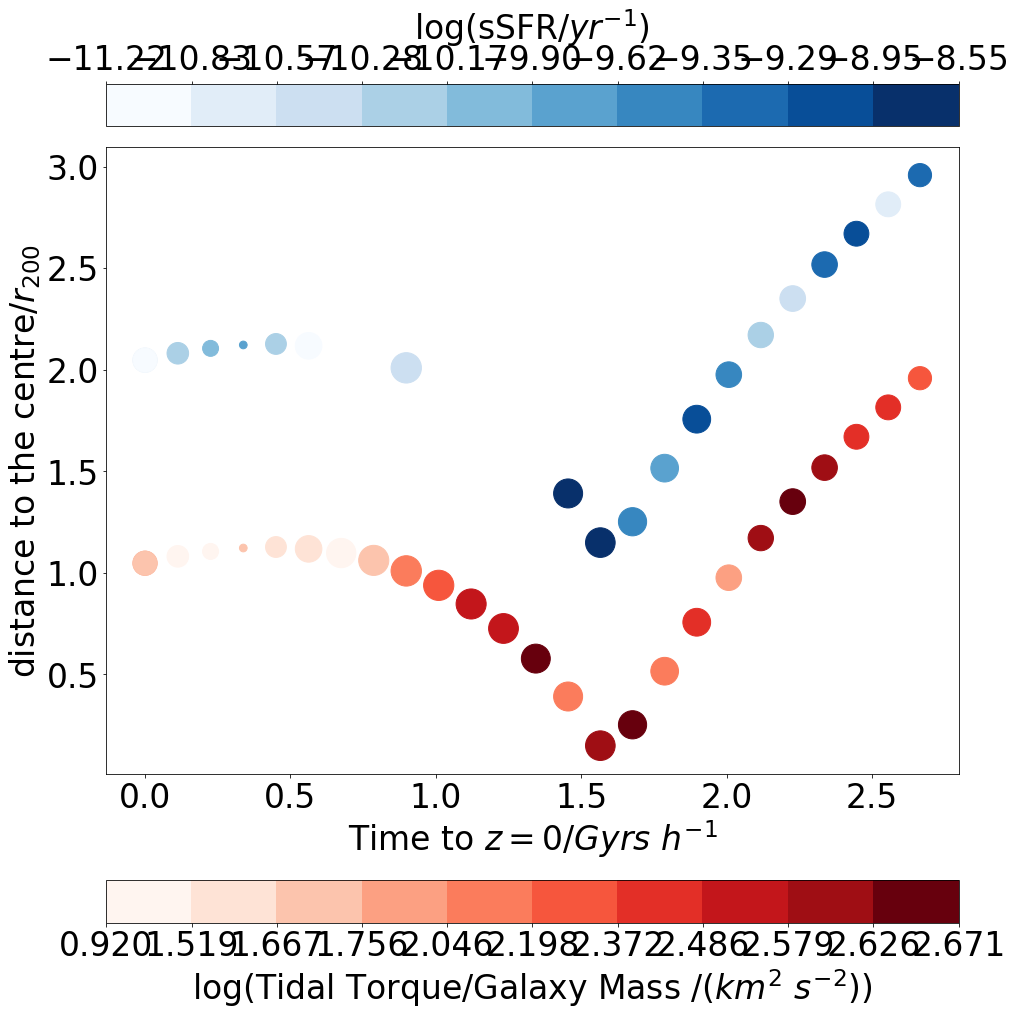

In [48]:

pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4338, dist_4338, s=np.abs(cosV_4338)*1e3, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4338, dist_4338+1., s=np.abs(cosV_4338)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

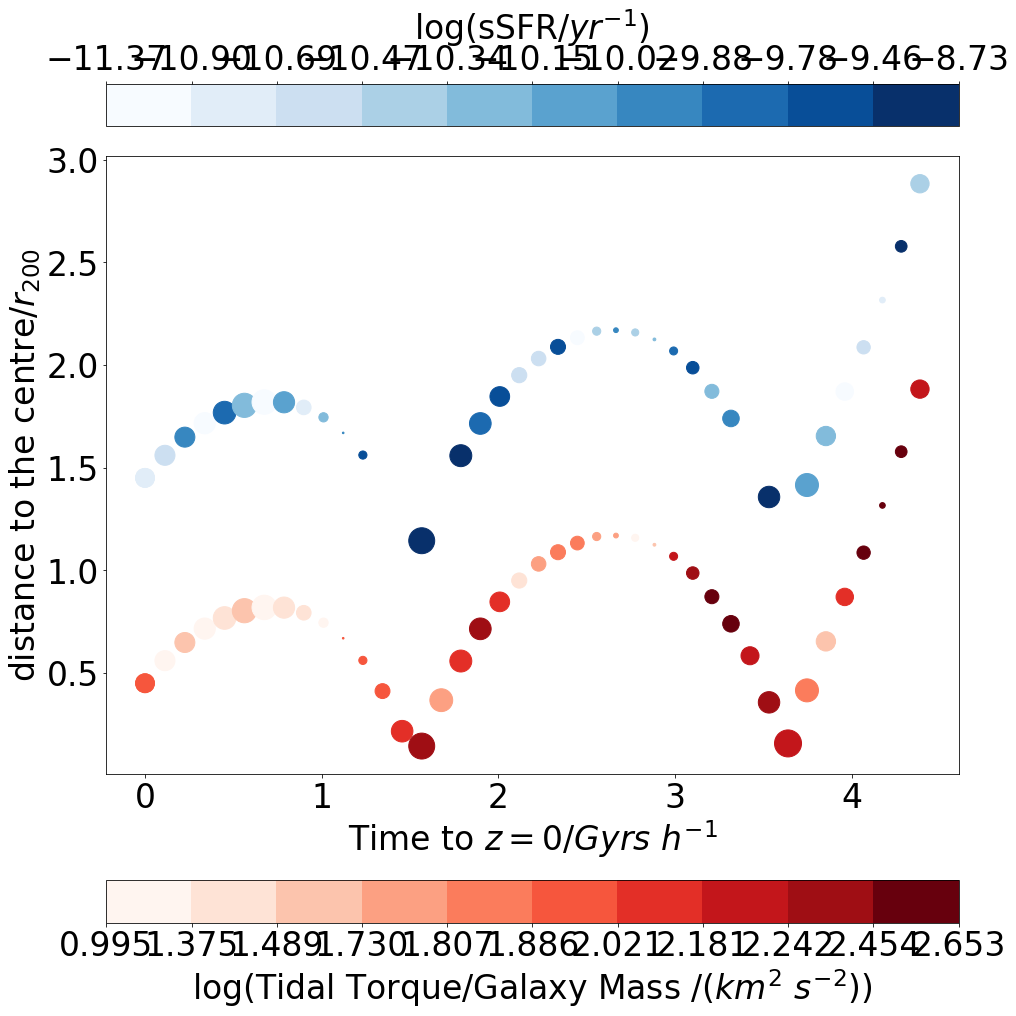

In [49]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4339, dist_4339, s=np.abs(cosV_4339)*1e3, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4339, dist_4339+1., s=np.abs(cosV_4339)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

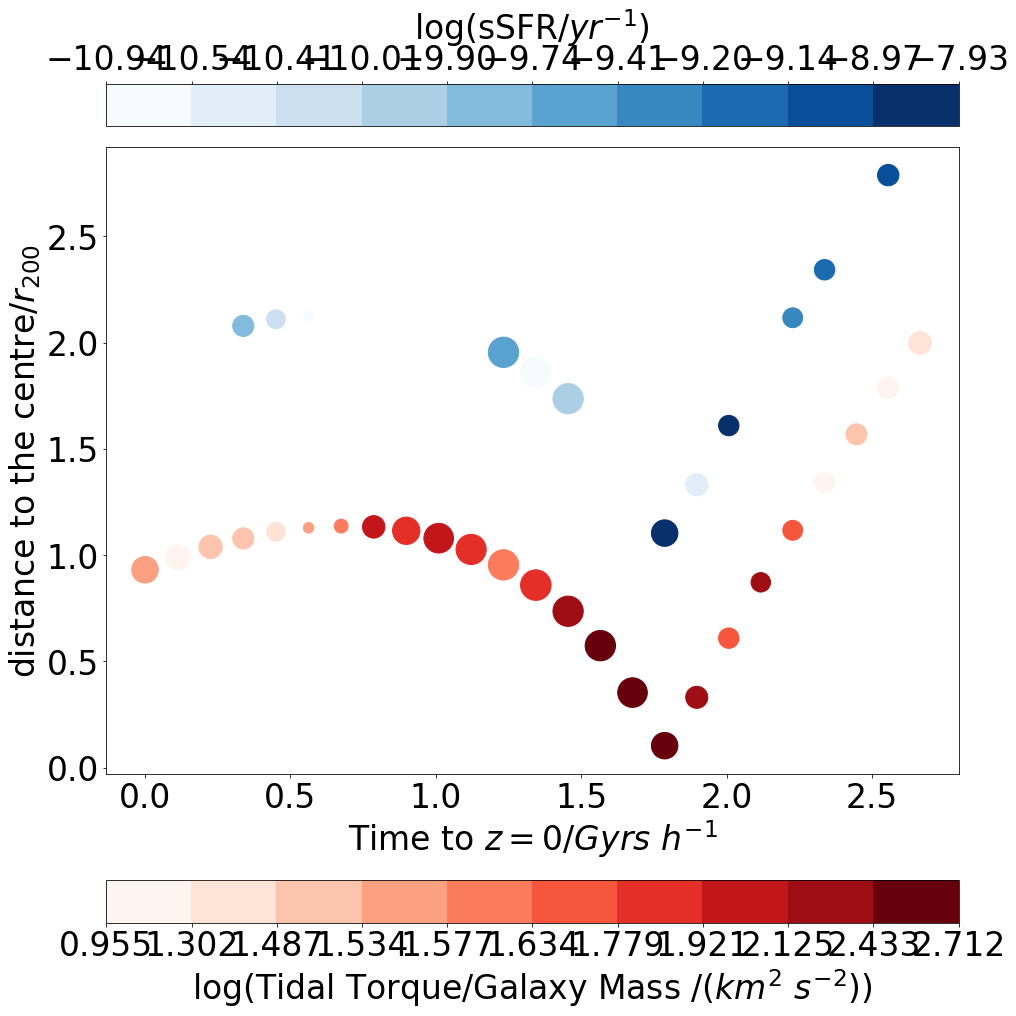

In [50]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4341, dist_4341, s=np.abs(cosV_4341)*1e3, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4341, dist_4341+1., s=np.abs(cosV_4341)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

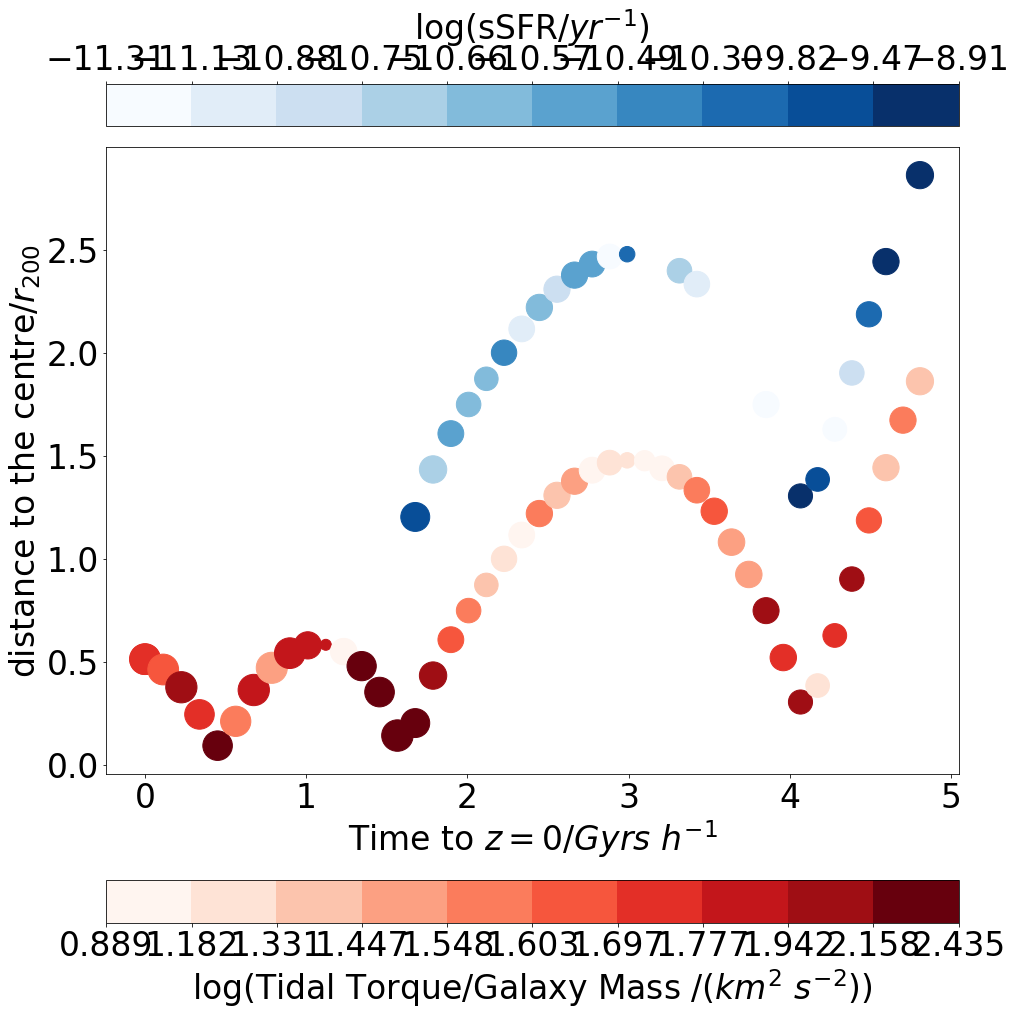

In [51]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4343, dist_4343, s=np.abs(cosV_4343)*1e3, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4343, dist_4343+1., s=np.abs(cosV_4343)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

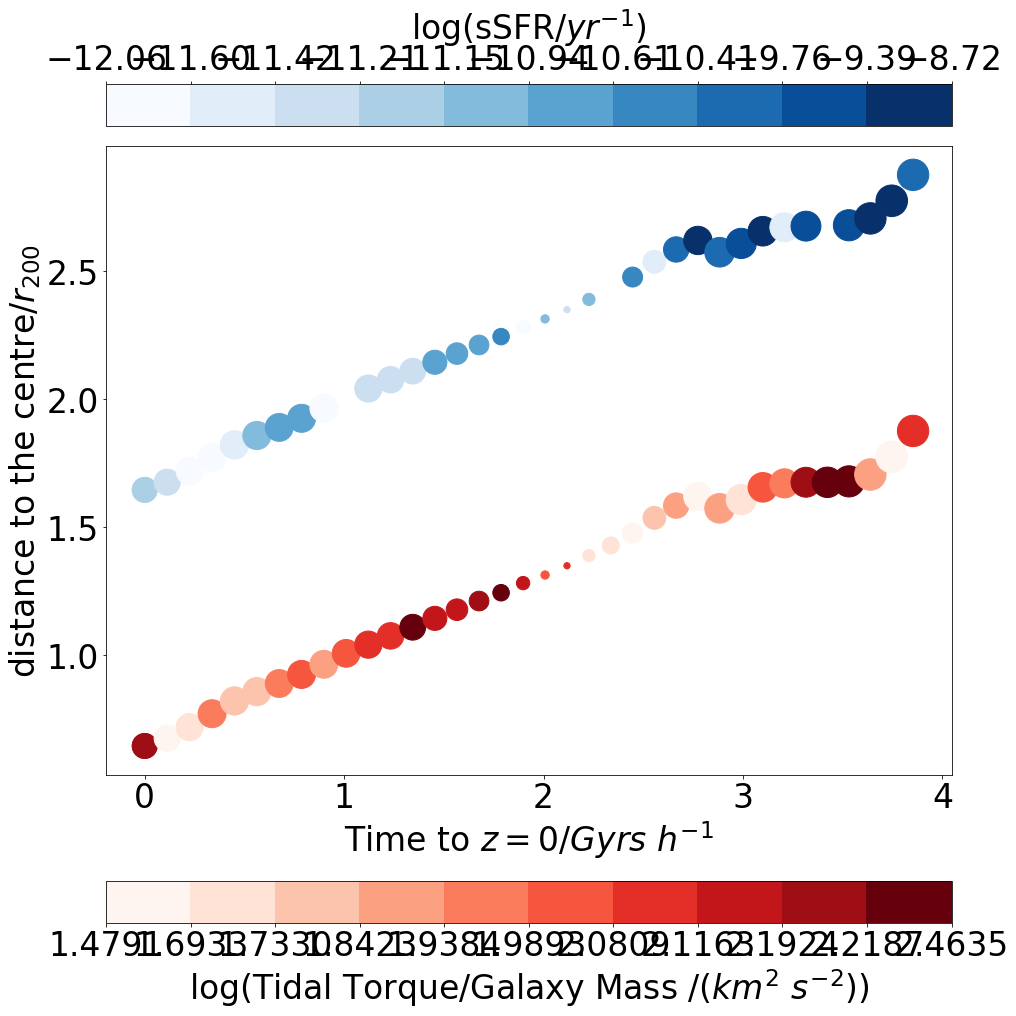

In [52]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4470, dist_4470, s=np.abs(cosV_4470)*1e3, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4470, dist_4470+1., s=np.abs(cosV_4470)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

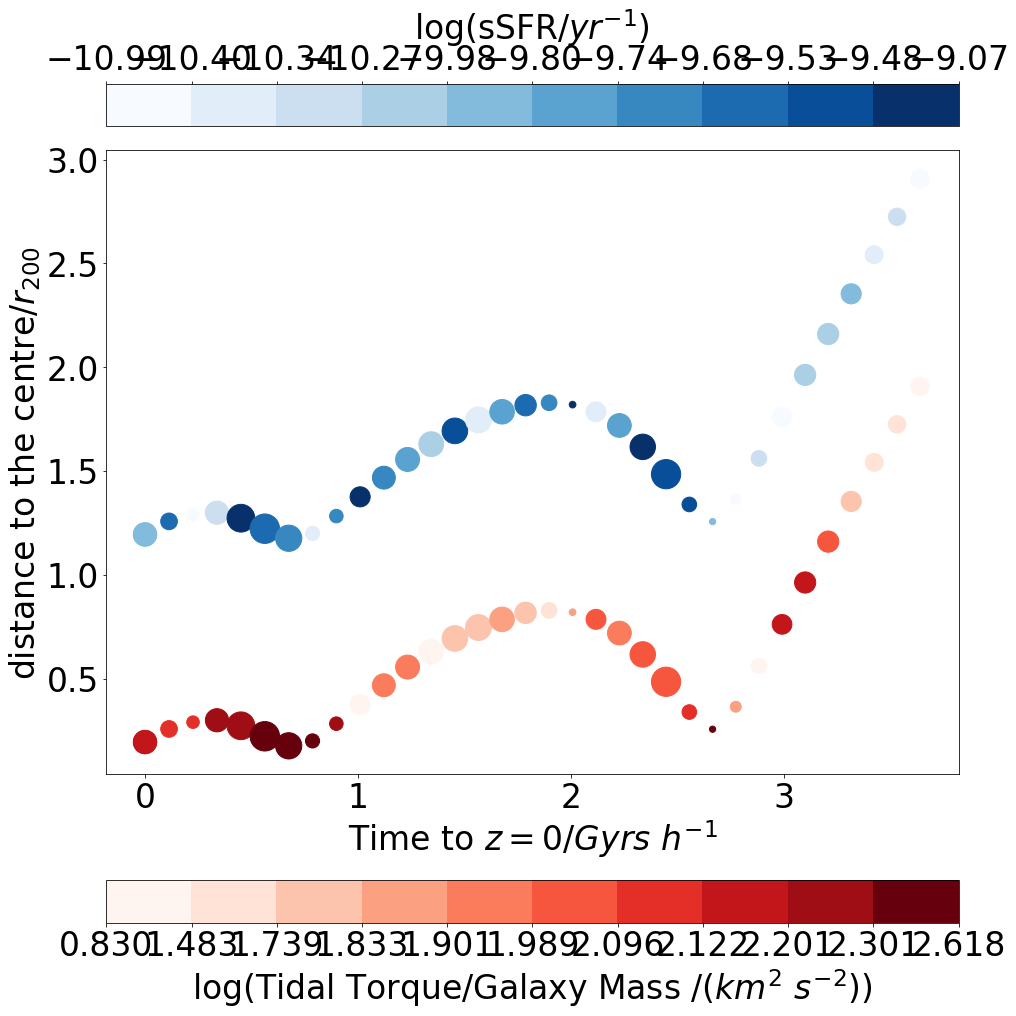

In [53]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4471, dist_4471, s=np.abs(cosV_4471)*1e3, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4471, dist_4471+1., s=np.abs(cosV_4471)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

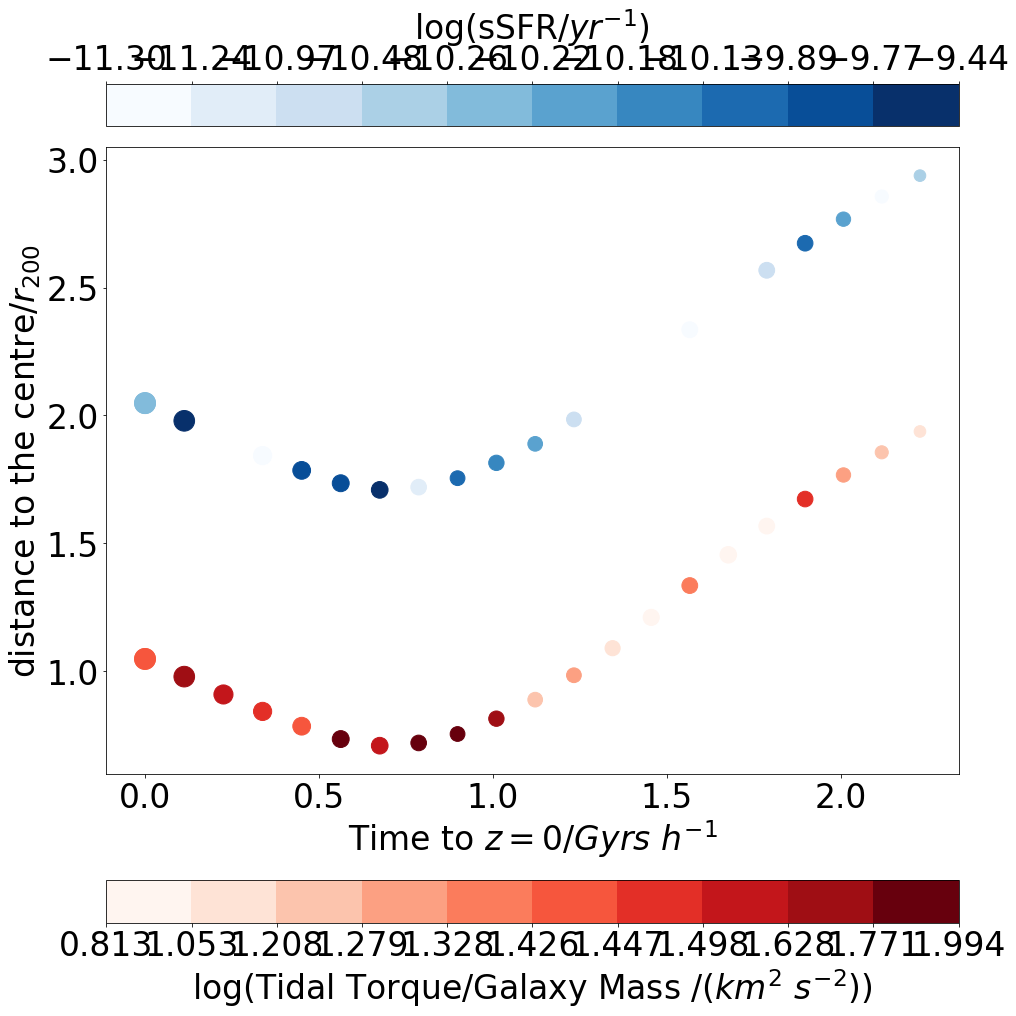

In [54]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4473, dist_4473, s=np.abs(cosV_4473)*1e3, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4473, dist_4473+1., s=np.abs(cosV_4473)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

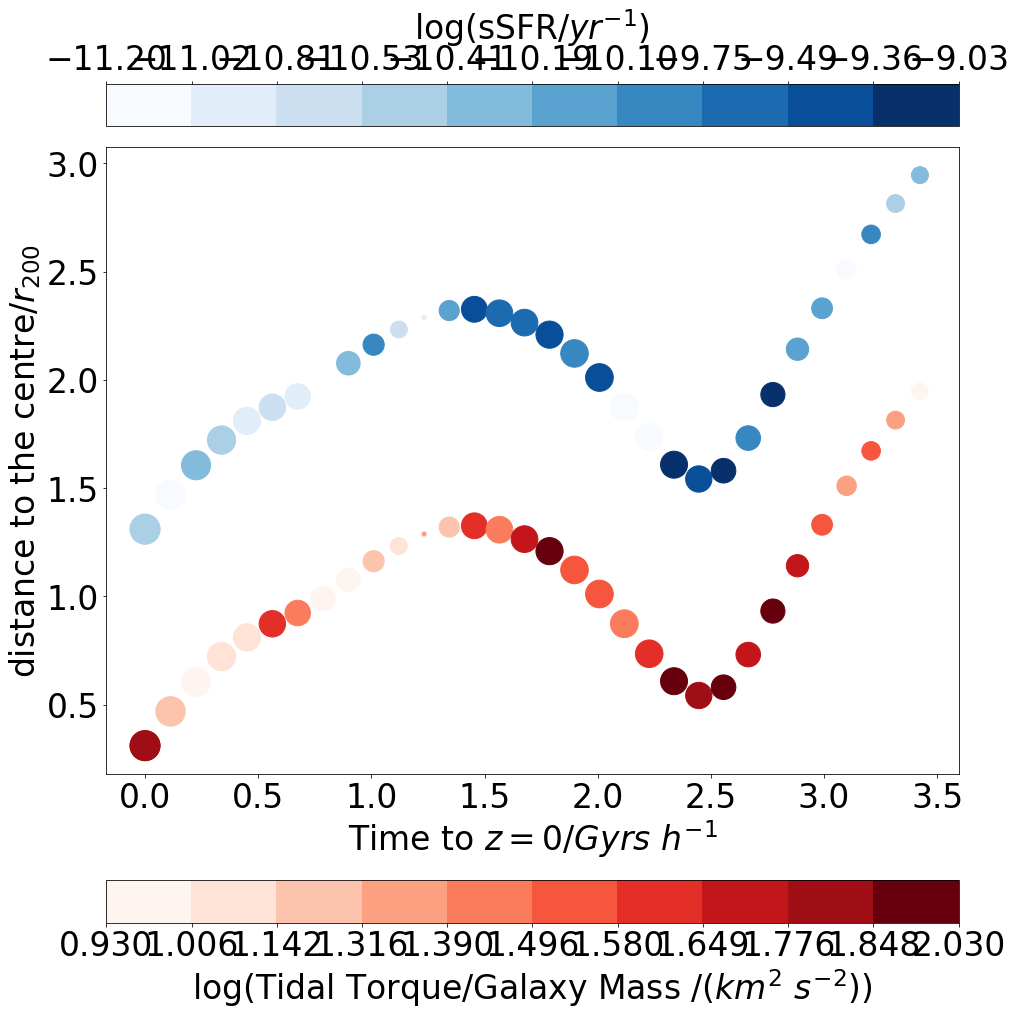

In [55]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4474, dist_4474, s=np.abs(cosV_4474)*1e3, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4474, dist_4474+1., s=np.abs(cosV_4474)*1e3, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('distance to the centre/$r_{200}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

In [56]:
# so, we need also ram pressure, ok then
def smoothRP(RP, n):
    I = np.arange(RP.size)
    
    newRP = np.zeros(I.size)
    for i in I:
        itemp = np.arange(i-n, i+n+1)
        itemp = itemp[np.where((itemp>=0) & (itemp<I[-1]))]
        tRP = RP[itemp]
        
        tRP = tRP[np.where((np.isnan(tRP)==False) & (np.isinf(tRP)==False))]
   
        newRP[i] = np.mean(tRP)
        
    return newRP

In [57]:
n = 3

newRP_4338 = smoothRP(RP_4338, n)
newRP_4339 = smoothRP(RP_4339, n)
newRP_4341 = smoothRP(RP_4341, n)
newRP_4343 = smoothRP(RP_4343, n)

newRP_4470 = smoothRP(RP_4470, n)
newRP_4471 = smoothRP(RP_4471, n)
newRP_4473 = smoothRP(RP_4473, n)
newRP_4474 = smoothRP(RP_4474, n)

Text(0.5, 0, '$\\cos \\phi_v$')

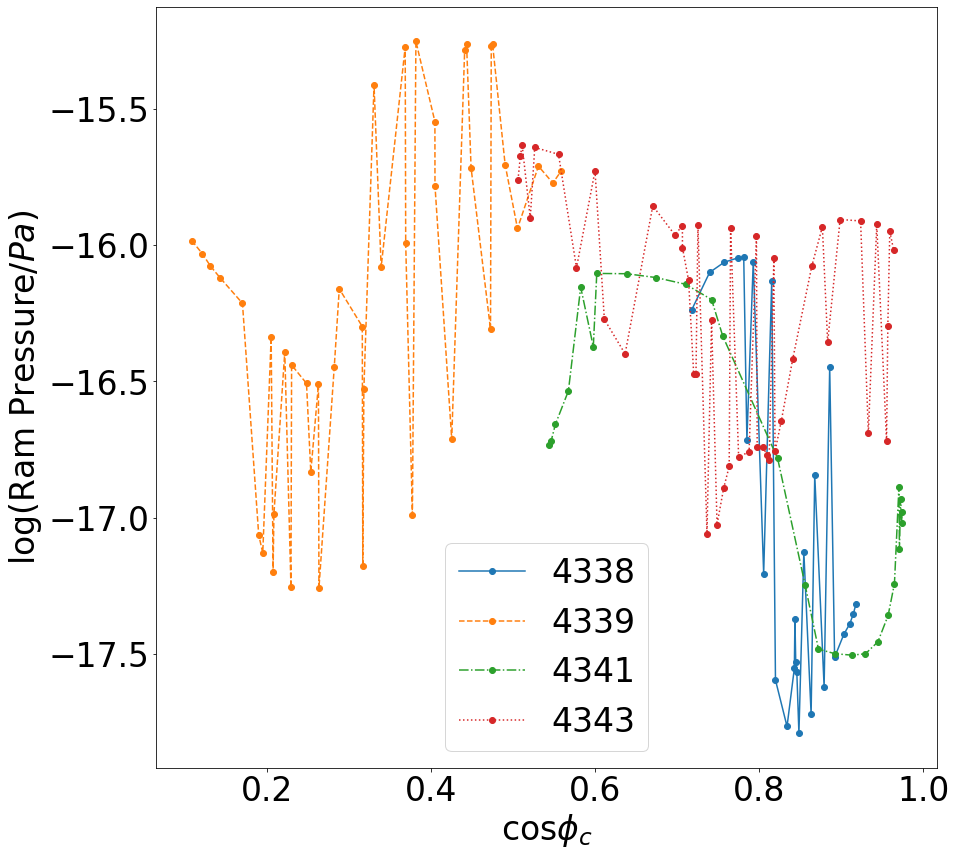

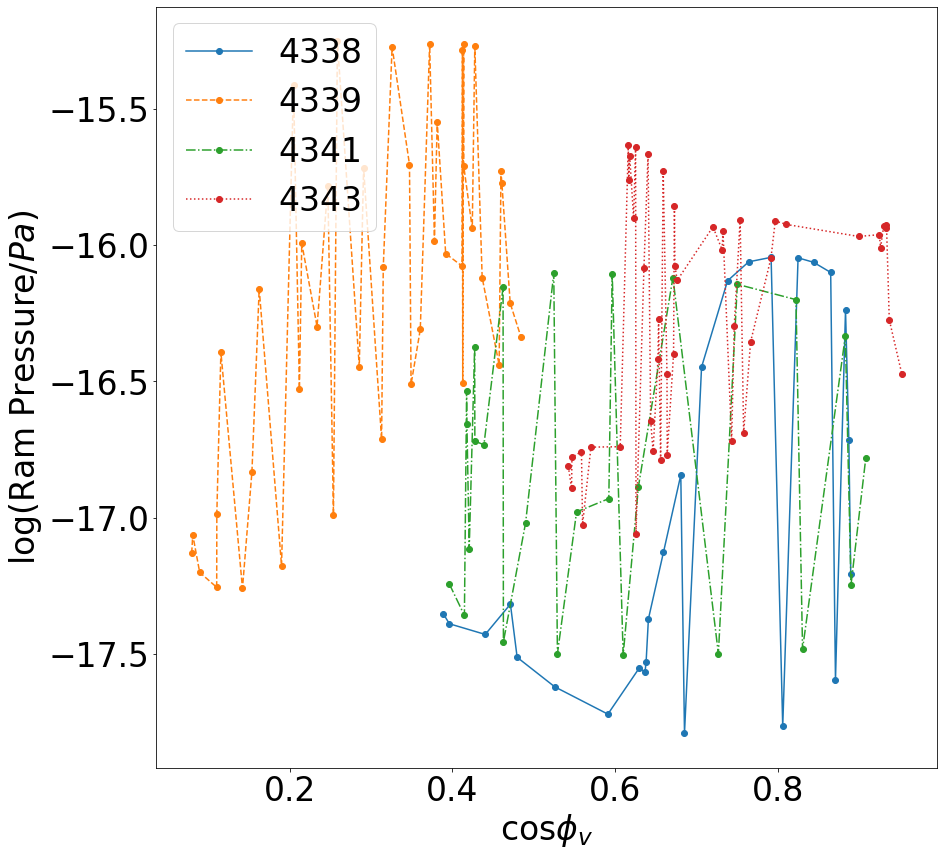

In [58]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(ncosC_4338)
ii_4339 = np.argsort(ncosC_4339)
ii_4341 = np.argsort(ncosC_4341)
ii_4343 = np.argsort(ncosC_4343)

pl.plot(ncosC_4338[ii_4338], np.log10(newRP_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(ncosC_4339[ii_4339], np.log10(newRP_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(ncosC_4341[ii_4341], np.log10(newRP_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(ncosC_4343[ii_4343], np.log10(newRP_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')
pl.ylabel('$\log($Ram Pressure$/Pa)$')
pl.xlabel('$\cos \phi_c$')


pl.figure(figsize=(14,14))

ii_4338 = np.argsort(ncosV_4338)
ii_4339 = np.argsort(ncosV_4339)
ii_4341 = np.argsort(ncosV_4341)
ii_4343 = np.argsort(ncosV_4343)

pl.plot(ncosV_4338[ii_4338], np.log10(newRP_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(ncosV_4339[ii_4339], np.log10(newRP_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(ncosV_4341[ii_4341], np.log10(newRP_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(ncosV_4343[ii_4343], np.log10(newRP_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')
pl.ylabel('$\log($Ram Pressure$/Pa)$')
pl.xlabel('$\cos \phi_v$')

Text(0.5, 0, '$\\cos \\phi_v$')

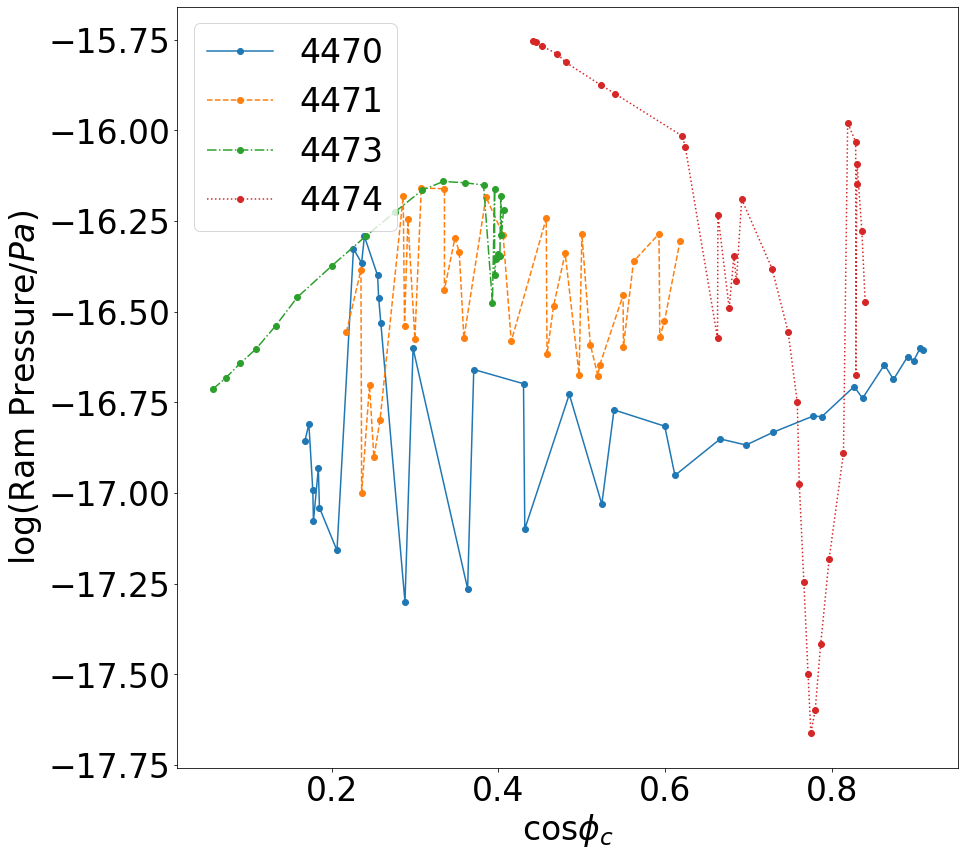

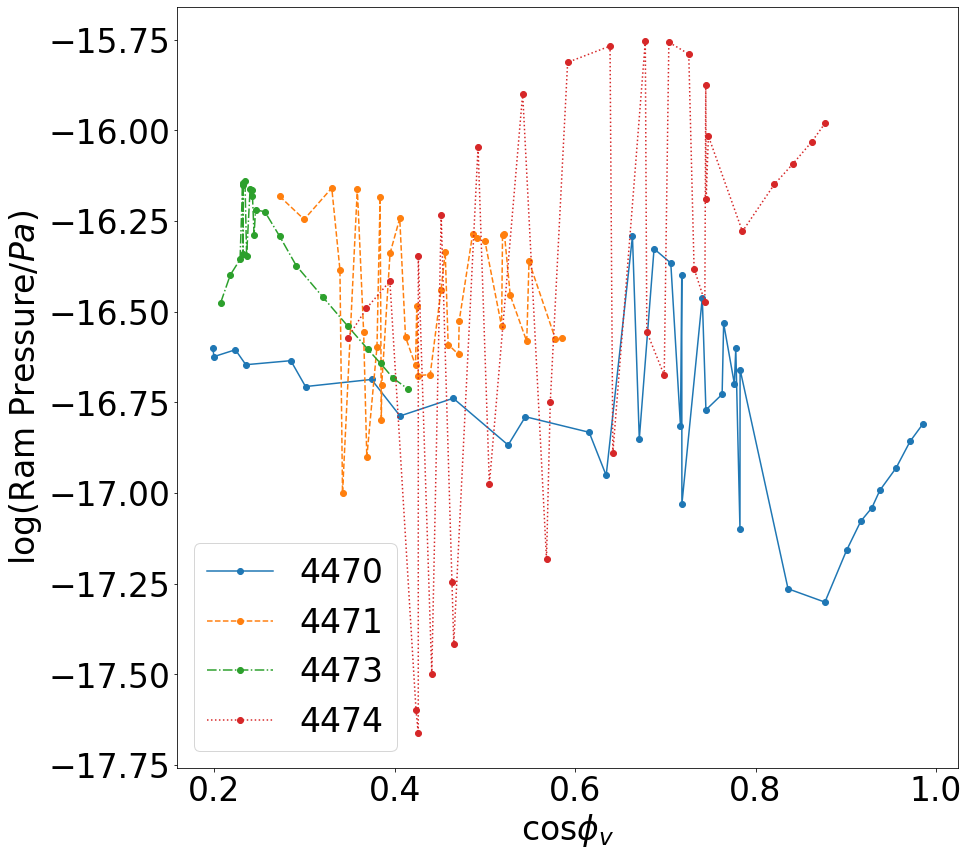

In [59]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(ncosC_4470)
ii_4471 = np.argsort(ncosC_4471)
ii_4473 = np.argsort(ncosC_4473)
ii_4474 = np.argsort(ncosC_4474)

pl.plot(ncosC_4470[ii_4470], np.log10(newRP_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(ncosC_4471[ii_4471], np.log10(newRP_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(ncosC_4473[ii_4473], np.log10(newRP_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(ncosC_4474[ii_4474], np.log10(newRP_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')
pl.ylabel('$\log($Ram Pressure$/Pa)$')
pl.xlabel('$\cos \phi_c$')

pl.figure(figsize=(14,14))

ii_4470 = np.argsort(ncosV_4470)
ii_4471 = np.argsort(ncosV_4471)
ii_4473 = np.argsort(ncosV_4473)
ii_4474 = np.argsort(ncosV_4474)

pl.plot(ncosV_4470[ii_4470], np.log10(newRP_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(ncosV_4471[ii_4471], np.log10(newRP_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(ncosV_4473[ii_4473], np.log10(newRP_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(ncosV_4474[ii_4474], np.log10(newRP_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')
pl.ylabel('$\log($Ram Pressure$/Pa)$')
pl.xlabel('$\cos \phi_v$')

In [60]:
# now i should select just the nearest (and smooth the thing?, maybe)
distLim = 1.

iC_4338 = np.where(dist_4338<distLim)
cosCC_4338, TStC_4338 = np.abs(ncosC_4338[iC_4338]), nTT_4338[iC_4338]
iC_4339 = np.where(dist_4339<distLim)
cosCC_4339, TStC_4339 = np.abs(ncosC_4339[iC_4339]), nTT_4339[iC_4339]
iC_4341 = np.where(dist_4341<distLim)
cosCC_4341, TStC_4341 = np.abs(ncosC_4341[iC_4341]), nTT_4341[iC_4341]
iC_4343 = np.where(dist_4343<distLim)
cosCC_4343, TStC_4343 = np.abs(ncosC_4343[iC_4343]), nTT_4343[iC_4343]

iC_4470 = np.where(dist_4470<distLim)
cosCC_4470, TStC_4470 = np.abs(ncosC_4470[iC_4470]), nTT_4470[iC_4470]
iC_4471 = np.where(dist_4471<distLim)
cosCC_4471, TStC_4471 = np.abs(ncosC_4471[iC_4471]), nTT_4471[iC_4471]
iC_4473 = np.where(dist_4473<distLim)
cosCC_4473, TStC_4473 = np.abs(ncosC_4473[iC_4473]), nTT_4473[iC_4473]
iC_4474 = np.where(dist_4474<distLim)
cosCC_4474, TStC_4474 = np.abs(ncosC_4474[iC_4474]), nTT_4474[iC_4474]

Text(0.5, 0, '$\\cos \\phi_c$')

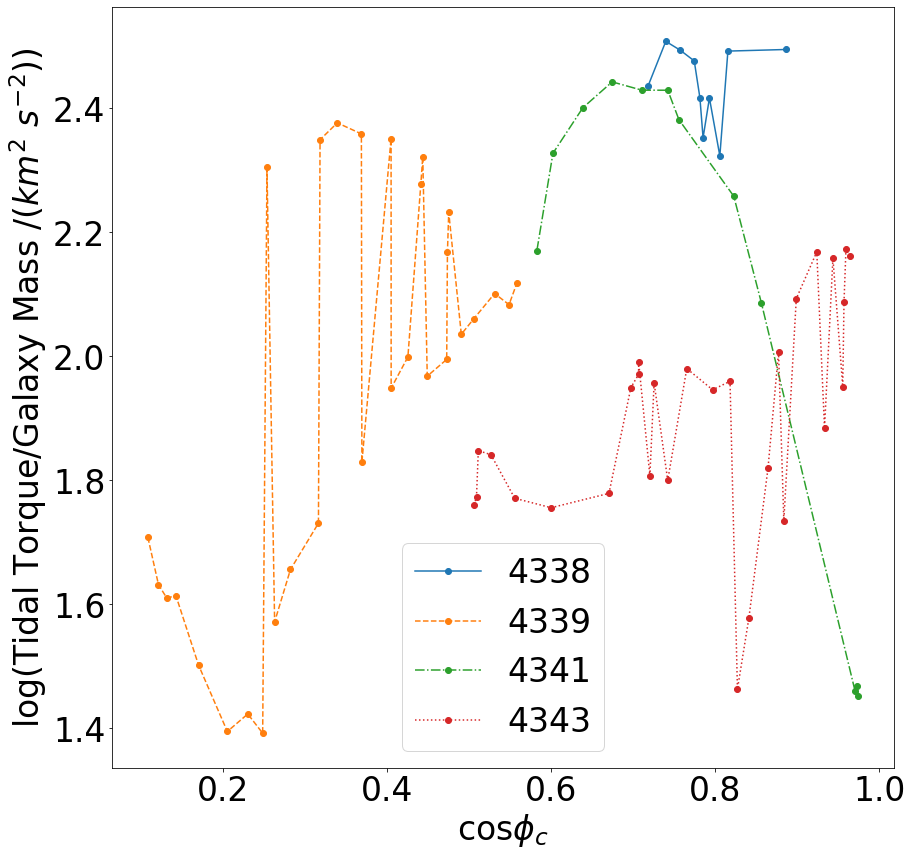

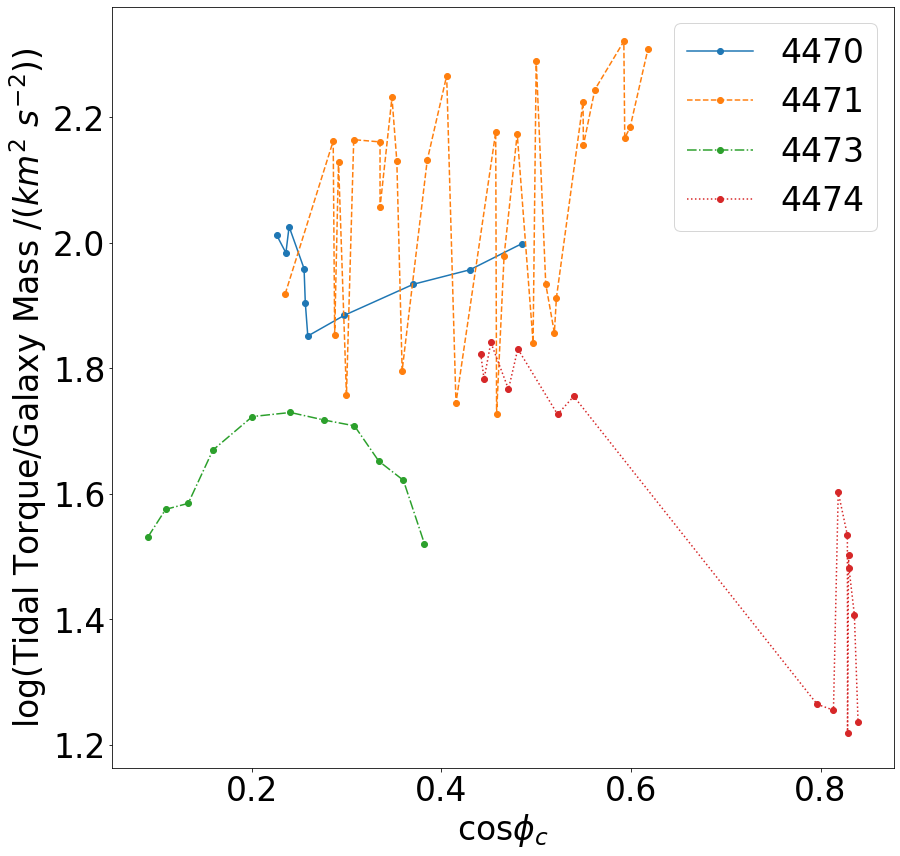

In [61]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(cosCC_4338)
ii_4339 = np.argsort(cosCC_4339)
ii_4341 = np.argsort(cosCC_4341)
ii_4343 = np.argsort(cosCC_4343)

pl.plot(cosCC_4338[ii_4338], np.log10(TStC_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(cosCC_4339[ii_4339], np.log10(TStC_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(cosCC_4341[ii_4341], np.log10(TStC_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(cosCC_4343[ii_4343], np.log10(TStC_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')
pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('$\cos \phi_c$')


pl.figure(figsize=(14,14))

ii_4470 = np.argsort(cosCC_4470)
ii_4471 = np.argsort(cosCC_4471)
ii_4473 = np.argsort(cosCC_4473)
ii_4474 = np.argsort(cosCC_4474)

pl.plot(cosCC_4470[ii_4470], np.log10(TStC_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(cosCC_4471[ii_4471], np.log10(TStC_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(cosCC_4473[ii_4473], np.log10(TStC_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(cosCC_4474[ii_4474], np.log10(TStC_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')
pl.ylabel('log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)')
pl.xlabel('$\cos \phi_c$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

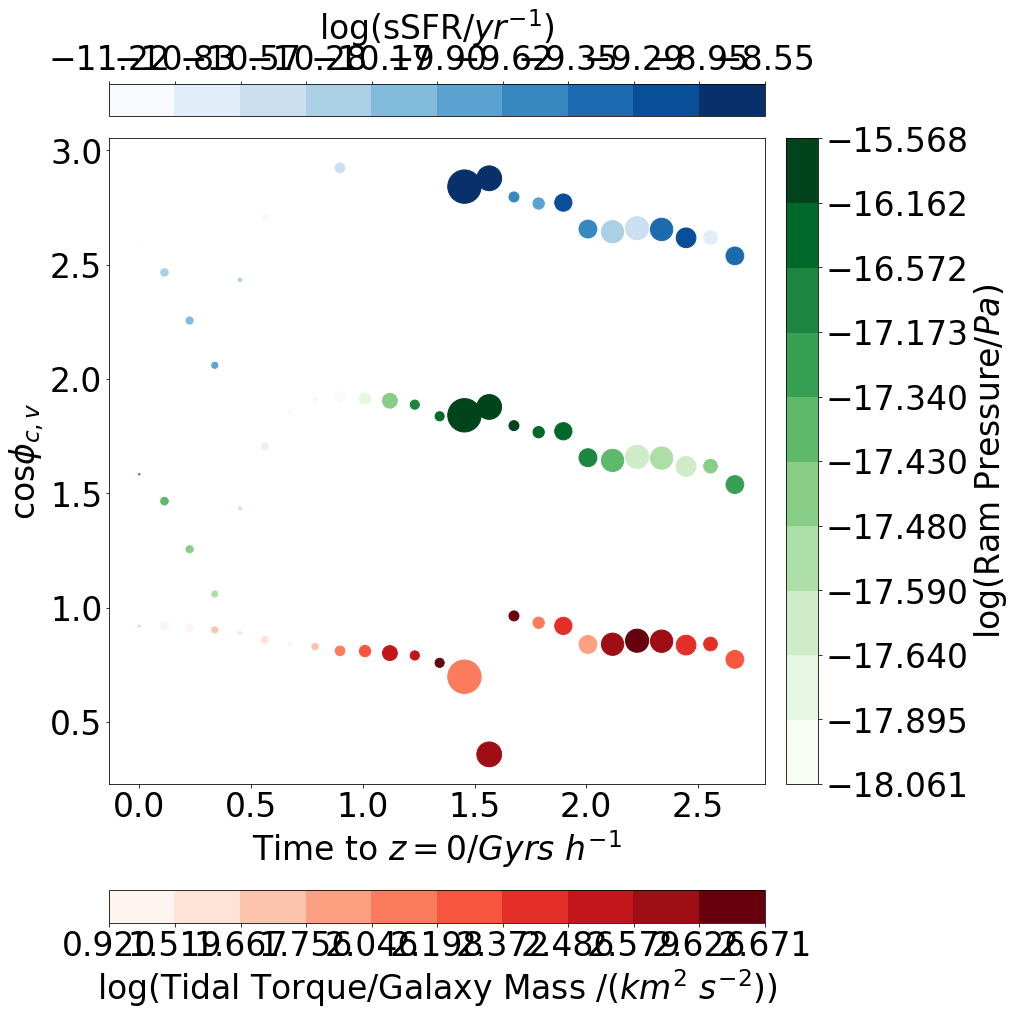

In [62]:
# ok, last attemp, this time with the angles


pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4338, np.abs(cosC_4338), s=Gas_4338/5e5, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4338), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4338, np.abs(cosV_4338)+1., s=Gas_4338/5e5, c=np.log10(RP_4338), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4338, np.abs(cosV_4338)+2., s=Gas_4338/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

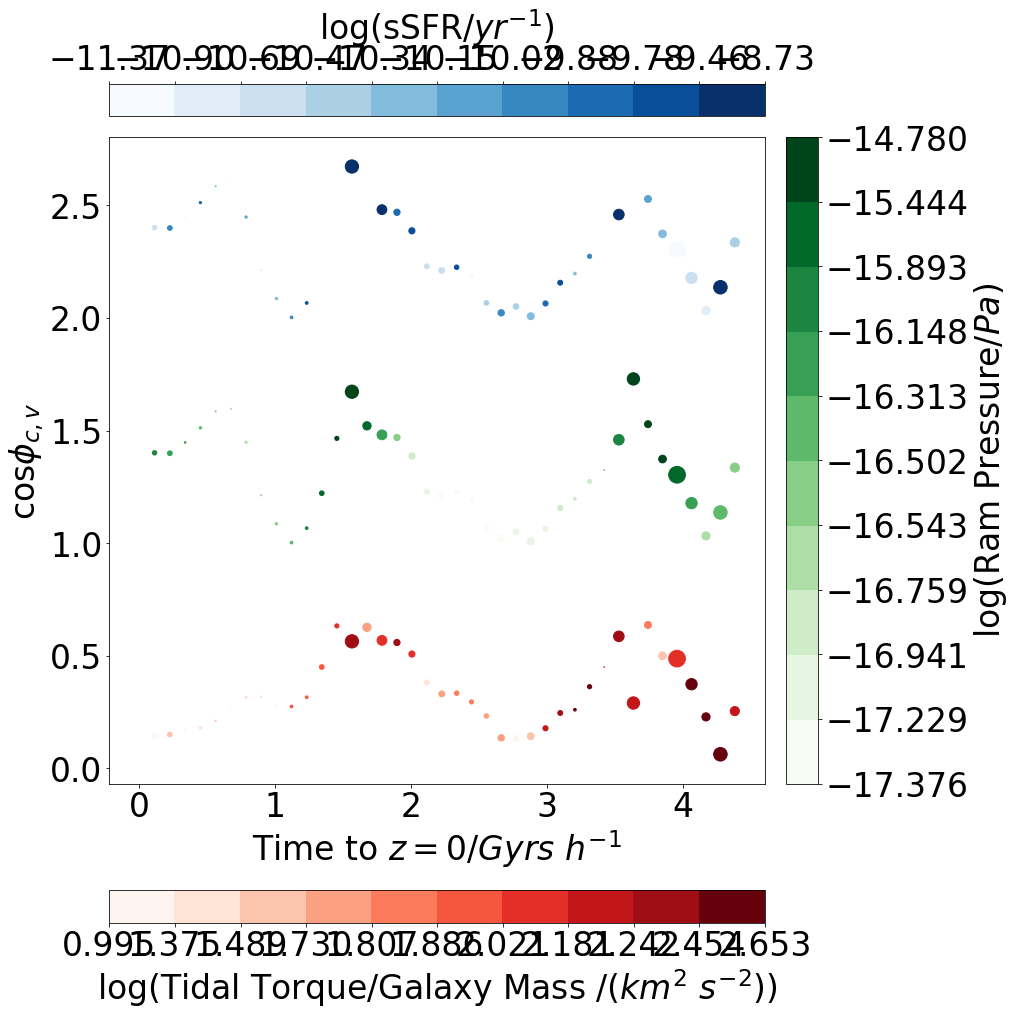

In [63]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4339, np.abs(cosC_4339), s=Gas_4339/5e5, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4339), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4339, np.abs(cosV_4339)+1., s=Gas_4339/5e5, c=np.log10(RP_4339), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4339, np.abs(cosV_4339)+2., s=Gas_4339/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

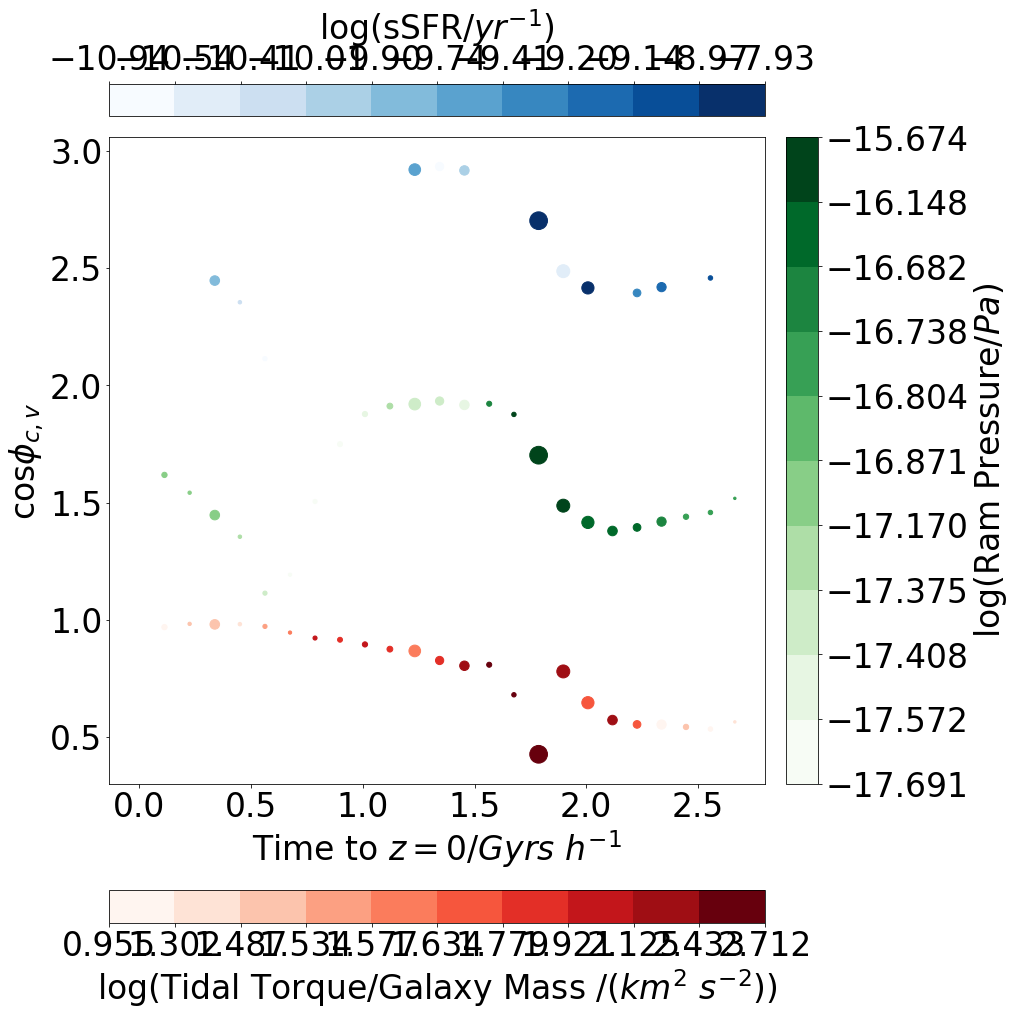

In [64]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4341, np.abs(cosC_4341), s=Gas_4341/5e5, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4341), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4341, np.abs(cosV_4341)+1., s=Gas_4341/5e5, c=np.log10(RP_4341), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4341, np.abs(cosV_4341)+2., s=Gas_4341/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

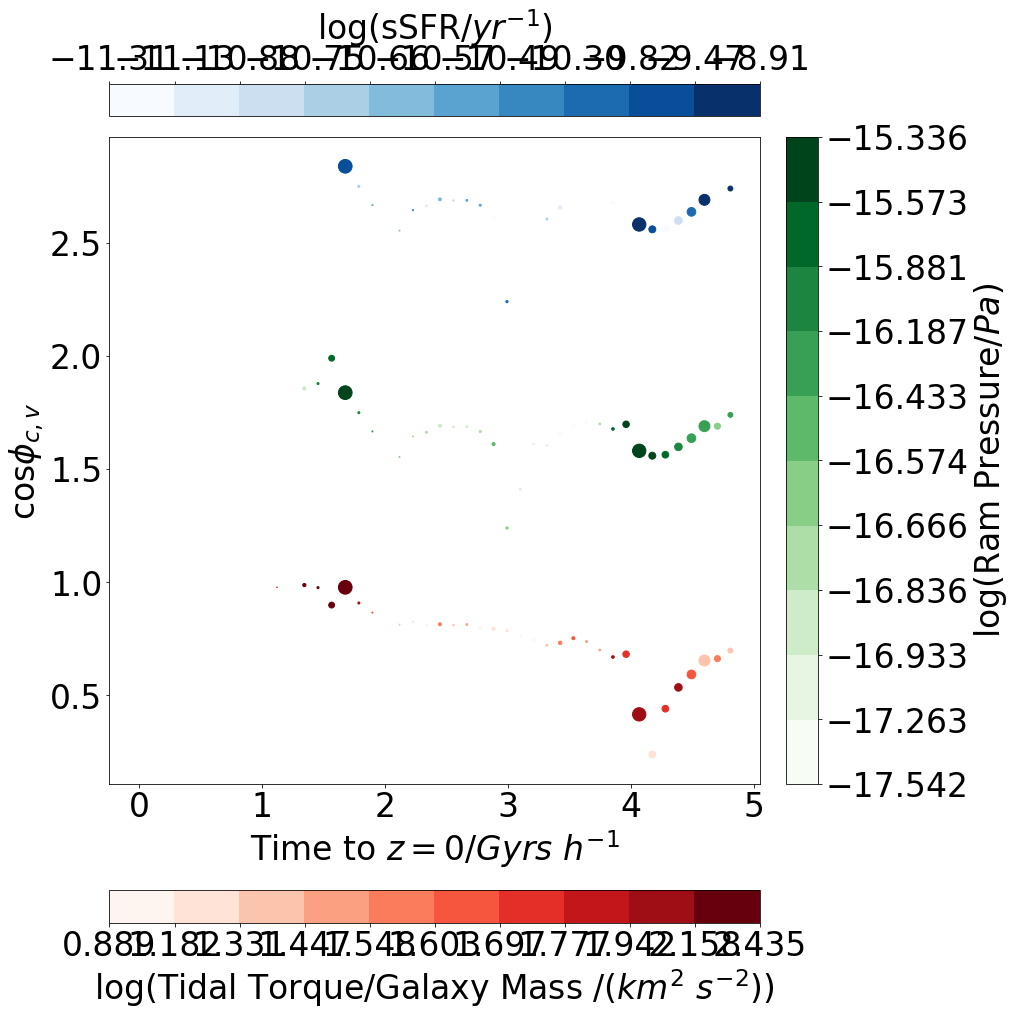

In [65]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4343, np.abs(cosC_4343), s=Gas_4343/5e5, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4343), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4343, np.abs(cosV_4343)+1., s=Gas_4343/5e5, c=np.log10(RP_4343), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4343, np.abs(cosV_4343)+2., s=Gas_4343/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

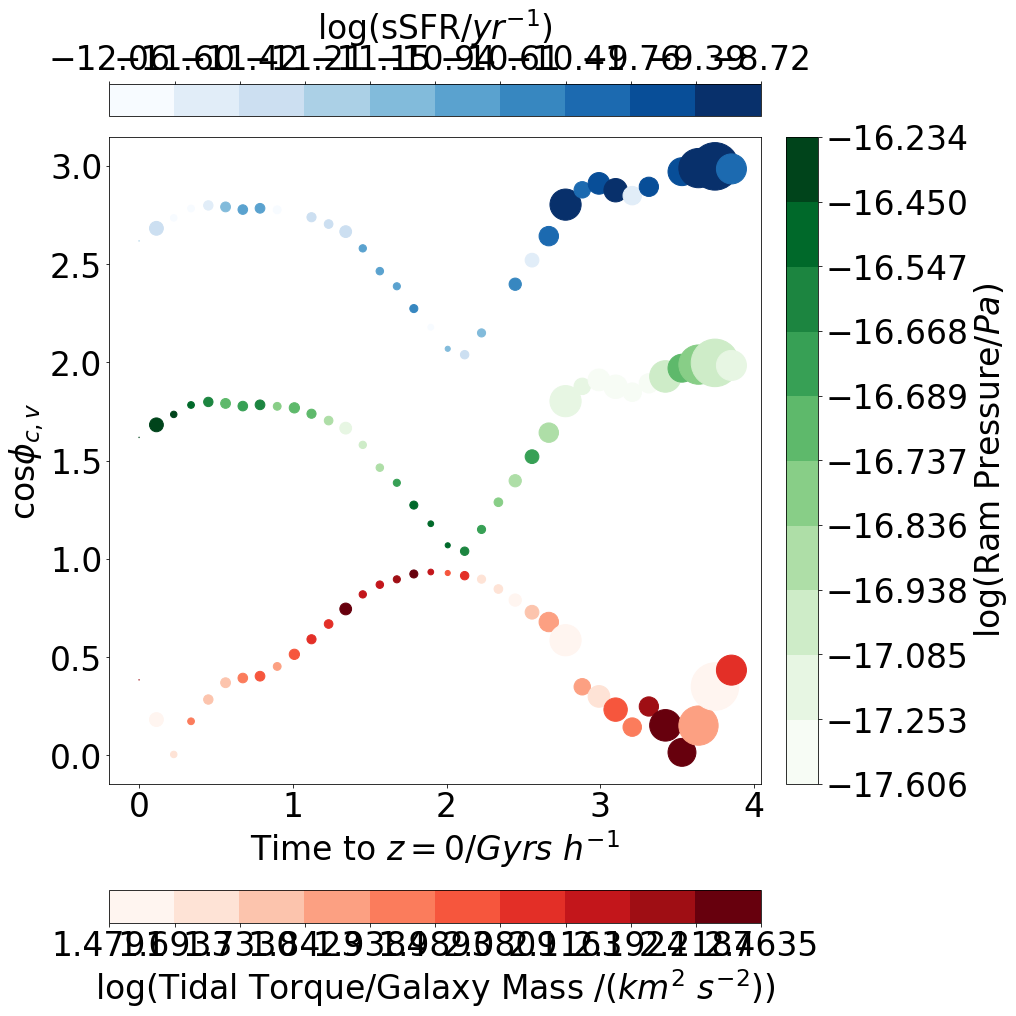

In [66]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4470, np.abs(cosC_4470), s=Gas_4470/5e5, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4470, np.abs(cosV_4470)+1., s=Gas_4470/5e5, c=np.log10(RP_4470), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4470, np.abs(cosV_4470)+2., s=Gas_4470/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

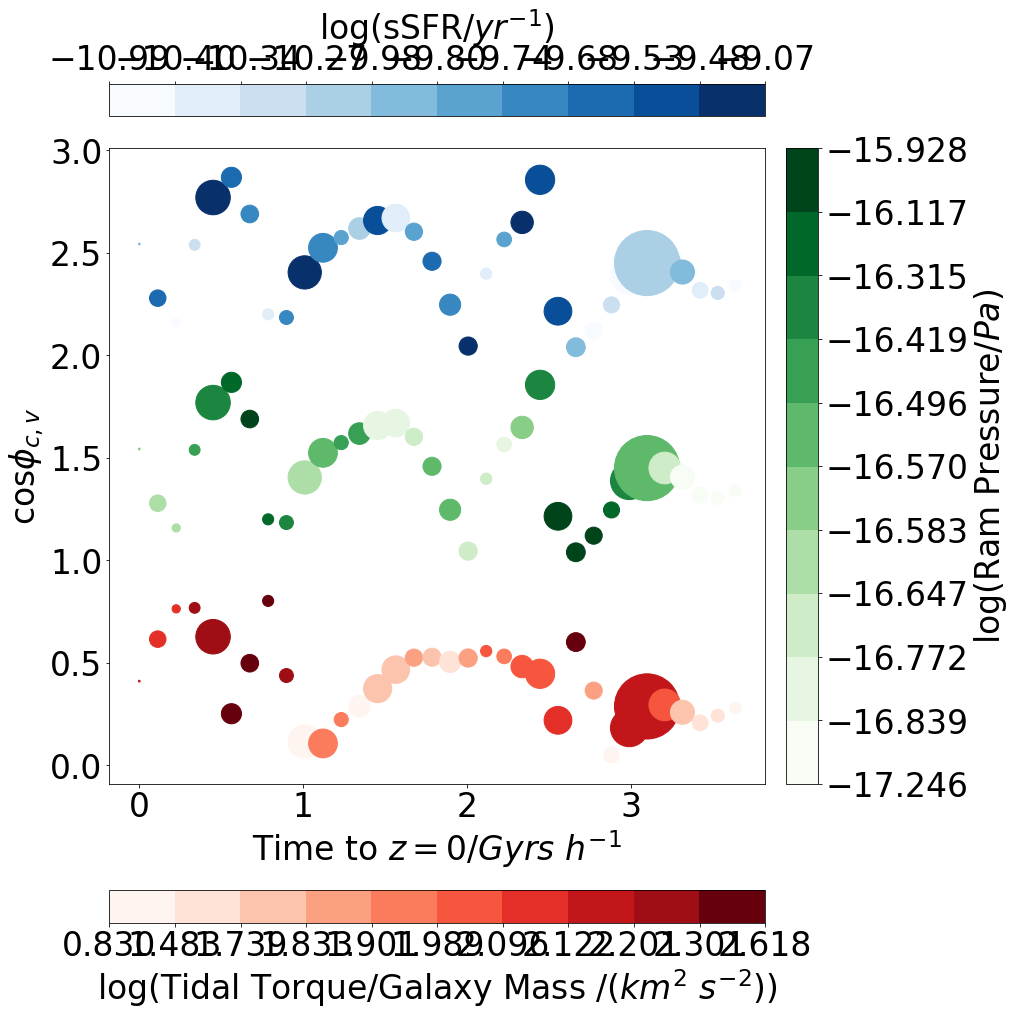

In [67]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4471, np.abs(cosC_4471), s=Gas_4471/5e5, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4471), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4471, np.abs(cosV_4471)+1., s=Gas_4471/5e5, c=np.log10(RP_4471), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4471, np.abs(cosV_4471)+2., s=Gas_4471/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

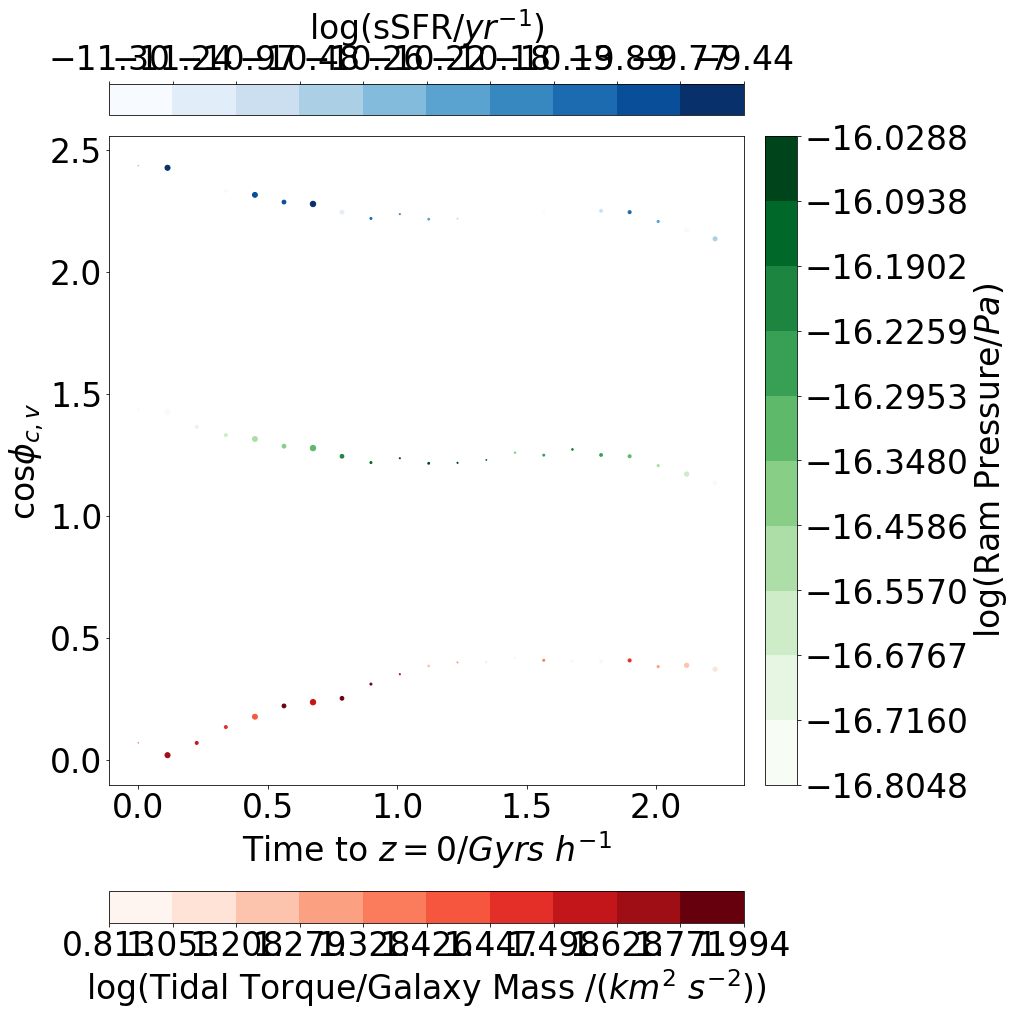

In [68]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4473, np.abs(cosC_4473), s=Gas_4473/5e5, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4473), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4473, np.abs(cosV_4473)+1., s=Gas_4473/5e5, c=np.log10(RP_4473), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4473, np.abs(cosV_4473)+2., s=Gas_4473/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Time to $z=0$/$Gyrs\\,\\,h^{-1}$')

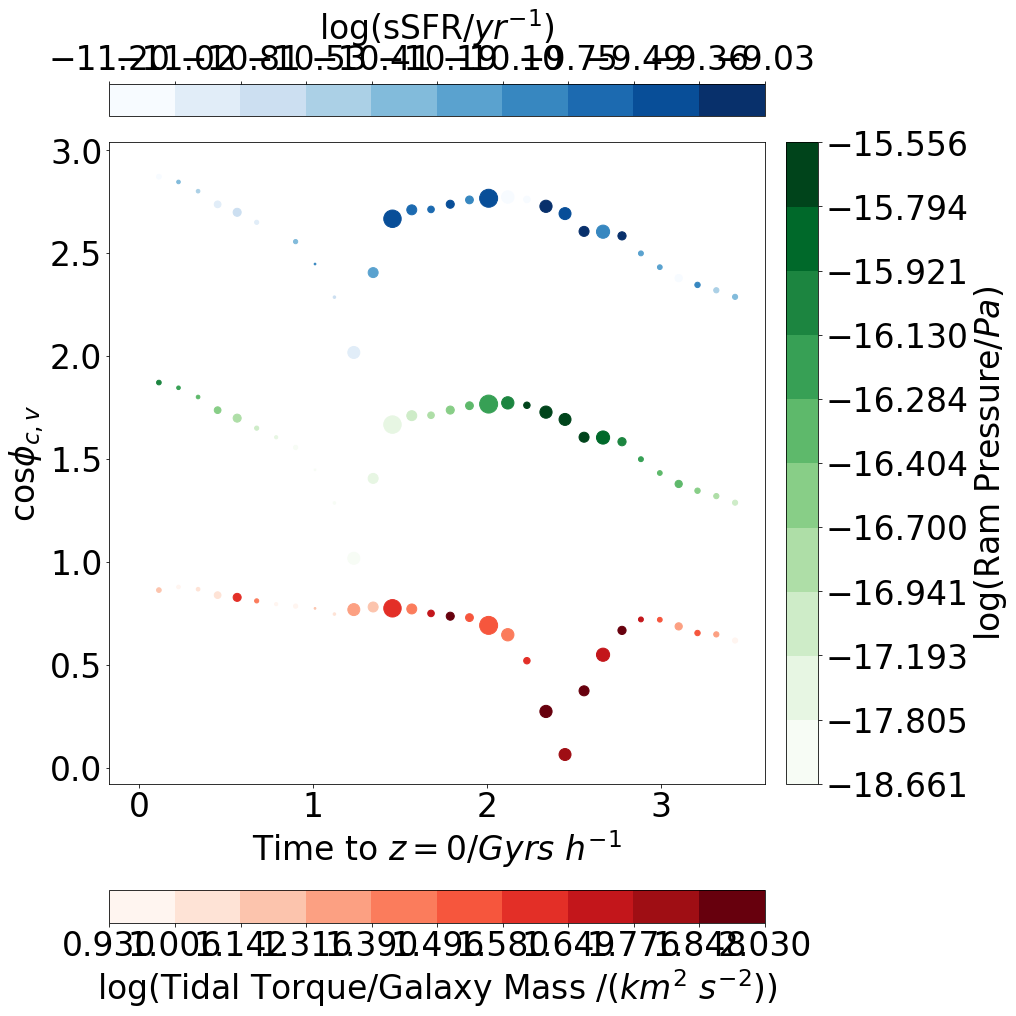

In [69]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4474, np.abs(cosC_4474), s=Gas_4474/5e5, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=cm.Reds)
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass $/(km^2\,\,s^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4474), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4474, np.abs(cosV_4474)+1., s=Gas_4474/5e5, c=np.log10(RP_4474), norm=norm2, cmap=cm.Greens)
barRP = pl.colorbar(label='$\log($Ram Pressure$/Pa)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4474, np.abs(cosV_4474)+2., s=Gas_4474/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
bar3 = pl.colorbar(label='$\log($sSFR$/yr^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('Time to $z=0$/$Gyrs\,\,h^{-1}$')

In [70]:
# and gonna write all those combinations
with h5py.File('Derived_Data_3.h5', 'w') as f:
    f.create_dataset('g4338/distance', data=dist_4338)
    f.create_dataset('g4338/time', data=Time_4338)
    f.create_dataset('g4338/CosCen', data=cosC_4338)
    f.create_dataset('g4338/CosVel', data=cosV_4338)
    f.create_dataset('g4338/RP', data=RP_4338)
    f.create_dataset('g4338/TSt', data=TSt_4338)
    f.create_dataset('g4338/gMass', data=gMass_4338)
    f.create_dataset('g4338/SFR', data=SFR_4338)
    f.create_dataset('g4338/starMass', data=starMass_4338)
    f.create_dataset('g4338/Gas', data=Gas_4338)
    f.create_dataset('g4338/RestForce', data=RestForce_4338)
    
    f.create_dataset('g4339/distance', data=dist_4339)
    f.create_dataset('g4339/time', data=Time_4339)
    f.create_dataset('g4339/CosCen', data=cosC_4339)
    f.create_dataset('g4339/CosVel', data=cosV_4339)
    f.create_dataset('g4339/RP', data=RP_4339)
    f.create_dataset('g4339/TSt', data=TSt_4339)
    f.create_dataset('g4339/gMass', data=gMass_4339)
    f.create_dataset('g4339/SFR', data=SFR_4339)
    f.create_dataset('g4339/starMass', data=starMass_4339)
    f.create_dataset('g4339/Gas', data=Gas_4339)
    f.create_dataset('g4339/RestForce', data=RestForce_4339)
    
    f.create_dataset('g4341/distance', data=dist_4341)
    f.create_dataset('g4341/time', data=Time_4341)
    f.create_dataset('g4341/CosCen', data=cosC_4341)
    f.create_dataset('g4341/CosVel', data=cosV_4341)
    f.create_dataset('g4341/RP', data=RP_4341)
    f.create_dataset('g4341/TSt', data=TSt_4341)
    f.create_dataset('g4341/gMass', data=gMass_4341)
    f.create_dataset('g4341/SFR', data=SFR_4341)
    f.create_dataset('g4341/starMass', data=starMass_4341)
    f.create_dataset('g4341/Gas', data=Gas_4341)
    f.create_dataset('g4341/RestForce', data=RestForce_4341)
    
    f.create_dataset('g4343/distance', data=dist_4343)
    f.create_dataset('g4343/time', data=Time_4343)
    f.create_dataset('g4343/CosCen', data=cosC_4343)
    f.create_dataset('g4343/CosVel', data=cosV_4343)
    f.create_dataset('g4343/RP', data=RP_4343)
    f.create_dataset('g4343/TSt', data=TSt_4343)
    f.create_dataset('g4343/gMass', data=gMass_4343)
    f.create_dataset('g4343/SFR', data=SFR_4343)
    f.create_dataset('g4343/starMass', data=starMass_4343)
    f.create_dataset('g4343/Gas', data=Gas_4343)
    f.create_dataset('g4343/RestForce', data=RestForce_4343)
    
    f.create_dataset('g4470/distance', data=dist_4470)
    f.create_dataset('g4470/time', data=Time_4470)
    f.create_dataset('g4470/CosCen', data=cosC_4470)
    f.create_dataset('g4470/CosVel', data=cosV_4470)
    f.create_dataset('g4470/RP', data=RP_4470)
    f.create_dataset('g4470/TSt', data=TSt_4470)
    f.create_dataset('g4470/gMass', data=gMass_4470)
    f.create_dataset('g4470/SFR', data=SFR_4470)
    f.create_dataset('g4470/starMass', data=starMass_4470)
    f.create_dataset('g4470/Gas', data=Gas_4470)
    f.create_dataset('g4470/RestForce', data=RestForce_4470)
    
    f.create_dataset('g4471/distance', data=dist_4471)
    f.create_dataset('g4471/time', data=Time_4471)
    f.create_dataset('g4471/CosCen', data=cosC_4471)
    f.create_dataset('g4471/CosVel', data=cosV_4471)
    f.create_dataset('g4471/RP', data=RP_4471)
    f.create_dataset('g4471/TSt', data=TSt_4471)
    f.create_dataset('g4471/gMass', data=gMass_4471)
    f.create_dataset('g4471/SFR', data=SFR_4471)
    f.create_dataset('g4471/starMass', data=starMass_4471)
    f.create_dataset('g4471/Gas', data=Gas_4471)
    f.create_dataset('g4471/RestForce', data=RestForce_4471)
    
    f.create_dataset('g4473/distance', data=dist_4473)
    f.create_dataset('g4473/time', data=Time_4473)
    f.create_dataset('g4473/CosCen', data=cosC_4473)
    f.create_dataset('g4473/CosVel', data=cosV_4473)
    f.create_dataset('g4473/RP', data=RP_4473)
    f.create_dataset('g4473/TSt', data=TSt_4473)
    f.create_dataset('g4473/gMass', data=gMass_4473)
    f.create_dataset('g4473/SFR', data=SFR_4473)
    f.create_dataset('g4473/starMass', data=starMass_4473)
    f.create_dataset('g4473/Gas', data=Gas_4473)
    f.create_dataset('g4473/RestForce', data=RestForce_4473)
    
    f.create_dataset('g4474/distance', data=dist_4474)
    f.create_dataset('g4474/time', data=Time_4474)
    f.create_dataset('g4474/CosCen', data=cosC_4474)
    f.create_dataset('g4474/CosVel', data=cosV_4474)
    f.create_dataset('g4474/RP', data=RP_4474)
    f.create_dataset('g4474/TSt', data=TSt_4474)
    f.create_dataset('g4474/gMass', data=gMass_4474)
    f.create_dataset('g4474/SFR', data=SFR_4474)
    f.create_dataset('g4474/starMass', data=starMass_4474)
    f.create_dataset('g4474/Gas', data=Gas_4474)
    f.create_dataset('g4474/RestForce', data=RestForce_4474)

In [12]:
# I want to look at something, so lets read the thing:

T = h5py.File('Derived_Data_3.h5', 'r')


dist_4338 = T['g4338/distance'][()]
Time_4338 = T['g4338/time'][()]
cosC_4338 = T['g4338/CosCen'][()]
cosV_4338 = T['g4338/CosVel'][()]
RP_4338 = T['g4338/RP'][()]
TSt_4338 = T['g4338/TSt'][()]
gMass_4338 = T['g4338/gMass'][()]
SFR_4338 = T['g4338/SFR'][()]
starMass_4338 = T['g4338/starMass'][()]
Gas_4338 = T['g4338/Gas'][()]
RestForce_4338 = T['g4338/RestForce'][()]

dist_4339 = T['g4339/distance'][()]
Time_4339 = T['g4339/time'][()]
cosC_4339 = T['g4339/CosCen'][()]
cosV_4339 = T['g4339/CosVel'][()]
RP_4339 = T['g4339/RP'][()]
TSt_4339 = T['g4339/TSt'][()]
gMass_4339 = T['g4339/gMass'][()]
SFR_4339 = T['g4339/SFR'][()]
starMass_4339 = T['g4339/starMass'][()]
Gas_4339 = T['g4339/Gas'][()]
RestForce_4339 = T['g4339/RestForce'][()]

dist_4341 = T['g4341/distance'][()]
Time_4341 = T['g4341/time'][()]
cosC_4341 = T['g4341/CosCen'][()]
cosV_4341 = T['g4341/CosVel'][()]
RP_4341 = T['g4341/RP'][()]
TSt_4341 = T['g4341/TSt'][()]
gMass_4341 = T['g4341/gMass'][()]
SFR_4341 = T['g4341/SFR'][()]
starMass_4341 = T['g4341/starMass'][()]
Gas_4341 = T['g4341/Gas'][()]
RestForce_4341 = T['g4341/RestForce'][()]

dist_4343 = T['g4343/distance'][()]
Time_4343 = T['g4343/time'][()]
cosC_4343 = T['g4343/CosCen'][()]
cosV_4343 = T['g4343/CosVel'][()]
RP_4343 = T['g4343/RP'][()]
TSt_4343 = T['g4343/TSt'][()]
gMass_4343 = T['g4343/gMass'][()]
SFR_4343 = T['g4343/SFR'][()]
starMass_4343 = T['g4343/starMass'][()]
Gas_4343 = T['g4343/Gas'][()]
RestForce_4343 = T['g4343/RestForce'][()]

dist_4470 = T['g4470/distance'][()]
Time_4470 = T['g4470/time'][()]
cosC_4470 = T['g4470/CosCen'][()]
cosV_4470 = T['g4470/CosVel'][()]
RP_4470 = T['g4470/RP'][()]
TSt_4470 = T['g4470/TSt'][()]
gMass_4470 = T['g4470/gMass'][()]
SFR_4470 = T['g4470/SFR'][()]
starMass_4470 = T['g4470/starMass'][()]
Gas_4470 = T['g4470/Gas'][()]
RestForce_4470 = T['g4470/RestForce'][()]

dist_4471 = T['g4471/distance'][()]
Time_4471 = T['g4471/time'][()]
cosC_4471 = T['g4471/CosCen'][()]
cosV_4471 = T['g4471/CosVel'][()]
RP_4471 = T['g4471/RP'][()]
TSt_4471 = T['g4471/TSt'][()]
gMass_4471 = T['g4471/gMass'][()]
SFR_4471 = T['g4471/SFR'][()]
starMass_4471 = T['g4471/starMass'][()]
Gas_4471 = T['g4471/Gas'][()]
RestForce_4471 = T['g4471/RestForce'][()]

dist_4473 = T['g4473/distance'][()]
Time_4473 = T['g4473/time'][()]
cosC_4473 = T['g4473/CosCen'][()]
cosV_4473 = T['g4473/CosVel'][()]
RP_4473 = T['g4473/RP'][()]
TSt_4473 = T['g4473/TSt'][()]
gMass_4473 = T['g4473/gMass'][()]
SFR_4473 = T['g4473/SFR'][()]
starMass_4473 = T['g4473/starMass'][()]
Gas_4473 = T['g4473/Gas'][()]
RestForce_4473 = T['g4473/RestForce'][()]

dist_4474 = T['g4474/distance'][()]
Time_4474 = T['g4474/time'][()]
cosC_4474 = T['g4474/CosCen'][()]
cosV_4474 = T['g4474/CosVel'][()]
RP_4474 = T['g4474/RP'][()]
TSt_4474 = T['g4474/TSt'][()]
gMass_4474 = T['g4474/gMass'][()]
SFR_4474 = T['g4474/SFR'][()]
starMass_4474 = T['g4474/starMass'][()]
Gas_4474 = T['g4474/Gas'][()]
RestForce_4474 = T['g4474/RestForce'][()]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'distance to the centre/$r_{200}$')

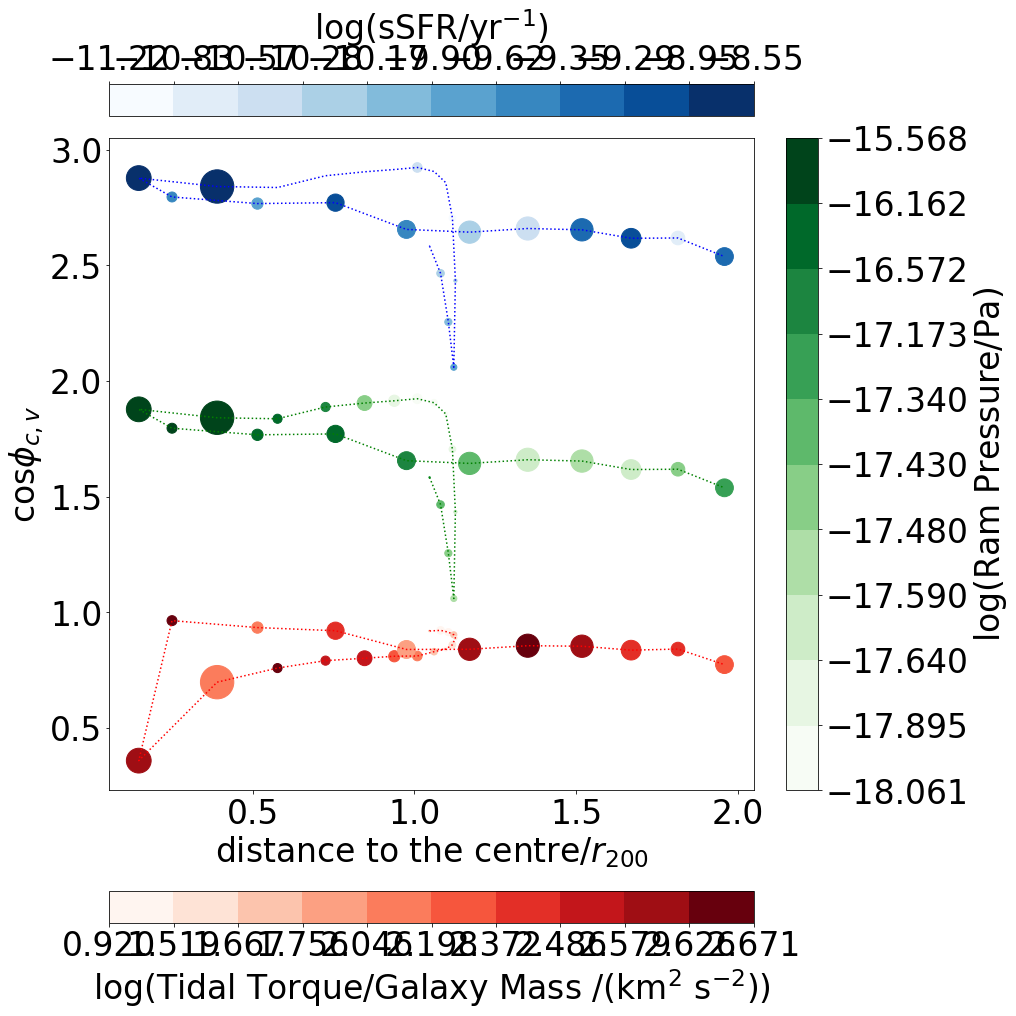

In [10]:
# and with distances, lets see

pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4338, np.abs(cosC_4338), s=Gas_4338/5e5, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=cm.Reds)
pl.plot(dist_4338, np.abs(cosC_4338), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass /(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4338), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4338, np.abs(cosV_4338)+1., s=Gas_4338/5e5, c=np.log10(RP_4338), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4338, np.abs(cosV_4338)+1, ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4338, np.abs(cosV_4338)+2., s=Gas_4338/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4338, np.abs(cosV_4338)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'distance to the centre/$r_{200}$')

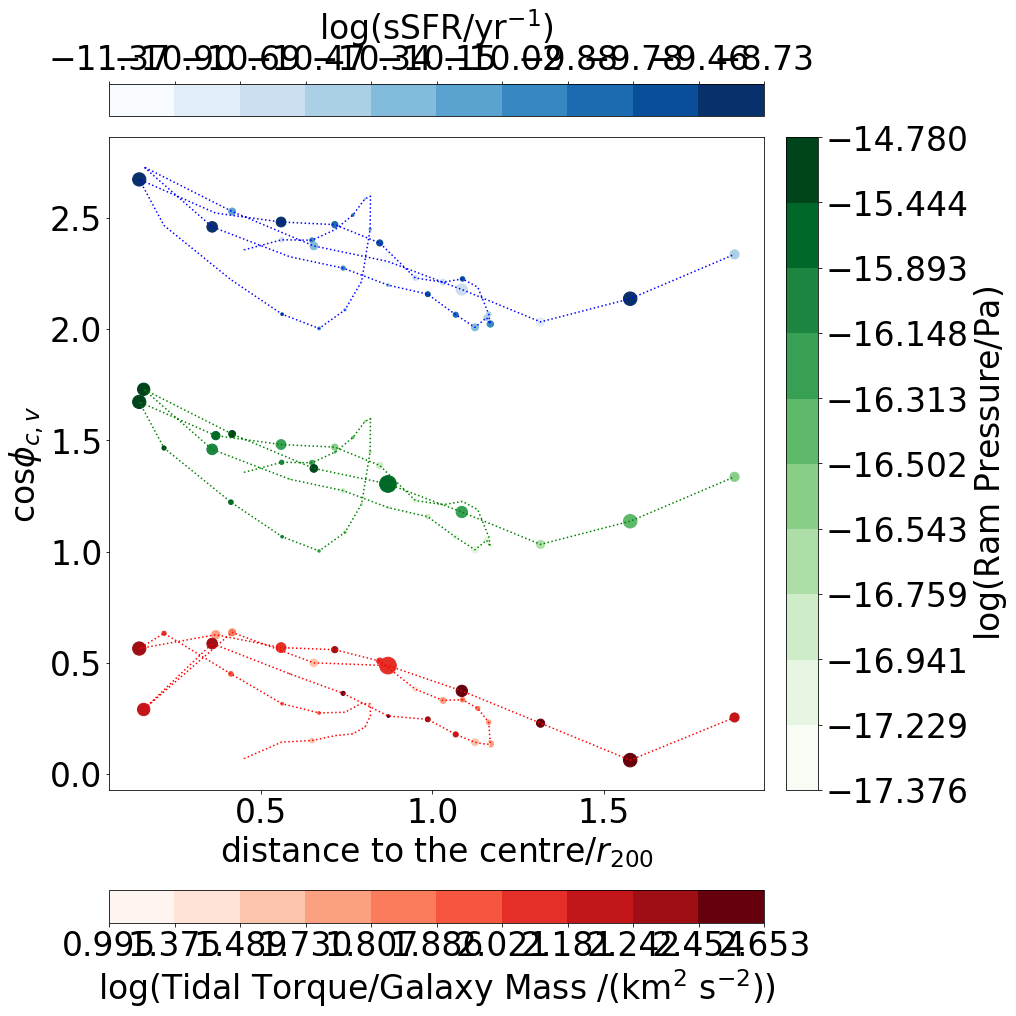

In [73]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4339, np.abs(cosC_4339), s=Gas_4339/5e5, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=cm.Reds)
pl.plot(dist_4339, np.abs(cosC_4339), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass /(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4339), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4339, np.abs(cosV_4339)+1., s=Gas_4339/5e5, c=np.log10(RP_4339), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4339, np.abs(cosV_4339)+1., ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4339, np.abs(cosV_4339)+2., s=Gas_4339/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4339, np.abs(cosV_4339)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'distance to the centre/$r_{200}$')

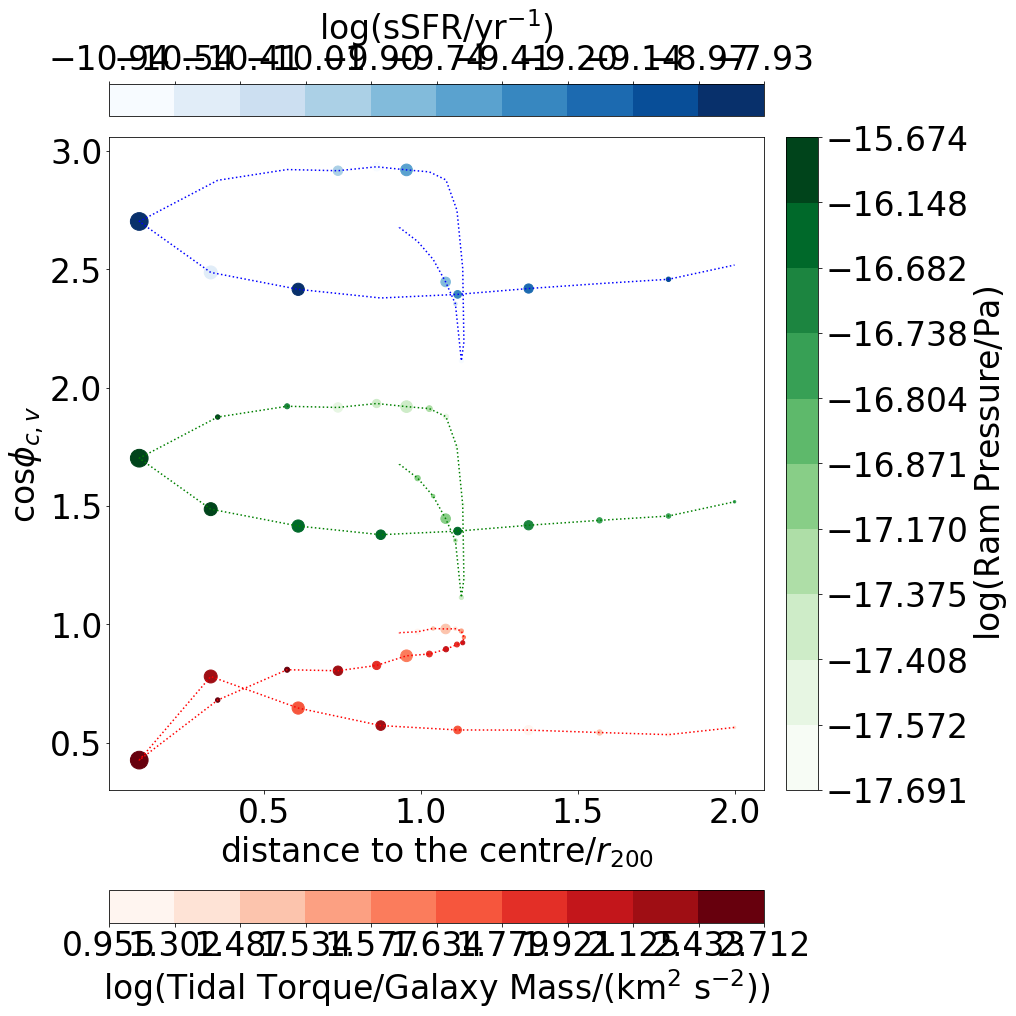

In [74]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4341, np.abs(cosC_4341), s=Gas_4341/5e5, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=cm.Reds)
pl.plot(dist_4341, np.abs(cosC_4341), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4341), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4341, np.abs(cosV_4341)+1., s=Gas_4341/5e5, c=np.log10(RP_4341), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4341, np.abs(cosV_4341)+1, ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4341, np.abs(cosV_4341)+2., s=Gas_4341/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4341, np.abs(cosV_4341)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'distance to the centre/$r_{200}$')

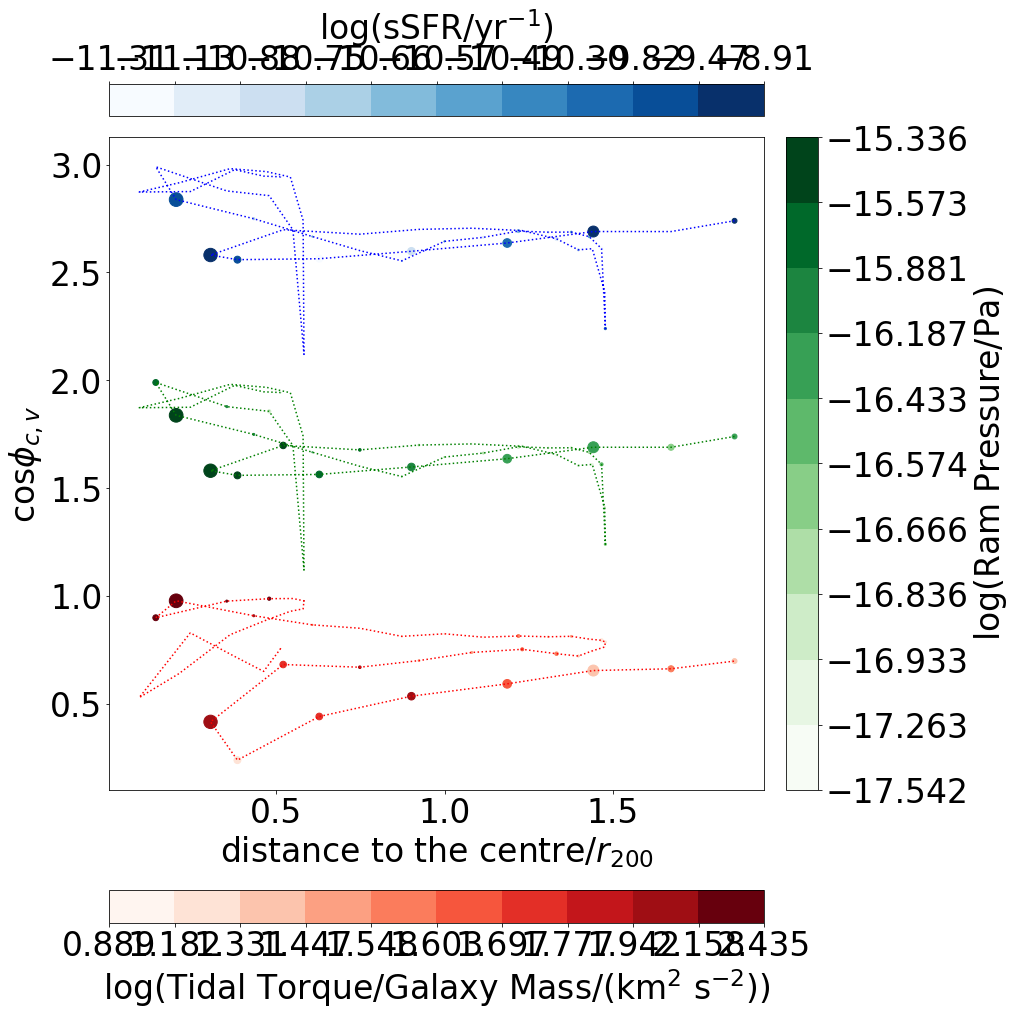

In [75]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4343, np.abs(cosC_4343), s=Gas_4343/5e5, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=cm.Reds)
pl.plot(dist_4343, np.abs(cosC_4343), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4343), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4343, np.abs(cosV_4343)+1., s=Gas_4343/5e5, c=np.log10(RP_4343), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4343, np.abs(cosV_4343)+1, ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4343, np.abs(cosV_4343)+2., s=Gas_4343/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4343, np.abs(cosV_4343)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'distance to the centre/$r_{200}$')

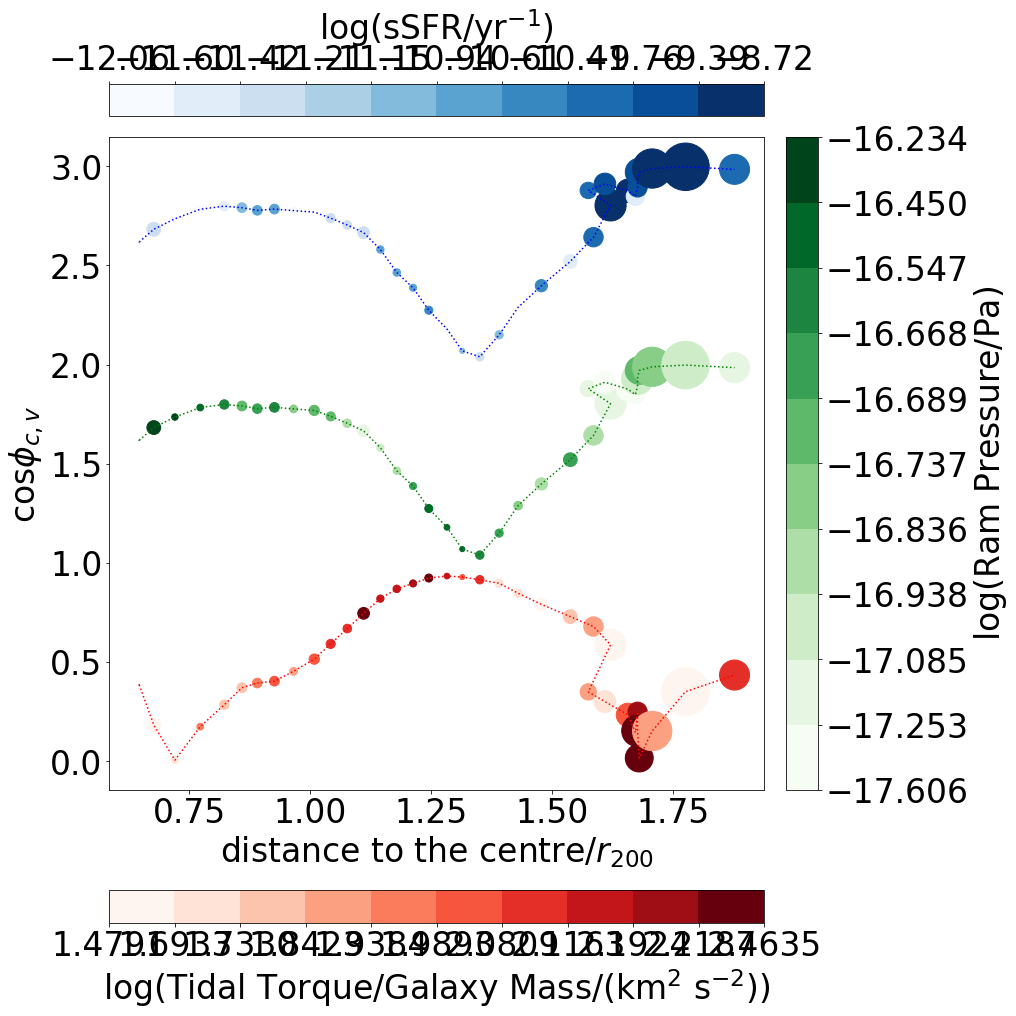

In [76]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4470, np.abs(cosC_4470), s=Gas_4470/5e5, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=cm.Reds)
pl.plot(dist_4470, np.abs(cosC_4470), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4470, np.abs(cosV_4470)+1., s=Gas_4470/5e5, c=np.log10(RP_4470), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4470, np.abs(cosV_4470)+1, ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4470, np.abs(cosV_4470)+2., s=Gas_4470/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4470, np.abs(cosV_4470)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

Text(0.5, 0, 'distance to the centre/$r_{200}$')

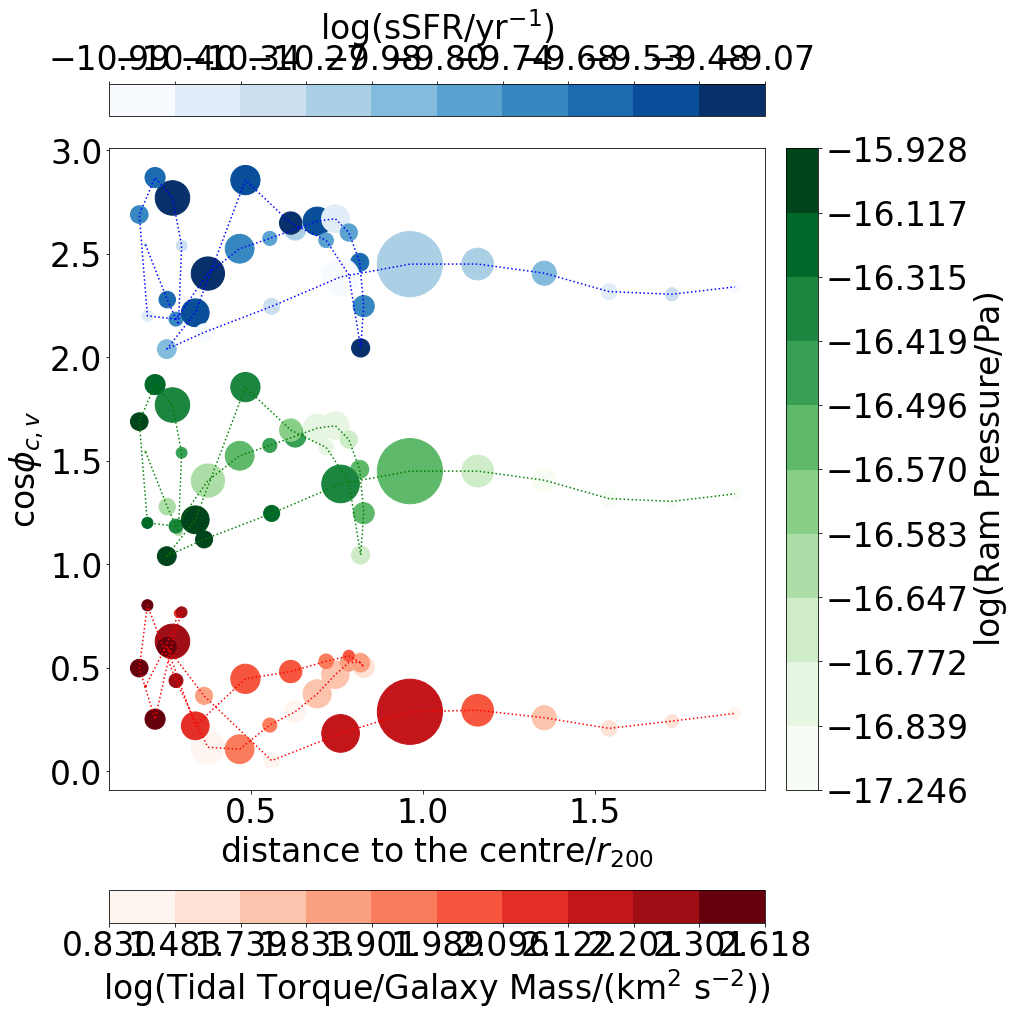

In [77]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4471, np.abs(cosC_4471), s=Gas_4471/5e5, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=cm.Reds)
pl.plot(dist_4471, np.abs(cosC_4471), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4471), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4471, np.abs(cosV_4471)+1., s=Gas_4471/5e5, c=np.log10(RP_4471), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4471, np.abs(cosV_4471)+1, ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4471, np.abs(cosV_4471)+2., s=Gas_4471/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4471, np.abs(cosV_4471)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'distance to the centre/$r_{200}$')

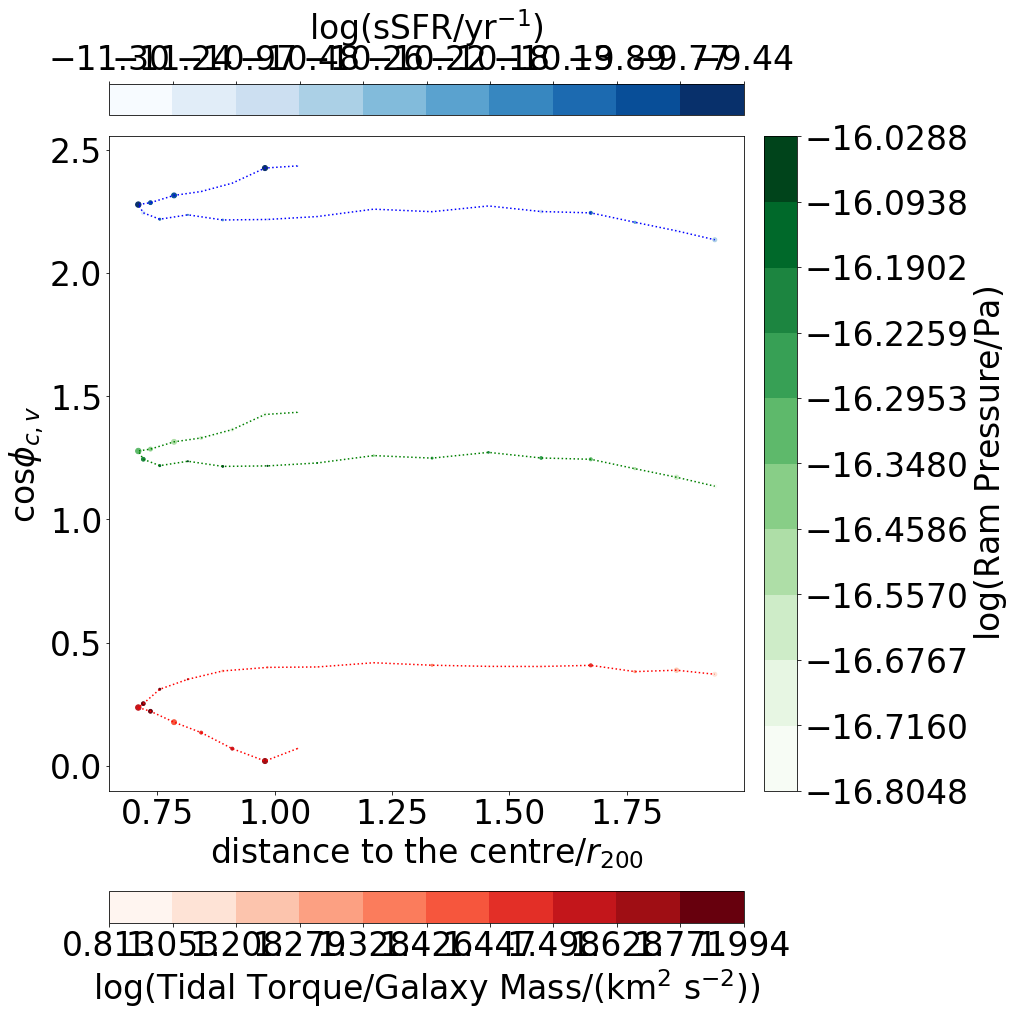

In [78]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4473, np.abs(cosC_4473), s=Gas_4473/5e5, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=cm.Reds)
pl.plot(dist_4473, np.abs(cosC_4473), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4473), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4473, np.abs(cosV_4473)+1., s=Gas_4473/5e5, c=np.log10(RP_4473), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4473, np.abs(cosV_4473)+1, ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4473, np.abs(cosV_4473)+2., s=Gas_4473/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4473, np.abs(cosV_4473)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'distance to the centre/$r_{200}$')

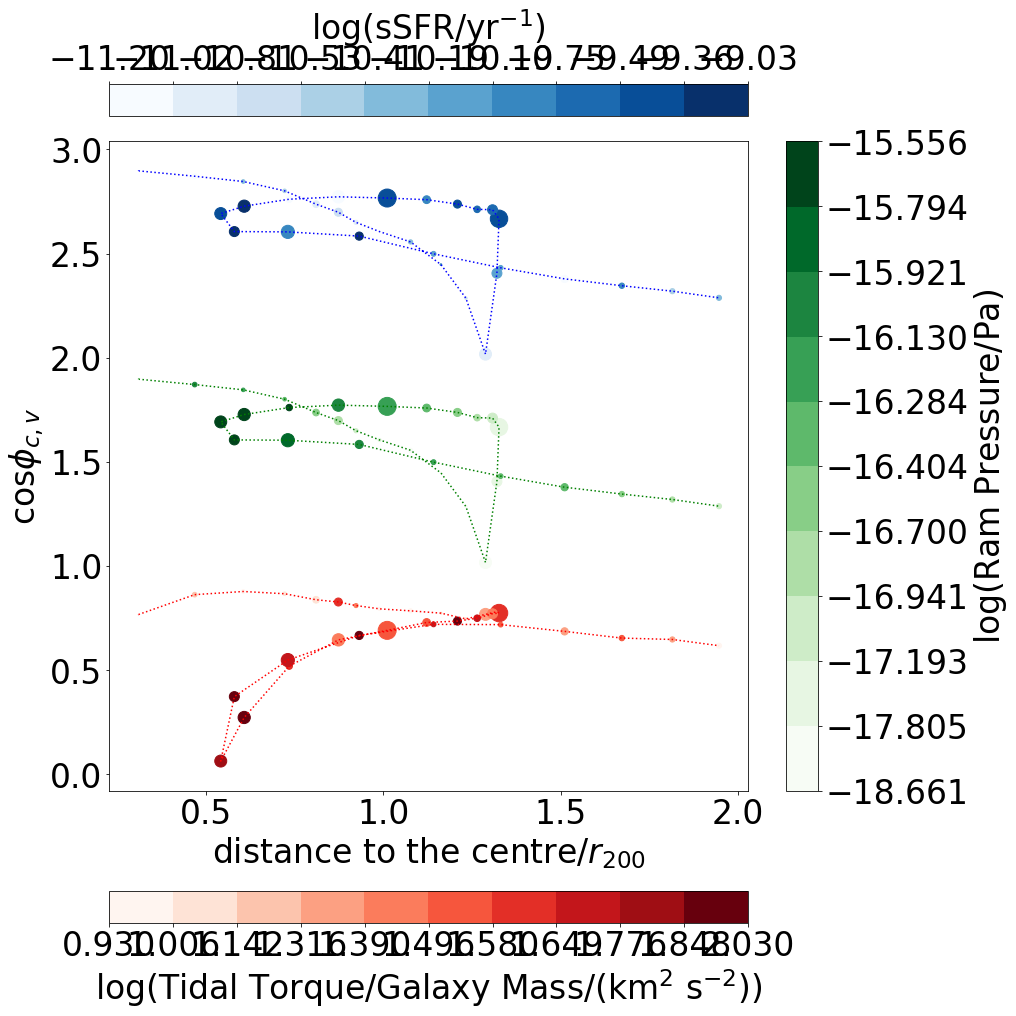

In [79]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 11)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(dist_4474, np.abs(cosC_4474), s=Gas_4474/5e5, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=cm.Reds)
pl.plot(dist_4474, np.abs(cosC_4474), ls=':', color='red')
barT = pl.colorbar(label='log(Tidal Torque/Galaxy Mass/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4474), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(dist_4474, np.abs(cosV_4474)+1., s=Gas_4474/5e5, c=np.log10(RP_4474), norm=norm2, cmap=cm.Greens)
pl.plot(dist_4474, np.abs(cosV_4474)+1, ls=':', color='green')
barRP = pl.colorbar(label='$\log($Ram Pressure/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(dist_4474, np.abs(cosV_4474)+2., s=Gas_4474/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues)
pl.plot(dist_4474, np.abs(cosV_4474)+2, ls=':', color='blue')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)

pl.ylabel('$\cos \phi_{c,v}$')
pl.xlabel('distance to the centre/$r_{200}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

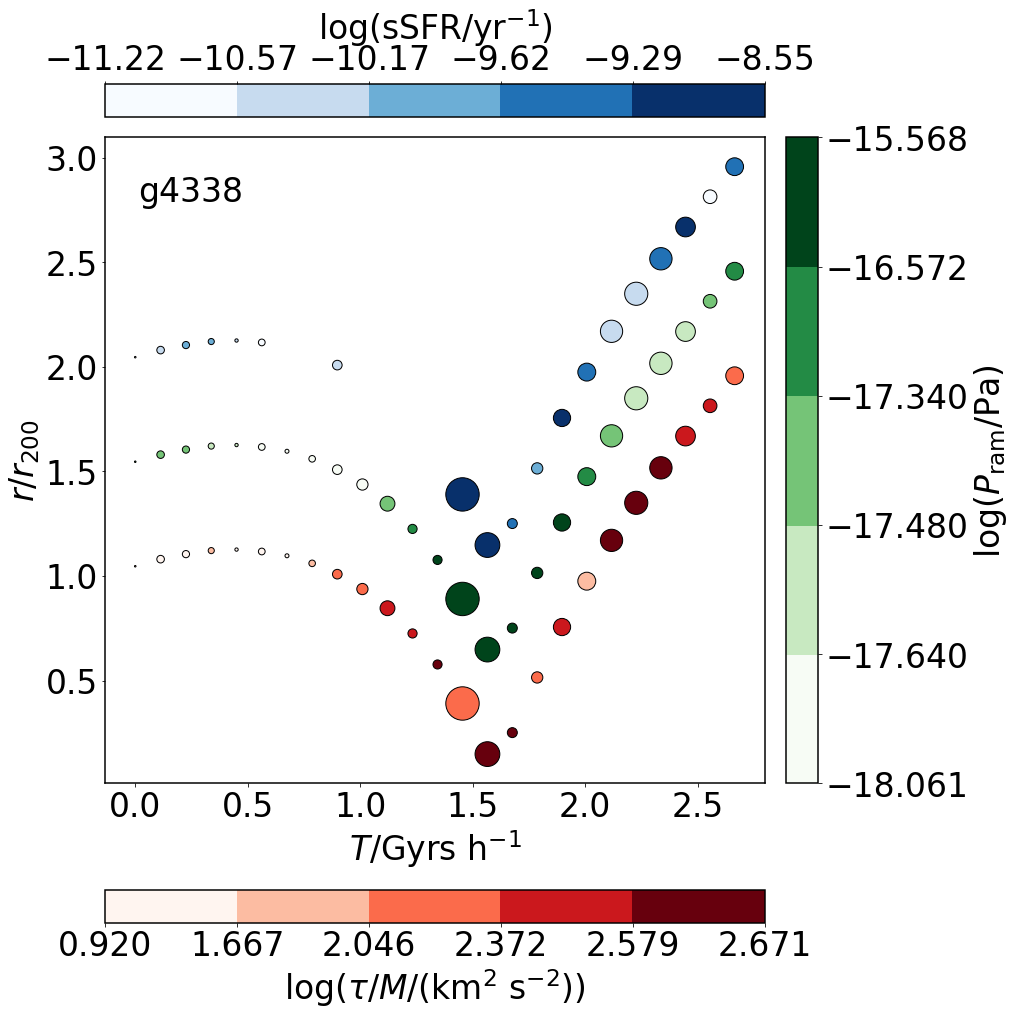

In [13]:
# teh same as aobove, but with a mark, and after reading the file this is faster.
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4338/gMass_4338), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4338, dist_4338, s=Gas_4338/5e5, c=np.log10(TSt_4338/gMass_4338), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4338), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4338, dist_4338+0.5, s=Gas_4338/5e5, c=np.log10(RP_4338), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4338/starMass_4338)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4338, dist_4338+1., s=Gas_4338/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4338')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

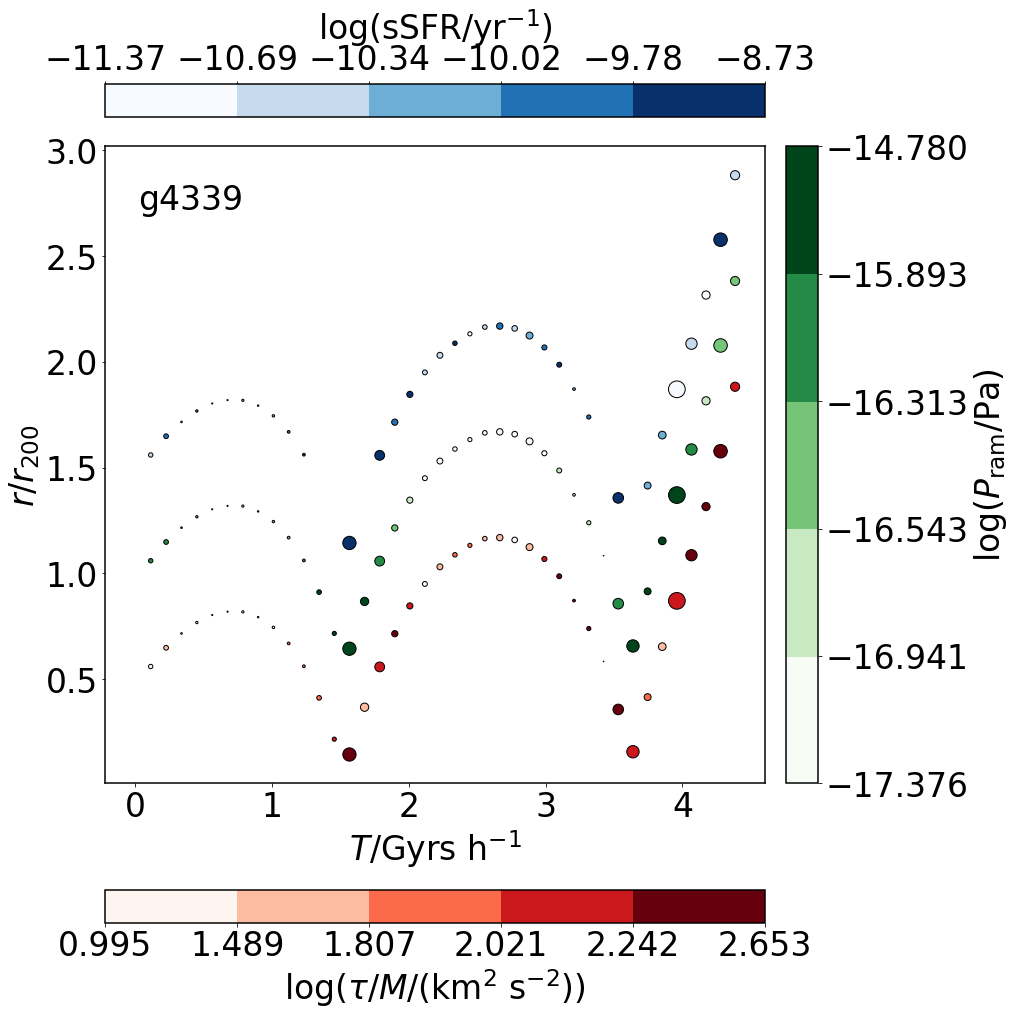

In [14]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4339/gMass_4339), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4339, dist_4339, s=Gas_4339/5e5, c=np.log10(TSt_4339/gMass_4339), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4339), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4339, dist_4339+0.5, s=Gas_4339/5e5, c=np.log10(RP_4339), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4339/starMass_4339)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4339, dist_4339+1., s=Gas_4339/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4339')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs $h^{-1}$')

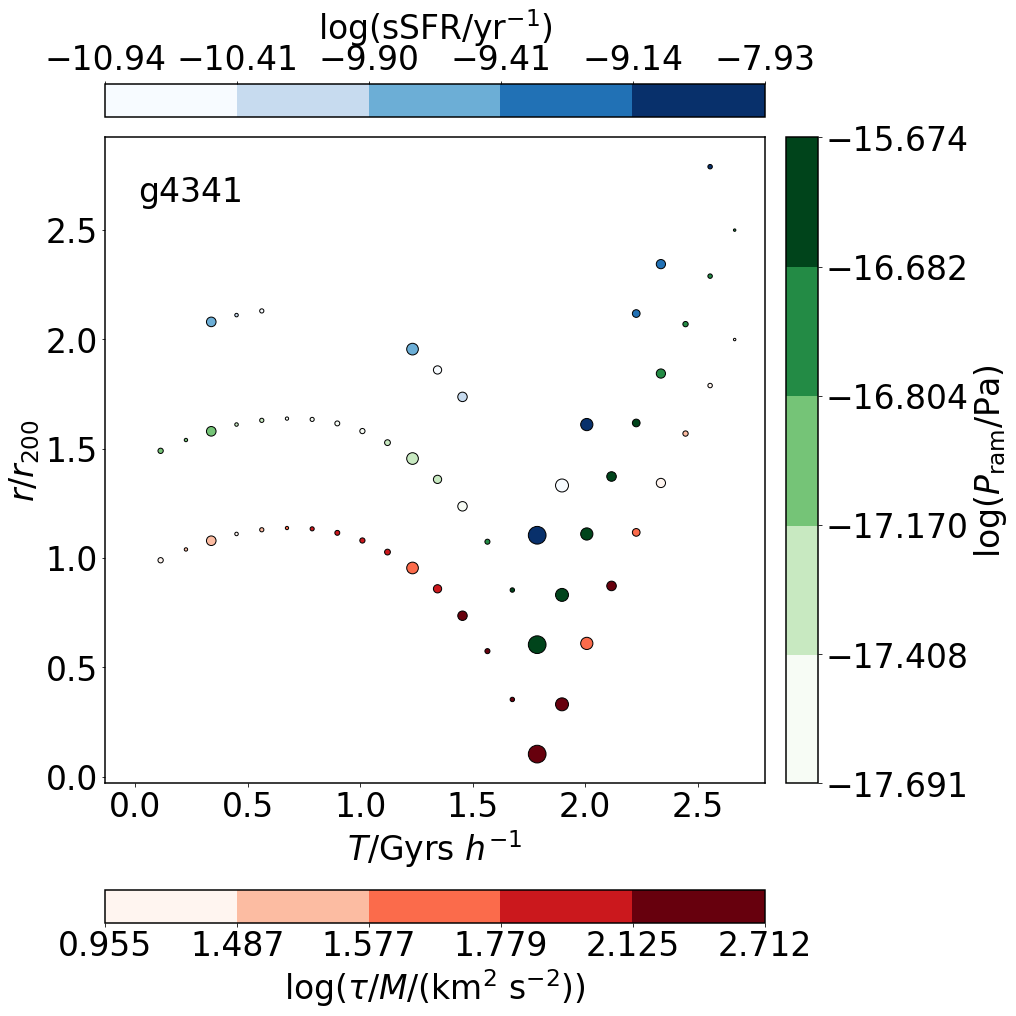

In [15]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4341/gMass_4341), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4341, dist_4341, s=Gas_4341/5e5, c=np.log10(TSt_4341/gMass_4341), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4341), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4341, dist_4341+0.5, s=Gas_4341/5e5, c=np.log10(RP_4341), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4341/starMass_4341)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4341, dist_4341+1., s=Gas_4341/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4341')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs $h^{-1}$')


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

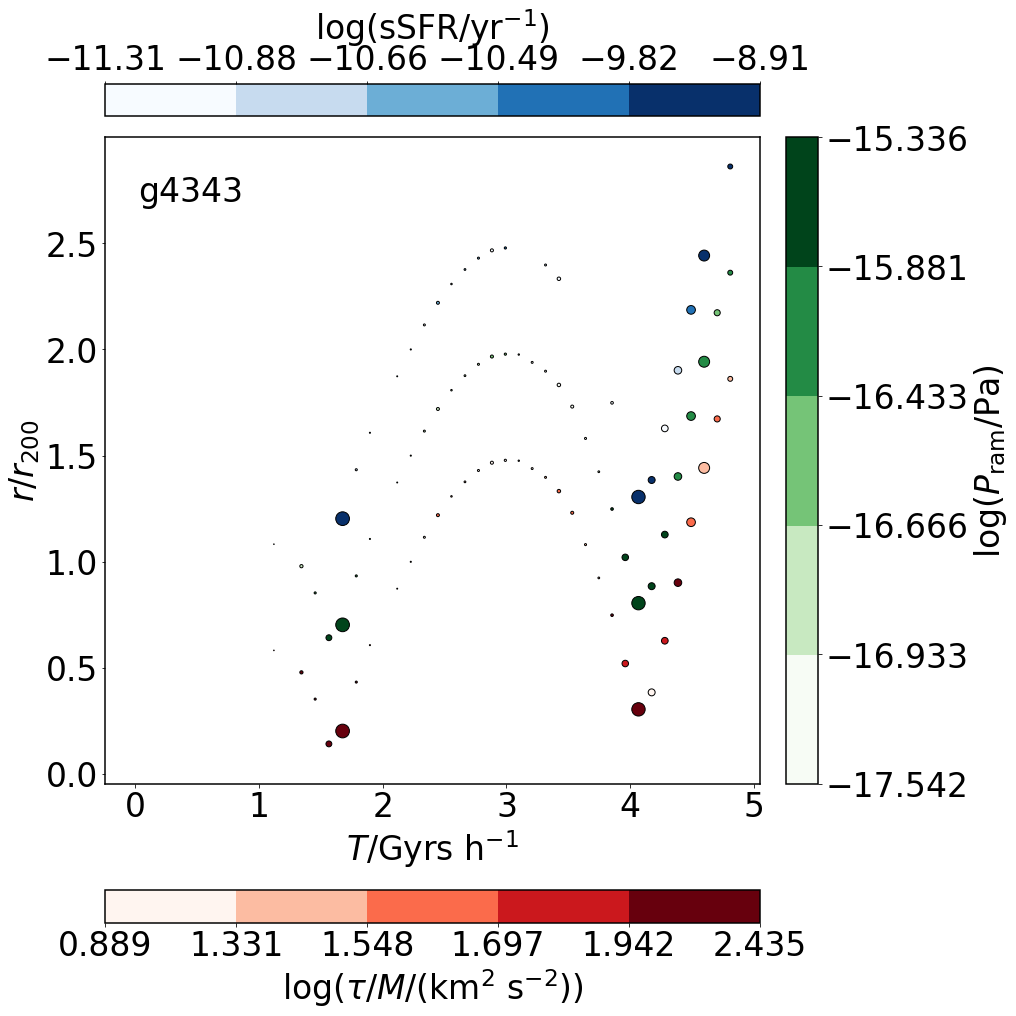

In [16]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4343/gMass_4343), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4343, dist_4343, s=Gas_4343/5e5, c=np.log10(TSt_4343/gMass_4343), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4343), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4343, dist_4343+0.5, s=Gas_4343/5e5, c=np.log10(RP_4343), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4343/starMass_4343)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4343, dist_4343+1., s=Gas_4343/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4343')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

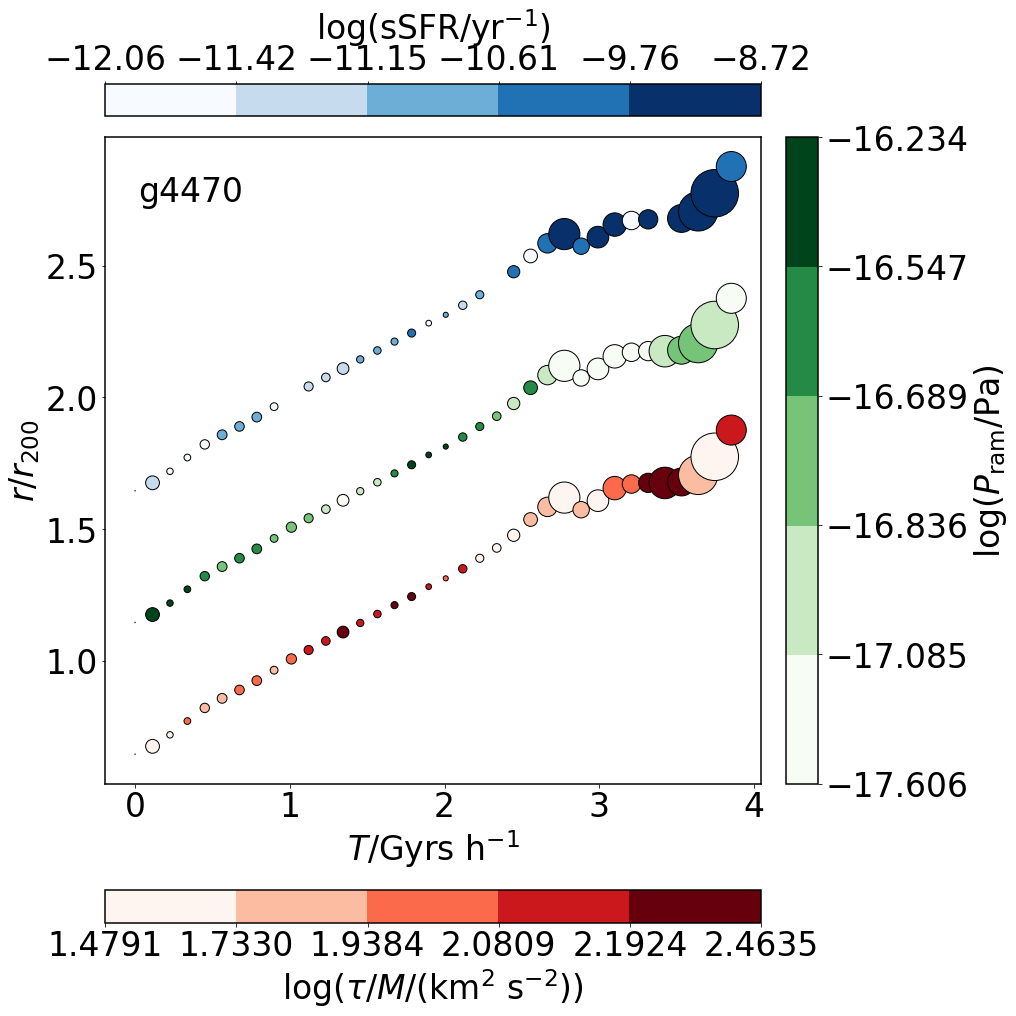

In [17]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4470/gMass_4470), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4470, dist_4470, s=Gas_4470/5e5, c=np.log10(TSt_4470/gMass_4470), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4470), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4470, dist_4470+0.5, s=Gas_4470/5e5, c=np.log10(RP_4470), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4470/starMass_4470)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4470, dist_4470+1., s=Gas_4470/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4470')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

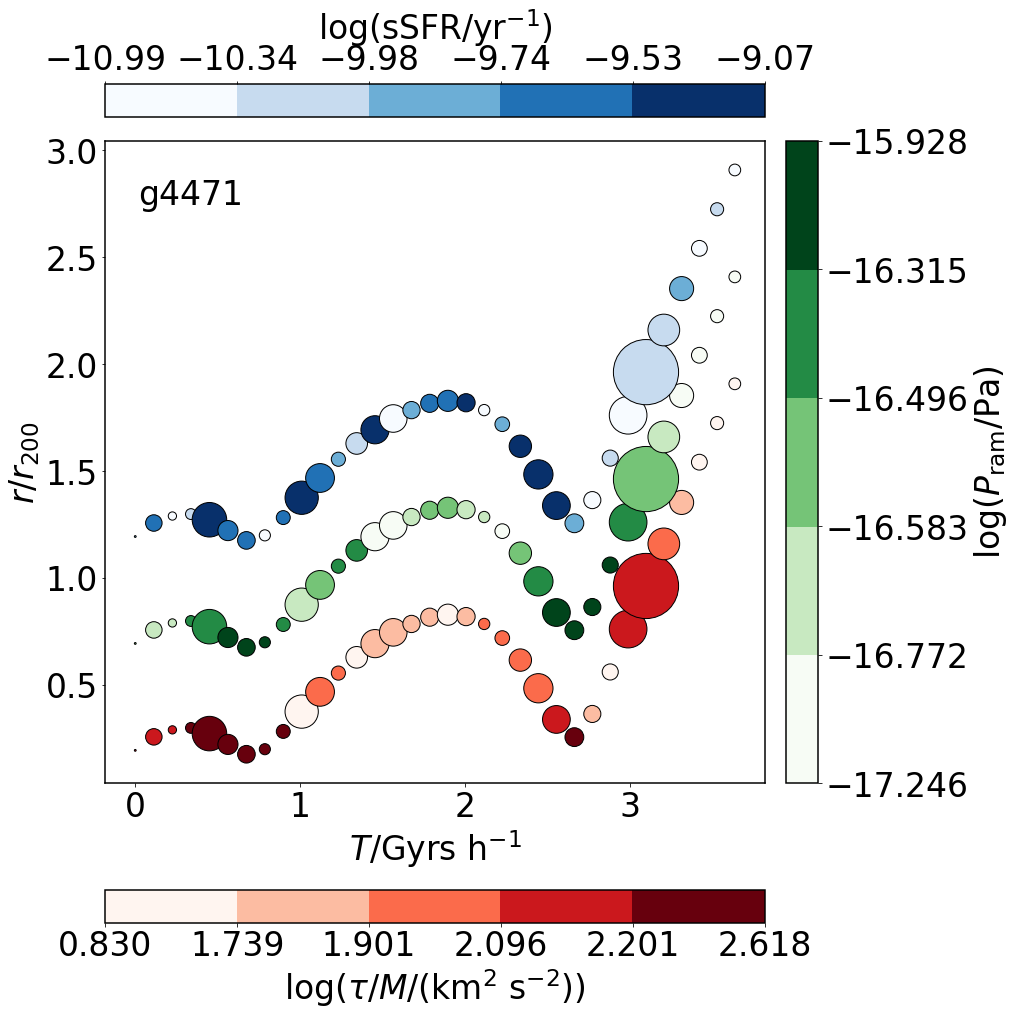

In [18]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4471/gMass_4471), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4471, dist_4471, s=Gas_4471/5e5, c=np.log10(TSt_4471/gMass_4471), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4471), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4471, dist_4471+0.5, s=Gas_4471/5e5, c=np.log10(RP_4471), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4471/starMass_4471)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4471, dist_4471+1., s=Gas_4471/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4471')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

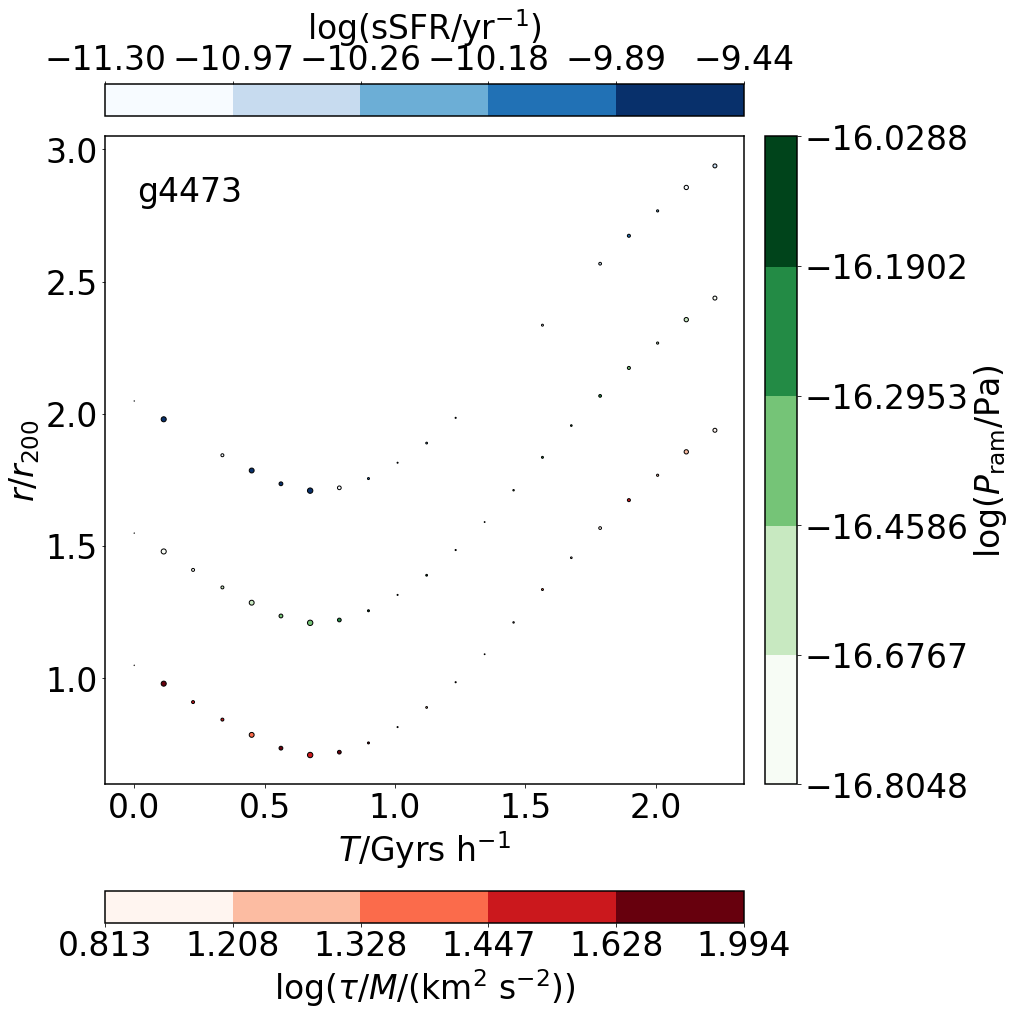

In [19]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4473/gMass_4473), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4473, dist_4473, s=Gas_4473/5e5, c=np.log10(TSt_4473/gMass_4473), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4473), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4473, dist_4473+0.5, s=Gas_4473/5e5, c=np.log10(RP_4473), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4473/starMass_4473)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4473, dist_4473+1., s=Gas_4473/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4473')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T$/Gyrs h$^{-1}$')

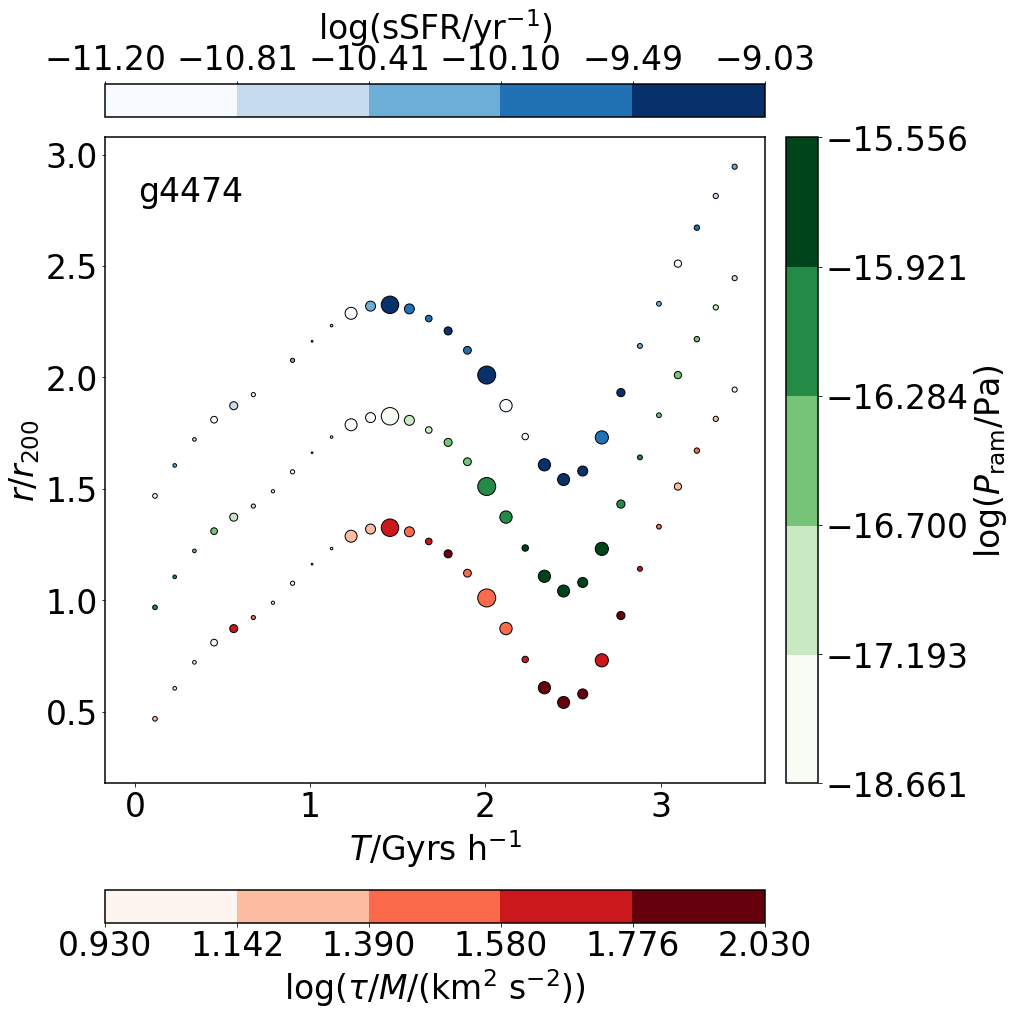

In [20]:
pl.figure(figsize=(14,14), constrained_layout=True)

vaper = np.linspace(0, 100, 6)
papels = np.percentile(np.log10(TSt_4474/gMass_4474), vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(Time_4474, dist_4474, s=Gas_4474/5e5, c=np.log10(TSt_4474/gMass_4474), norm=norm, cmap=cm.Reds, edgecolors='black')
barT = pl.colorbar(label='log($\\tau/M$/(km$^2$ s$^{-2})$)',location='bottom')
barT.set_ticks(papels)

papels2 = np.percentile(np.log10(RP_4474), vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(Time_4474, dist_4474+0.5, s=Gas_4474/5e5, c=np.log10(RP_4474), norm=norm2, cmap=cm.Greens, edgecolors='black')
barRP = pl.colorbar(label='$\log(P_{\\rm ram}$/Pa$)$', location='right')
barRP.set_ticks(papels2)

lsSFR = np.log10(SFR_4474/starMass_4474)

inan = np.where((np.isnan(lsSFR)==False) & (np.isnan(lsSFR)==False) &(np.isinf(lsSFR)==False) & (np.isinf(lsSFR)==False))

papels3 = np.percentile(lsSFR[inan], vaper)
papels3 = papels3*100
papels3 = papels3.astype('int')
papels3 = papels3/100.
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(Time_4474, dist_4474+1., s=Gas_4474/5e5, c=lsSFR, norm=norm3, cmap=cm.Blues, edgecolors='black')
bar3 = pl.colorbar(label='$\log($sSFR/yr$^{-1})$', location='top')
bar3.set_ticks(papels3)


xlim = pl.xlim()
ylim = pl.ylim()

deltax = xlim[1]-xlim[0]
deltay = ylim[1]-ylim[0]

pl.text(xlim[0]+deltax/20., ylim[1]-deltay/10., 'g4474')

pl.ylabel('$r/r_{200}$')
pl.xlabel('$T$/Gyrs h$^{-1}$')